In [20]:
import h5py
import scipy.io as io
import PIL.Image as Image
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter 
import scipy
import json
from matplotlib import cm as CM
from image import *
from model import CSRNet
import torch
%matplotlib inline

In [21]:
#this is borrowed from https://github.com/davideverona/deep-crowd-counting_crowdnet
# def gaussian_filter_density(gt):
#     print(gt.shape)
#     density = np.zeros(gt.shape, dtype=np.float32)
#     gt_count = np.count_nonzero(gt)
#     if gt_count == 0:
#         return density

#     pts = np.array(zip(np.nonzero(gt)[1], np.nonzero(gt)[0]))
#     leafsize = 2048
#     # build kdtree
#     tree = scipy.spatial.KDTree(pts.copy(), leafsize=leafsize)
#     # query kdtree
#     distances, locations = tree.query(pts, k=4)

#     print ('generate density...')
#     for i, pt in enumerate(pts):
#         pt2d = np.zeros(gt.shape, dtype=np.float32)
#         pt2d[pt[1],pt[0]] = 1.
#         if gt_count > 1:
#             sigma = (distances[i][1]+distances[i][2]+distances[i][3])*0.1
#         else:
#             sigma = np.average(np.array(gt.shape))/2./2. #case: 1 point
#         density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')
#     print( 'done.')
#     return density


def gaussian_filter_density(gt):
    #Generates a density map using Gaussian filter transformation
    density = np.zeros(gt.shape, dtype=np.float32)
    gt_count = np.count_nonzero(gt)   
    if gt_count == 0:
        return density
    # FInd out the K nearest neighbours using a KDTree
    pts = np.array(list(zip(np.nonzero(gt)[1].ravel(), np.nonzero(gt)[0].ravel())))
    leafsize = 2048  
    # build kdtree
    tree = scipy.spatial.KDTree(pts.copy(), leafsize=leafsize)  
    # query kdtree
    distances, locations = tree.query(pts, k=4)
        
    for i, pt in enumerate(pts):
        pt2d = np.zeros(gt.shape, dtype=np.float32)
        pt2d[pt[1],pt[0]] = 1.
        if gt_count > 1:
            sigma = (distances[i][1]+distances[i][2]+distances[i][3])*0.1
        else:
            sigma = np.average(np.array(gt.shape))/2./2. #case: 1 point     
        #Convolve with the gaussian filter      
        density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')  
    return density



In [22]:
#set the root to the Shanghai dataset you download
root = r'D:\data\ShanghaiTech_Crowd_Counting_Dataset'

In [23]:
#now generate the ShanghaiA's ground truth
part_A_train = os.path.join(root,'part_A_final/train_data','images')
part_A_test = os.path.join(root,'part_A_final/test_data','images')
part_B_train = os.path.join(root,'part_B_final/train_data','images')
part_B_test = os.path.join(root,'part_B_final/test_data','images')
path_sets = [part_A_train,part_A_test]

In [24]:
# img_paths = []
# for path in path_sets:
#     for img_path in glob.glob(os.path.join(path, '*.jpg')):
#         img_paths.append(img_path)
img_paths = []
for path in path_sets:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths.append(img_path)
print(len(img_paths))
print(img_paths[0:5])

482
['D:\\data\\ShanghaiTech_Crowd_Counting_Dataset\\part_A_final/train_data\\images\\IMG_1.jpg', 'D:\\data\\ShanghaiTech_Crowd_Counting_Dataset\\part_A_final/train_data\\images\\IMG_10.jpg', 'D:\\data\\ShanghaiTech_Crowd_Counting_Dataset\\part_A_final/train_data\\images\\IMG_100.jpg', 'D:\\data\\ShanghaiTech_Crowd_Counting_Dataset\\part_A_final/train_data\\images\\IMG_101.jpg', 'D:\\data\\ShanghaiTech_Crowd_Counting_Dataset\\part_A_final/train_data\\images\\IMG_102.jpg']


In [25]:
for img_path in img_paths:
#     print(img_path)
#     mat = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground_truth').replace('IMG_','GT_IMG_'))
#     img= plt.imread(img_path)
#     k = np.zeros((img.shape[0],img.shape[1]))
#     gt = mat["image_info"][0,0][0,0][0]
#     for i in range(0,len(gt)):
#         if int(gt[i][1])<img.shape[0] and int(gt[i][0])<img.shape[1]:
#             k[int(gt[i][1]),int(gt[i][0])]=1
#     k = gaussian_filter_density(k)
    print(img_path)
    mat = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground_truth').replace('IMG_','GT_IMG_'))
    gt = mat["image_info"][0,0][0,0][0]

    print(mat["image_info"][0,0][0,0][0])
    print(gt.shape)  #27张人脸的坐标

    img= plt.imread(img_path)
    k = np.zeros((img.shape[0],img.shape[1]))
    for i in range(0,len(gt)):
        if int(gt[i][1])<img.shape[0] and int(gt[i][0])<img.shape[1]:
            k[int(gt[i][1]),int(gt[i][0])]=1

        # generate density map
    k = gaussian_filter_density(k)
    with h5py.File(img_path.replace('.jpg','.h5').replace('images','ground_truth'), 'w') as hf:
            hf['density'] = k

D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_1.jpg
[[ 29.6225116  472.92022152]
 [ 54.35533603 454.96602305]
 [ 51.79045053 460.46220626]
 ...
 [597.89732076 688.27900015]
 [965.77518336 638.44693908]
 [166.9965574  628.1873971 ]]
(1546, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_10.jpg
[[ 855.32345978  590.49587357]
 [ 965.5908524   472.79472415]
 [ 937.09478464  400.93507502]
 ...
 [  42.5852337   359.87860699]
 [1017.48233659    8.99748811]
 [1017.48233659   23.31916643]]
(920, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_100.jpg
[[ 533.06708564  582.70362355]
 [ 486.56544037  543.43556755]
 [ 468.99815216  585.80373324]
 [ 359.46094329  568.23644502]
 [ 377.0282315   539.30208797]
 [ 344.99376476  524.83490944]
 [ 810.01021749  510.36773091]
 [ 843.07805413  512.4344707 ]
 [ 839.97794445  477.29989427]
 [ 863.74545203  470.066305  ]
 [ 893.71317898  495.90055238]
 [ 918.514

 [ 966.60148595  466.06944968]]
(373, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_101.jpg
[[ 470.55794206  504.6998002 ]
 [ 398.94955045  504.6998002 ]
 [ 430.66183816  469.91858142]
 [ 299.72077922  522.09040959]
 [ 155.48101898  552.77972028]
 [ 136.04445554  506.74575425]
 [  48.06843157  527.20529471]
 [  65.45904096  452.52797203]
 [  17.37912088  466.84965035]
 [  66.48201798  420.81568432]
 [  18.4020979   404.44805195]
 [  41.93056943  388.08041958]
 [ 547.28121878  535.38911089]
 [ 642.41808192  537.43506494]
 [ 691.52097902  537.43506494]
 [ 791.77272727  552.77972028]
 [ 831.66883117  587.56093906]
 [ 863.38111888  533.34315684]
 [1018.87362637  511.86063936]
 [ 960.56393606  452.52797203]
 [ 859.28921079  474.01048951]
 [ 903.27722278  524.13636364]
 [ 930.8976024   399.33316683]
 [ 991.25324675  363.52897103]
 [1016.82767233  406.49400599]
 [ 776.42807193  476.05644356]
 [ 758.01448551  433.09140859]
 [ 714.02647353  426.95354645]
 [ 6

 [ 128.62787213  322.35414585]]
(298, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_102.jpg
[[1049.31293706  576.05819181]
 [ 399.72252747  214.9473027 ]
 [ 399.72252747  227.22302697]
 [ 473.37687313  208.80944056]
 [ 438.59565435  211.87837163]
 [ 541.91633367  201.6486014 ]
 [ 419.15909091    3.19105894]
 [ 444.73351648  370.43981019]
 [ 442.68756244  693.70054945]
 [ 426.31993007  741.78046953]
 [ 375.17107892  659.94230769]
 [ 316.86138861  705.97627373]
 [ 275.94230769  704.9532967 ]
 [ 173.64460539  753.03321678]
 [ 193.08116883  613.90834166]
 [ 241.16108891  559.69055944]
 [ 121.47277722  638.45979021]
 [  98.96728272  668.12612388]
 [  64.18606394  659.94230769]
 [  45.77247752  661.98826174]
 [  13.03721279  599.58666334]
 [   2.80744256  543.32292707]
 [  29.40484515  471.71453546]
 [  46.79545455  441.02522478]
 [  27.35889111  434.88736264]
 [   8.9453047   450.23201798]
 [  54.97927073  411.35889111]
 [  64.18606394  423.63461538]
 [  

 [106.77372627  99.38986014]]
(360, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_105.jpg
[[ 18.7967033  540.51098901]
 [ 36.5989011  468.31318681]
 [128.57692308 531.60989011]
 [272.97252747 462.37912088]
 [345.17032967 563.25824176]
 [400.55494505 460.4010989 ]
 [438.13736264 562.26923077]
 [579.56593407 478.2032967 ]
 [636.92857143 583.03846154]
 [656.70879121 467.32417582]
 [735.82967033 531.60989011]
 [746.70879121 420.84065934]
 [868.35714286 529.63186813]
 [899.01648352 433.6978022 ]
 [974.18131868 439.63186813]
 [976.15934066 550.4010989 ]
 [834.73076923 365.45604396]
 [870.33516484 338.75274725]
 [940.55494505 342.70879121]
 [994.95054945 322.92857143]
 [983.08241758 312.04945055]
 [863.41208791 302.15934066]
 [800.11538462 316.00549451]
 [748.68681319 345.67582418]
 [680.44505495 364.46703297]
 [593.41208791 387.21428571]
 [527.14835165 403.03846154]
 [450.99450549 406.99450549]
 [354.07142857 406.00549451]
 [241.32417582 382.26923077]
 [15

 [ 29.66753927 160.65270506]]
(121, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_108.jpg
[[ 46.67076923  21.6219137 ]
 [ 13.93350844  47.19789869]
 [ 35.92885553  70.72780488]
 ...
 [624.65681051   7.2993621 ]
 [582.71219512  10.88      ]
 [657.6654409    4.2302439 ]]
(733, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_109.jpg
[[1011.29937169  572.20732021]
 [ 980.4332329   536.01943335]
 [ 776.07810712  615.84565436]
 ...
 [ 429.07621517  254.4989606 ]
 [ 715.43409712  358.80522271]
 [ 921.89400416  672.25618387]]
(862, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_11.jpg
[[  30.67360622  563.07803993]
 [ 105.31835431  515.8030328 ]
 [ 201.11244769  457.33131346]
 [ 222.26179298  393.88327759]
 [ 209.82100163  529.48790329]
 [ 272.02495838  524.51158675]
 [ 361.59865609  544.4168529 ]
 [ 350.40194387  485.94513357]
 [ 515.86446881  535.70829896]
 [ 504.6677566   489.67737097]
 

 [ 887.22209056  497.76388535]]
(248, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_110.jpg
[[ 155.32917431  476.51555556]
 [ 149.06617737  390.92126402]
 [ 292.07127421  237.47783894]
 [  20.67474006  230.17100917]
 [  14.41174312  148.75204893]
 [  40.50756371  186.33003058]
 [  86.43620795  161.27804281]
 [ 130.27718654  139.35755352]
 [ 166.81133537  167.54103976]
 [   7.10491335  105.95490316]
 [  34.24456677  105.95490316]
 [  67.64721713  104.91107034]
 [ 113.57586137   94.4727421 ]
 [ 136.54018349  102.82340469]
 [ 127.14568807   72.5522528 ]
 [ 162.63600408   79.85908257]
 [ 196.03865443   80.90291539]
 [ 212.73997961   66.28925586]
 [ 222.13447503   79.85908257]
 [ 210.65231397  119.52472987]
 [ 245.09879715  142.48905199]
 [ 512.32        470.25255861]
 [ 687.68391437  395.09659531]
 [ 794.15486239  292.80097859]
 [ 891.23131498  275.05582059]
 [1009.18442406  322.02829766]
 [ 981.00093782   72.5522528 ]
 [ 966.38727829    4.70311927]
 [10

 [146.6038961    2.18581419]]
(259, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_115.jpg
[[  38.92473118  196.71407625]
 [  30.94037146  170.76490714]
 [  54.89345064  160.78445748]
 [  84.83479961  166.77272727]
 [ 103.79765396  126.85092864]
 [ 138.72922776  128.84701857]
 [ 164.67839687  107.88807429]
 [ 201.60606061  121.86070381]
 [ 245.5200391   121.86070381]
 [ 244.52199413  168.7688172 ]
 [ 216.57673509  203.70039101]
 [ 163.68035191  181.74340176]
 [ 129.74682307  188.72971652]
 [ 140.72531769  212.6827957 ]
 [ 161.68426197  223.66129032]
 [ 136.73313783  248.61241447]
 [  82.83870968  212.6827957 ]
 [  54.89345064  205.69648094]
 [  33.93450635  272.56549365]
 [  67.86803519  285.5400782 ]
 [  71.86021505  337.43841642]
 [ 123.75855327  316.47947214]
 [ 208.59237537  304.50293255]
 [ 177.65298143  281.54789834]
 [ 143.71945259  269.57135875]
 [ 110.78396872  276.55767351]
 [ 129.74682307  364.3856305 ]
 [ 113.77810362  476.16666667]
 [  22

 [ 604.83816184  201.96203796]]
(288, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_116.jpg
[[ 63.09780908 457.7143975 ]
 [  7.01017214 444.69405321]
 [ 32.04929577 397.62050078]
 ...
 [540.42115637   7.43823916]
 [570.27660972   8.27923784]
 [615.69053876   4.49474376]]
(614, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_117.jpg
[[ 20.9084507  515.61971831]
 [ 91.58450704 482.09389671]
 [ 77.99295775 437.69483568]
 [ 27.25117371 452.19248826]
 [ 57.15258216 566.36150235]
 [156.82394366 463.0657277 ]
 [164.97887324 546.42723005]
 [226.59389671 566.36150235]
 [253.77699531 544.61502347]
 [289.11502347 569.98591549]
 [338.95070423 546.42723005]
 [258.30751174 463.0657277 ]
 [214.81455399 483.90610329]
 [208.47183099 425.00938967]
 [184.00704225 391.48356808]
 [134.1713615  391.48356808]
 [107.8943662  298.15492958]
 [150.48122066 254.66197183]
 [173.13380282 296.342723  ]
 [211.19014085 338.92957746]
 [193.9741784  3

 [355.04545455  33.21678322]]
(358, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_118.jpg
[[  10.816418    309.92264579]
 [  29.41218716  304.34391504]
 [  47.54306209  296.90560738]
 ...
 [ 958.33387175  314.6959836 ]
 [1007.91593087   11.65050362]
 [   7.4021694   136.72248717]]
(1621, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_119.jpg
[[  39.64373089  555.32670744]
 [  75.13404689  520.88022426]
 [  99.14220183  569.94036697]
 [ 139.85168196  525.05555556]
 [ 203.5254842   567.85270133]
 [ 250.49796126  553.23904179]
 [ 206.65698267  509.3980632 ]
 [ 271.37461774  501.04740061]
 [ 326.69775739  553.23904179]
 [ 376.80173293  542.80071356]
 [ 404.98521916  570.9841998 ]
 [ 460.30835882  494.78440367]
 [ 482.22884811  474.95158002]
 [ 410.20438328  464.51325178]
 [ 334.00458716  461.38175331]
 [ 298.51427115  453.03109072]
 [ 226.48980632  433.19826707]
 [ 178.47349643  482.25840979]
 [ 197.26248726  401.883282

 [311.35367762   9.54773083]]
(156, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_122.jpg
[[  51.98293586  778.17524559]
 [  43.52286152  756.4207687 ]
 [  64.06875636  710.49465082]
 [  39.89711537  582.38495357]
 [  18.14263848  573.92487922]
 [  33.85420512  540.08458184]
 [  33.85420512  511.07861265]
 [  42.31427947  494.15846396]
 [  55.60868201  448.23234607]
 [  74.9459948   463.94391272]
 [  80.98890505  476.02973321]
 [  85.82323325  514.7043588 ]
 [  82.1974871   550.96182028]
 [  94.2833076   608.97375866]
 [ 139.00084343  652.48271244]
 [ 148.66949982  700.82599442]
 [ 177.67546901  702.03457647]
 [ 143.83517163  605.34801251]
 [ 164.38106647  592.05360997]
 [ 119.66353064  570.29913308]
 [ 161.96390237  514.7043588 ]
 [ 139.00084343  489.32413576]
 [ 102.74338194  472.40398706]
 [ 103.95196399  453.06667427]
 [ 113.62062039  424.06070508]
 [  96.70047169  421.64354099]
 [ 126.91502293  421.64354099]
 [ 142.62658958  438.56368968]
 [ 164

 [ 100.96624224  538.59013281]]
(466, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_123.jpg
[[  30.54891262  737.77548806]
 [ 124.94064749  753.50744388]
 [ 138.25230241  729.30443493]
 [ 180.60756806  677.26796571]
 [ 267.73840025  700.2608242 ]
 [  71.69402782  617.9705938 ]
 [ 166.08576269  592.55743441]
 [  91.05643497  567.14427502]
 [ 127.36094838  550.20216876]
 [  55.96207201  533.26006251]
 [  24.49816038  454.60028344]
 [ 100.73763855  440.07847808]
 [  66.85342603  398.93336288]
 [  19.65755859  412.2450178 ]
 [  14.8169568   336.00553963]
 [  58.3823729   360.20854857]
 [ 157.61470956  320.27358382]
 [ 130.99139973  412.2450178 ]
 [ 157.61470956  437.65817719]
 [ 152.77410777  473.9626906 ]
 [ 143.0929042   501.79615088]
 [  65.64327558  267.02696414]
 [  78.9549305   233.14275163]
 [   6.34590368  239.19350386]
 [  51.12147022  194.41793732]
 [  14.8169568   195.62808777]
 [  35.38951441  165.37432659]
 [   8.76620457  132.70026452]
 [  

 [527.46103896 403.66883117]]
(752, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_125.jpg
[[ 53.53084416  33.06087662]
 [ 27.84902597 107.35470779]
 [124.15584416 188.9862013 ]
 [123.23863636  12.88230519]
 [140.66558442   3.71022727]
 [285.58441558   2.79301948]
 [250.73051948   6.46185065]
 [279.16396104  22.05438312]
 [258.06818182  44.06737013]
 [243.39285714  76.16964286]
 [225.0487013   95.43100649]
 [185.60876623 188.9862013 ]
 [193.6572012  212.44062007]
 [243.12269601 122.6417218 ]
 [391.51918044  13.05662561]
 [357.27383788  45.77995294]
 [292.58819082 118.07567613]
 [304.00330501 146.9939654 ]
 [366.40592923 128.7297827 ]
 [362.60089117 172.86822422]
 [353.46879982 253.53503114]
 [257.58184065 239.83689412]
 [247.68874169 200.26449827]
 [383.14809671 392.79942422]
 [138.10364549 458.24607889]
 [416.63243165 381.38431004]
 [421.95948494 257.34006921]
 [406.73933269 200.26449827]
 [439.46266003 184.28333841]
 [524.69551262 197.22046782]
 [58

 [ 291.16496304  314.98089111]]
(279, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_127.jpg
[[  4.72077922  13.40584416]
 [ 47.57792208   5.61363636]
 [ 44.16883117  21.19805195]
 [ 31.50649351  20.22402597]
 [ 22.25324675  43.11363636]
 [ 36.86363636  68.43831169]
 [ 21.76623377  87.43181818]
 [  5.69480519  82.07467532]
 [ 42.22077922 111.29545455]
 [ 46.6038961  102.04220779]
 [ 33.94155844 114.21753247]
 [ 28.0974026  136.13311688]
 [ 46.11688312 154.63961039]
 [ 12.02597403 163.40584416]
 [ 21.76623377 182.88636364]
 [ 27.61038961 206.26298701]
 [ 35.88961039 213.56818182]
 [ 55.85714286 181.91233766]
 [ 58.77922078 166.81493506]
 [ 69.98051948 140.51623377]
 [ 82.64285714  99.60714286]
 [ 87.51298701  69.89935065]
 [ 63.16233766  52.8538961 ]
 [ 72.9025974   33.86038961]
 [ 61.7012987   40.67857143]
 [ 96.76623377  22.17207792]
 [ 87.51298701   6.58766234]
 [ 83.61688312  27.52922078]
 [105.04545455  38.24350649]
 [125.5         30.93831169]
 [

 [312.06343656 137.62337662]]
(256, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_13.jpg
[[  35.2876588   510.92740472]
 [  63.75771325  445.85299456]
 [  17.66333938  401.11433757]
 [ 111.20780399  387.55716878]
 [ 191.19509982  387.55716878]
 [ 269.82667877  435.00725953]
 [ 305.0753176   444.49727768]
 [ 158.65789474  462.1215971 ]
 [ 111.20780399  539.39745917]
 [ 382.35117967  375.35571688]
 [ 431.1569873   375.35571688]
 [ 451.49274047  467.54446461]
 [ 503.00998185  448.56442831]
 [ 521.99001815  398.40290381]
 [ 557.23865699  382.13430127]
 [ 588.42014519  384.84573503]
 [ 569.44010889  436.36297641]
 [ 574.86297641  496.01451906]
 [ 661.62885662  401.11433757]
 [ 711.79038113  368.57713249]
 [ 747.03901996  357.73139746]
 [ 774.15335753  395.69147005]
 [ 814.82486388  372.64428312]
 [ 858.20780399  365.86569873]
 [ 858.20780399  436.36297641]
 [ 907.01361162  410.60435572]
 [ 904.30217786  349.59709619]
 [ 974.79945554  349.59709619]
 [ 976.

 [ 812.11343013   77.43693285]]
(388, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_130.jpg
[[ 41.43181818 652.64772727]
 [ 32.60930736 631.69426407]
 [ 33.71212121 616.25487013]
 ...
 [966.53513154 168.13986014]
 [964.48917749 166.09390609]
 [947.0985681  181.43856144]]
(1177, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_131.jpg
[[111.42207792 476.26785714]
 [ 81.50974026 447.9724026 ]
 [ 87.97727273 427.76136364]
 ...
 [315.14935065 161.78409091]
 [370.93181818 203.82305195]
 [181.75649351 166.63474026]]
(603, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_132.jpg
[[116.53153745 728.48948752]
 [ 30.32917214 681.18331143]
 [ 21.91918528 592.87844941]
 [ 66.07161629 582.36596583]
 [ 77.63534823 519.29106439]
 [178.55519054 567.64848883]
 [115.48028909 453.06241787]
 [ 71.32785808 449.9086728 ]
 [ 94.45532194 416.26872536]
 [ 39.79040736 405.75624179]
 [ 10.35545335 430.98620237]


 [244.48601399  22.8986014 ]]
(354, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_136.jpg
[[ 26.68181818 474.93181818]
 [ 71.32467532 484.67207792]
 [136.25974026 446.52272727]
 ...
 [590.80519481 174.60714286]
 [138.69480519 196.52272727]
 [469.05194805 176.23051948]]
(701, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_137.jpg
[[213.47343591 457.75611398]
 [254.39251683 518.11175833]
 [160.27863072 502.76710299]
 ...
 [866.64426509 134.59978993]
 [867.66724211 140.22616356]
 [671.2556537  156.59379593]]
(1357, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_138.jpg
[[  45.07009785  566.28510062]
 [ 124.34490625  513.43522836]
 [ 163.45381172  496.52326923]
 [ 198.33472742  538.80316704]
 [ 249.07060479  511.32123347]
 [ 327.28841574  521.89120792]
 [ 390.70826246  501.80825646]
 [ 357.94134166  466.92734076]
 [ 329.40241064  475.38332033]
 [ 261.75457414  462.69935098]
 [ 189.8787

 [ 927.59164     275.69230769]]
(423, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_139.jpg
[[ 47.75649351 146.15746753]
 [ 27.33441558 158.7711039 ]
 [ 12.31818182 155.76785714]
 [  9.91558442 173.18668831]
 [ 22.52922078 183.39772727]
 [ 34.54220779 174.98863636]
 [ 56.76623377 168.38149351]
 [ 62.17207792 153.36525974]
 [ 74.78571429 149.76136364]
 [ 83.19480519 154.56655844]
 [106.01948052 151.56331169]
 [116.83116883 155.76785714]
 [ 98.81168831 160.57305195]
 [127.64285714 158.17045455]
 [123.43831169 169.58279221]
 [154.67207792 145.55681818]
 [140.85714286 152.16396104]
 [148.06493506 161.77435065]
 [156.47402597 155.76785714]
 [179.89935065 162.375     ]
 [171.49025974 153.96590909]
 [191.31168831 153.96590909]
 [202.12337662 151.56331169]
 [220.74350649 155.76785714]
 [193.11363636 180.99512987]
 [206.32792208 179.19318182]
 [217.13961039 174.98863636]
 [233.95779221 162.97564935]
 [246.57142857 155.76785714]
 [260.38636364 153.36525974]
 [

 [ 167.19333834  577.44996659]]
(378, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_140.jpg
[[ 363.97768595  587.60743802]
 [ 464.26198347  596.49338843]
 [ 648.32809917  750.09338843]
 [ 630.55619835  652.34793388]
 [ 748.61239669  633.30661157]
 [ 767.65371901  484.78429752]
 [1008.84380165  681.5446281 ]
 [ 979.64710744  480.97603306]
 [ 843.81900826  394.6553719 ]
 [ 749.88181818  414.9661157 ]
 [ 650.86694215  421.31322314]
 [ 582.31818182  407.34958678]
 [ 476.95619835  392.11652893]
 [ 418.56280992  390.84710744]
 [ 367.78595041  505.09504132]
 [ 154.5231405   557.14132231]
 [ 200.22231405  508.90330579]
 [ 250.99917355  511.44214876]
 [ 162.13966942  491.13140496]
 [ 124.05702479  508.90330579]
 [  79.62727273  508.90330579]
 [  42.81404959  470.82066116]
 [  28.85041322  408.61900826]
 [  56.77768595  404.8107438 ]
 [  93.59090909  387.03884298]
 [ 136.75123967  425.1214876 ]
 [ 159.60082645  426.39090909]
 [ 183.71983471  408.61900826]
 [ 2

 [ 685.38311688   97.04345654]]
(357, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_141.jpg
[[  14.75688073 1975.83944954]
 [  75.85779817 1503.32568807]
 [ 829.43577982 1499.25229358]
 ...
 [  13.60689311  101.47252747]
 [  23.83666334  105.94805195]
 [ 170.88961039  109.78421578]]
(502, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_142.jpg
[[ 64.75619835 437.82644628]
 [ 47.45867769 393.45454545]
 [  9.10330579 394.95867769]
 [ 14.3677686  373.14876033]
 [ 83.55785124 420.52892562]
 [ 68.51652893 400.97520661]
 [112.88842975 422.78512397]
 [106.87190083 444.59504132]
 [136.20247934 444.59504132]
 [139.96280992 419.7768595 ]
 [170.04545455 427.29752066]
 [169.29338843 445.34710744]
 [187.34297521 443.84297521]
 [204.64049587 416.76859504]
 [191.8553719  392.70247934]
 [148.98760331 401.72727273]
 [124.9214876  393.45454545]
 [ 83.55785124 352.84297521]
 [ 53.47520661 357.3553719 ]
 [ 24.89669421 350.58677686]
 [  

 [657.44805195 252.0959041 ]]
(320, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_143.jpg
[[   9.15251339  557.30428497]
 [  57.16882328  571.9179445 ]
 [ 164.68360412  594.88226662]
 ...
 [ 930.67753679  534.82486021]
 [1015.5846297   465.26242265]
 [-118.89688879    2.87680827]]
(1297, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_144.jpg
[[490.28512397 566.3446281 ]
 [503.61404959 568.88347107]
 [516.30826446 575.23057851]
 ...
 [872.58791209 302.66183816]
 [874.63386613 256.62787213]
 [837.80669331 252.53596404]]
(777, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_145.jpg
[[ 347.29220835  402.33444592]
 [ 481.42319564  381.31391806]
 [ 541.48184667  312.24646938]
 [ 703.64020444  375.30805296]
 [ 648.586441    477.4077597 ]
 [ 735.67148499  481.41166977]
 [ 770.70569808  531.46054563]
 [ 915.84743807  465.3960295 ]
 [ 950.88165116  379.31196303]
 [  33.98624549  198.13503243]

 [ 969.72422794  544.64374952]]
(350, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_146.jpg
[[ 936.69569994  289.48798983]
 [ 934.21153973  239.18374571]
 [ 932.34841958  200.0582225 ]
 [1010.59946599  182.66910108]
 [1010.59946599  147.89085823]
 [ 973.33706294  113.11261538]
 [ 970.85290273   62.18733121]
 [ 935.45361983   70.88189193]
 [ 976.44226319   31.75636872]
 [ 946.0113007    15.6093274 ]
 [ 920.54865861    5.67268659]
 [ 903.15953719   23.68284806]
 [ 841.0555321    33.61948887]
 [ 877.07585505  155.96437889]
 [ 816.21393007  182.04806103]
 [ 803.79312905  213.72110362]
 [ 871.4864946   257.19390718]
 [ 860.30777368  277.06718881]
 [ 829.87681119  301.28775079]
 [ 832.36097139  322.40311252]
 [ 863.41297394  354.07615512]
 [ 792.61440814  370.84423649]
 [ 738.58392371  332.96079339]
 [ 727.4052028   285.14070947]
 [ 713.74232168  310.60335156]
 [ 684.55343929  341.03431405]
 [ 641.08063573  364.01279593]
 [ 617.4811138   337.30807374]
 [ 5

 [ 995.239001    579.6955045 ]]
(284, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_147.jpg
[[ 128.81028305  726.10099234]
 [ 124.71837496  693.36572761]
 [ 103.23585748  642.21687646]
 [ 100.16692641  603.34374958]
 [  41.8572361   592.09100233]
 [  33.67341991  566.51657676]
 [  53.10998335  550.14894439]
 [  27.53555778  526.62047286]
 [  38.78830503  455.01208125]
 [  36.74235098  406.93216117]
 [  43.90319014  387.49559774]
 [   9.12197136  480.58650683]
 [  21.39769564  359.87521812]
 [  25.48960373  341.4616317 ]
 [  60.27082251  300.54255078]
 [  74.59250083  328.1629304 ]
 [  50.04105228  267.80728605]
 [  37.76532801  254.50858475]
 [  19.35174159  241.20988345]
 [  32.65044289  173.69339993]
 [  56.17891442  204.38271062]
 [  75.61547786  218.70438894]
 [  78.68440892  245.30179154]
 [  59.24784549  123.56752581]
 [  40.83425907  114.3607326 ]
 [  71.52356976  113.33775558]
 [  80.73036297  100.03905428]
 [  22.42067266   50.93615718]
 [  

 [ 954.35274059    5.92516817]]
(369, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_148.jpg
[[1.31122126e+02 4.64523636e+02]
 [1.51057902e+02 3.33695105e+02]
 [6.38388811e+01 3.02545455e+02]
 [3.39352168e+01 2.05358545e+02]
 [1.07448392e+02 2.12834462e+02]
 [3.14432448e+01 1.66732979e+02]
 [2.39673287e+01 1.38075301e+02]
 [3.01972587e+01 5.58402238e+01]
 [5.27753846e+00 4.33803636e+01]
 [1.42336000e+02 1.77946853e+02]
 [1.77223608e+02 1.65486993e+02]
 [2.03389315e+02 1.97882629e+02]
 [1.92175441e+02 2.26540308e+02]
 [2.54474741e+02 2.27786294e+02]
 [3.08052140e+02 3.10021371e+02]
 [3.42939748e+02 3.95994406e+02]
 [3.87795245e+02 4.57047720e+02]
 [3.67859469e+02 3.84780531e+02]
 [4.15206937e+02 3.87272503e+02]
 [4.99933986e+02 4.25898070e+02]
 [5.32329622e+02 3.46154965e+02]
 [4.40126657e+02 3.07529399e+02]
 [3.80319329e+02 2.77625734e+02]
 [3.46677706e+02 2.73887776e+02]
 [2.96838266e+02 2.20310378e+02]
 [2.58212699e+02 1.87914741e+02]
 [2.71918545e+

 [ 325.97504456  202.57844117]]
(165, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_150.jpg
[[957.89296636 425.01325178]
 [919.82466871 445.77777778]
 [921.30784913 424.02446483]
 ...
 [172.502997   446.43906094]
 [189.94555445 434.81068931]
 [500.03546454 210.96453546]]
(989, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_151.jpg
[[ 81.65702479 435.89338843]
 [ 24.29504132 419.95950413]
 [ 18.71818182 405.61900826]
 ...
 [ 96.70579421 441.01598402]
 [392.11838162 441.73126873]
 [400.7017982  432.43256743]]
(992, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_152.jpg
[[ 18.68181818 591.0785124 ]
 [  7.77272727 560.33471074]
 [  4.79752066 510.74793388]
 [ 82.15289256 520.66528926]
 [125.7892562  532.5661157 ]
 [112.89669421 569.26033058]
 [129.75619835 593.06198347]
 [213.06198347 573.22727273]
 [186.28512397 543.47520661]
 [169.42561983 504.79752066]
 [226.94628099 515.70661157]
 

 [  4.79752066 301.49173554]]
(442, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_153.jpg
[[ 25.1835443  386.89240506]
 [ 20.75316456 367.90506329]
 [ 38.47468354 359.0443038 ]
 ...
 [539.06143856  31.46903097]
 [540.26023976  17.68281718]
 [541.45904096   6.29420579]]
(706, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_154.jpg
[[4.77727273e+01 3.98966116e+02]
 [8.35280992e+01 4.02404132e+02]
 [5.60239669e+01 3.58397521e+02]
 [2.37066116e+01 3.65273554e+02]
 [1.88933884e+01 3.36394215e+02]
 [3.47082645e+01 3.47395868e+02]
 [9.52173554e+01 3.88652066e+02]
 [9.65925620e+01 3.46708264e+02]
 [8.55909091e+01 3.52209091e+02]
 [1.68103306e+02 3.72837190e+02]
 [2.21736364e+02 3.61147934e+02]
 [2.14172727e+02 3.81088430e+02]
 [1.87356198e+02 3.35019008e+02]
 [1.94919835e+02 3.19204132e+02]
 [2.53366116e+02 3.42582645e+02]
 [2.46490083e+02 3.16453719e+02]
 [2.41676860e+02 3.06139669e+02]
 [1.96982645e+02 2.97200826e+02]
 [1.

 [616.47402597  50.77422577]]
(413, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_156.jpg
[[  7.2529976    3.06814548]
 [ 30.17226219  10.84432454]
 [ 49.40807354  33.35431655]
 ...
 [229.13536464 514.52647353]
 [251.64085914 518.61838162]
 [319.15734266 202.51848152]]
(728, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_157.jpg
[[135.          83.        ]
 [197.77777778  90.77777778]
 [227.22222222 147.44444444]
 [240.55555556 184.66666667]
 [227.22222222 220.77777778]
 [287.22222222 261.33333333]
 [201.11111111 288.55555556]
 [173.88888889 325.22222222]
 [218.33333333 430.77777778]
 [288.33333333 379.66666667]
 [ 65.55555556 366.33333333]
 [ 55.         320.77777778]
 [ 27.77777778 365.22222222]
 [ 66.11111111 243.        ]
 [  2.22222222 300.77777778]
 [ 90.55555556 215.77777778]
 [142.22222222 179.66666667]
 [ 70.         129.11111111]
 [ 38.33333333 139.11111111]
 [ 18.33333333 113.55555556]
 [ 82.77777778  77

 [ 510.31460933   15.49269885]]
(321, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_159.jpg
[[ 12.61111111 238.32777778]
 [ 36.34444444 242.61296296]
 [ 99.63333333 247.88703704]
 [120.4        252.17222222]
 [130.61851852 245.25      ]
 [144.46296296 240.96481481]
 [168.1962963  241.62407407]
 [196.54444444 242.94259259]
 [224.89259259 243.93148148]
 [239.72592593 240.63518519]
 [268.07407407 241.62407407]
 [284.88518519 241.9537037 ]
 [304.0037037  242.61296296]
 [333.34074074 237.99814815]
 [376.52222222 244.26111111]
 [358.72222222 247.88703704]
 [398.93703704 221.51666667]
 [341.91111111 216.57222222]
 [317.51851852 211.29814815]
 [288.84074074 213.93518519]
 [273.34814815 210.96851852]
 [248.2962963  212.28703704]
 [208.74074074 215.58333333]
 [187.64444444 213.93518519]
 [160.28518519 210.63888889]
 [116.77407407 210.30925926]
 [ 80.84444444 216.57222222]
 [ 57.11111111 217.23148148]
 [ 17.88518519 222.17592593]
 [  4.37037037 187.56481481]
 [

 [221.56789526 662.92400564]]
(161, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_160.jpg
[[  25.99681609  280.90289066]
 [  49.01929898  234.85792487]
 [   6.97824326  234.85792487]
 [  14.9860634   100.72693758]
 [  64.03396174  134.76017316]
 [  91.0603547   138.76408323]
 [ 121.08968021  123.74942047]
 [ 113.08186008  148.7738584 ]
 [ 104.07306242  165.79047619]
 [  56.0261416   162.78754364]
 [  38.00854629  183.8080715 ]
 [  55.02516408  197.82175674]
 [ 154.12193828  164.78949867]
 [ 170.13757855  187.81198157]
 [ 147.11509566  225.84912722]
 [ 168.13562352  258.88138528]
 [ 129.09750035  275.89800307]
 [ 225.19134199  266.88920542]
 [ 251.21675744  222.84619467]
 [ 286.25097053  263.88627287]
 [ 195.16201648  206.83055439]
 [ 223.18938696  180.80513895]
 [ 293.25781315  171.79634129]
 [ 310.27443095  155.78070102]
 [ 354.3174417   176.80122888]
 [ 339.30277894  205.82957687]
 [ 336.29984639  312.93417121]
 [ 384.34676721  385.00455244]
 [ 454

 [633.78671329 425.27522478]]
(81, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_162.jpg
[[142.42592593 434.57407407]
 [ 70.72222222 412.64814815]
 [ 84.35185185 429.83333333]
 [ 16.2037037  447.01851852]
 [137.68518519 397.24074074]
 [175.61111111 474.87037037]
 [192.7962963  380.05555556]
 [220.05555556 393.09259259]
 [218.27777778 368.2037037 ]
 [241.38888889 367.01851852]
 [288.2037037  372.94444444]
 [278.12962963 440.5       ]
 [320.2037037  468.94444444]
 [340.35185185 461.24074074]
 [359.31481481 410.27777778]
 [332.05555556 367.61111111]
 [403.16666667 339.16666667]
 [471.90740741 369.98148148]
 [454.12962963 369.98148148]
 [502.12962963 472.5       ]
 [580.94444444 370.57407407]
 [563.75925926 344.5       ]
 [537.09259259 335.01851852]
 [491.46296296 328.5       ]
 [617.09259259 342.12962963]
 [683.46296296 329.68518519]
 [711.90740741 363.46296296]
 [598.72222222 323.75925926]
 [620.64814815 292.35185185]
 [601.68518519 285.24074074]
 [579

 [925.44005994 163.61438561]]
(456, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_164.jpg
[[282.72222222  68.65925926]
 [291.27777778  67.51851852]
 [362.57407407  68.08888889]
 ...
 [224.54444444 187.86666667]
 [241.65555556 195.28148148]
 [220.95454545 256.17532468]]
(652, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_165.jpg
[[ 56.41966427 230.19904077]
 [ 90.94724221 237.70503597]
 [146.49160671 200.92565947]
 [ 86.44364508 182.91127098]
 [ 57.17026379 176.1558753 ]
 [ 23.39328537 179.9088729 ]
 [ 23.39328537 212.9352518 ]
 [109.71223022 268.47961631]
 [167.50839329 245.21103118]
 [184.02158273 212.18465228]
 [177.26618705 180.65947242]
 [129.22781775 170.15107914]
 [159.25179856 146.882494  ]
 [123.9736211  117.60911271]
 [136.73381295 124.36450839]
 [180.26858513 106.3501199 ]
 [228.30695444 131.8705036 ]
 [286.85371703 160.39328537]
 [227.55635492 218.18944844]
 [217.04796163 193.41966427]
 [197.5323741  156

 [257.05994006 167.51798202]]
(469, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_166.jpg
[[ 66.49300412 372.42880658]
 [ 26.88148148 376.64279835]
 [ 10.0255144  637.06748971]
 ...
 [438.16707819 463.6617284 ]
 [587.01065601  69.55477855]
 [237.15251415 344.73559774]]
(899, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_167.jpg
[[  19.28395062    7.41666667]
 [  43.36419753   38.15740741]
 [ 103.30864198   17.66358025]
 [ 104.33333333   58.65123457]
 [ 135.58641975   45.84259259]
 [ 169.40123457   68.38580247]
 [ 227.2962963    68.38580247]
 [ 268.28395062   54.55246914]
 [ 303.12345679   81.70679012]
 [ 340.01234568   53.52777778]
 [ 108.94444444   94.5154321 ]
 [  75.12962963  105.78703704]
 [  51.5617284    89.39197531]
 [  51.04938272  154.45987654]
 [  43.87654321  181.10185185]
 [ 106.38271605  140.11419753]
 [ 129.95061728  121.15740741]
 [ 107.40740741  190.83641975]
 [ 159.15432099  189.8117284 ]
 [  86.40

 [ 271.46189225  123.20039422]]
(271, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_168.jpg
[[ 194.91539491  867.51790283]
 [ 489.35416855  910.31423621]
 [ 665.67506207  903.46682287]
 ...
 [ 969.82596026   12.23908514]
 [ 994.61521618   10.99962234]
 [1010.72823252    8.52069675]]
(915, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_169.jpg
[[ 60.68784029 574.70598911]
 [ 32.41923775 635.95462795]
 [118.40290381 591.19600726]
 [ 24.17422868 506.39019964]
 [ 14.75136116 555.86025408]
 [ 51.26497278 465.16515426]
 [ 81.8892922  506.39019964]
 [120.75862069 499.323049  ]
 [144.31578947 535.83666062]
 [107.80217786 533.48094374]
 [146.67150635 469.87658802]
 [177.29582577 535.83666062]
 [269.16878403 602.97459165]
 [270.34664247 585.30671506]
 [270.34664247 547.61524501]
 [219.69872958 467.52087114]
 [116.04718693 408.62794918]
 [133.71506352 357.9800363 ]
 [103.0907441  336.77858439]
 [ 54.79854809 325.        ]
 [ 1

 [404.62250454 448.67513612]]
(269, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_17.jpg
[[116.59415584 379.56331169]
 [177.8961039  359.38798701]
 [212.03896104 411.37824675]
 [323.77922078 371.80357143]
 [407.58441558 372.57954545]
 [455.69480519 355.50811688]
 [511.56493506 345.42045455]
 [562.00324675 366.37175325]
 [521.6525974  435.43344156]
 [258.5974026  370.25162338]
 [247.73376623 427.6737013 ]
 [ 48.30844156 393.53084416]
 [ 81.67532468 370.25162338]
 [ 18.04545455 377.23538961]
 [ 57.62012987 345.42045455]
 [243.07792208 333.00487013]
 [268.68506494 341.54058442]
 [283.42857143 325.24512987]
 [253.94155844 303.51785714]
 [350.93831169 322.14123377]
 [323.00324675 336.88474026]
 [361.02597403 360.93993506]
 [399.82467532 338.43668831]
 [397.49675325 314.38149351]
 [469.66233766 298.08603896]
 [455.69480519 322.14123377]
 [431.63961039 327.57305195]
 [487.50974026 327.57305195]
 [ 42.10064935 330.67694805]
 [ 15.48051948 340.9586039 ]
 [ 51

 [265.73476523 185.4040959 ]]
(287, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_170.jpg
[[145.89201452 446.96098004]
 [178.12431942 457.41470054]
 [219.93920145 458.28584392]
 ...
 [446.43647913 180.39110708]
 [473.44192377 161.22595281]
 [474.31306715 210.88112523]]
(754, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_171.jpg
[[  8.17647059 334.09558824]
 [ 24.94117647 338.50735294]
 [ 48.23529412 330.21323529]
 ...
 [561.32352941 120.94117647]
 [472.38235294  36.94117647]
 [114.08641359 252.12387612]]
(1411, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_172.jpg
[[ 514.33039849  509.21636586]
 [ 474.43429459  443.74583639]
 [ 480.57215673  383.39019203]
 [ 398.73399489  408.9646176 ]
 [ 318.9417871   355.76981241]
 [ 351.67705184  355.76981241]
 [ 288.25247641  420.21736486]
 [ 261.65507382  397.71187035]
 [ 245.28744145  471.36621601]
 [ 251.42530359  596.16941281]
 [ 158.3343

 [1010.47425463  228.92066156]]
(321, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_173.jpg
[[  13.35717647  443.43717647]
 [  41.66776471  453.07482353]
 [  44.07717647  489.81835294]
 [  61.84658824  488.31247059]
 [  88.95247059  484.096     ]
 [ 103.40894118  477.16894118]
 [  63.35247059  437.11247059]
 [  96.48188235  427.47482353]
 [ 156.71717647  419.94541176]
 [ 164.84894118  397.95952941]
 [ 178.10070588  475.66305882]
 [ 187.73835294  498.25129412]
 [ 185.63011765  447.65364706]
 [ 213.33835294  394.64658824]
 [ 225.98776471  412.71717647]
 [ 194.06305882  444.03952941]
 [  67.26776471  390.43011765]
 [  22.69364706  404.58541176]
 [  85.03717647  427.47482353]
 [  19.98305882  308.66070588]
 [  21.79011765  336.36894118]
 [   7.936       370.70305882]
 [  63.35247059  344.19952941]
 [  88.65129412  330.94776471]
 [ 136.23717647  338.176     ]
 [ 124.19011765  371.00423529]
 [ 155.21129412  346.30776471]
 [ 166.656       295.10776471]
 [ 1

 [ 622.78776471  413.77129412]]
(404, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_174.jpg
[[  80.36894118  486.35482353]
 [ 108.07717647  469.48894118]
 [  40.61364706  429.73364706]
 [  47.84188235  391.18305882]
 [   6.88188235  380.34070588]
 [  32.18070588  296.01129412]
 [  49.04658824  281.55482353]
 [  77.95952941  327.33364706]
 [  99.64423529  308.05835294]
 [ 117.71482353  374.31717647]
 [ 146.62776471  394.79717647]
 [ 181.56423529  433.34776471]
 [ 224.93364706  450.21364706]
 [ 277.94070588  503.22070588]
 [ 293.60188235  480.33129412]
 [ 327.33364706  469.48894118]
 [ 339.38070588  503.22070588]
 [ 428.52894118  436.96188235]
 [ 463.46541176  444.19011765]
 [ 582.73129412  422.50541176]
 [ 600.80188235  433.34776471]
 [ 706.816       397.20658824]
 [ 733.31952941  436.96188235]
 [ 750.18541176  409.25364706]
 [ 792.35011765  434.55247059]
 [ 786.32658824  506.83482353]
 [ 836.92423529  458.64658824]
 [ 868.24658824  463.46541176]
 [ 9

 [307.71278721  82.03846154]]
(175, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_176.jpg
[[2.88023529e+01 3.03010588e+02]
 [8.68047059e+01 2.50598824e+02]
 [1.82543529e+02 2.84841176e+02]
 [2.57317647e+02 2.94624706e+02]
 [3.34887059e+02 2.74358824e+02]
 [3.83105882e+02 2.67370588e+02]
 [4.28529412e+02 2.62478824e+02]
 [4.50891765e+02 2.46405882e+02]
 [4.87230588e+02 2.47803529e+02]
 [5.75282353e+02 2.78551765e+02]
 [5.59908235e+02 2.38020000e+02]
 [5.76680000e+02 1.97488235e+02]
 [5.40341176e+02 2.00283529e+02]
 [5.04002353e+02 2.15657647e+02]
 [4.62771765e+02 2.14958824e+02]
 [4.32023529e+02 2.10765882e+02]
 [3.59345882e+02 2.38020000e+02]
 [2.90162353e+02 2.29634118e+02]
 [2.48931765e+02 2.44309412e+02]
 [2.19581176e+02 2.49201176e+02]
 [1.83941176e+02 2.35224706e+02]
 [1.49698824e+02 2.55490588e+02]
 [6.51411765e+01 2.54791765e+02]
 [7.83764706e+00 2.45008235e+02]
 [1.27294118e+01 2.18452941e+02]
 [2.95011765e+01 1.80716471e+02]
 [5.04658824e+01

 [5.35456044e+02 5.35714286e+00]]
(423, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_177.jpg
[[ 29.47426497 561.22018149]
 [  6.47607985 531.94976407]
 [ 94.98424682 610.00421053]
 ...
 [899.51419238 152.94431942]
 [896.72653358 152.59586207]
 [885.92435572 155.38352087]]
(578, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_178.jpg
[[-215.9632726   541.00466062]
 [  50.53458584  674.20262214]
 [  56.1494882   600.58501343]
 ...
 [ 358.2384784    15.46539673]
 [ 151.65379601    3.06582069]
 [ 155.70900327    2.44194265]]
(1157, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_179.jpg
[[ 102.29764706  424.15176471]
 [  17.96823529  388.01058824]
 [ 510.69294118  485.59176471]
 [ 680.55647059  587.99176471]
 [ 643.21058824  478.36352941]
 [ 796.20823529  375.96352941]
 [ 886.56117647  586.78705882]
 [1009.44117647  353.07411765]
 [  35.73764706  299.46470588]
 [  62.84352941  246.45764

 [ 816.38705882  140.64588235]]
(341, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_18.jpg
[[ 100.33524166  771.64877889]
 [ 137.65562511  740.76294432]
 [ 182.6974672   718.88547816]
 [ 267.63351229  676.41745561]
 [ 468.39143704  684.13891426]
 [ 582.92640693  739.47603454]
 [ 618.9598806   762.64041048]
 [ 850.60363993  761.3535007 ]
 [ 884.06329405  660.97453833]
 [ 992.16371507  716.31165861]
 [ 769.52832416  648.10544059]
 [ 602.23005354  671.26981652]
 [ 546.89293325  635.23634285]
 [ 378.30775285  565.74321505]
 [ 208.43566268  574.75158347]
 [ 181.41055742  565.74321505]
 [  60.44103866  586.33377143]
 [ 168.54145968  529.70974137]
 [ 144.09017398  511.69300454]
 [ 164.68073036  500.11081657]
 [ 192.99274539  502.68463612]
 [ 671.72318134  613.35887669]
 [ 653.7064445   579.89922256]
 [ 706.46974523  563.1693955 ]
 [ 790.11888055  538.71810979]
 [ 863.47273767  536.14429024]
 [ 882.77638428  583.75995188]
 [ 947.12187298  556.73484663]
 [100

 [ 992.37171757  409.01502266]]
(280, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_180.jpg
[[ 79.06193806 310.45304695]
 [ 25.16183816 286.04545455]
 [ 37.87412587 265.1973027 ]
 [ 10.41558442 250.45104895]
 [  4.82217782 220.95854146]
 [ 24.14485514 206.72077922]
 [ 21.6023976  176.71978022]
 [ 47.02697303 182.82167832]
 [ 40.92507493 168.58391608]
 [ 31.77222777 155.36313686]
 [  9.90709291 147.73576424]
 [ 19.56843157 135.02347652]
 [ 17.02597403 125.36213786]
 [  5.33066933 108.58191808]
 [ 26.17882118 109.09040959]
 [ 22.61938062  97.9035964 ]
 [ 12.95804196  90.27622378]
 [  4.82217782  94.85264735]
 [  7.87312687  75.52997003]
 [ 17.02597403  74.0044955 ]
 [ 27.1958042   77.56393606]
 [ 29.73826174  63.83466533]
 [ 16.51748252  58.24125874]
 [ 10.92407592  42.98651349]
 [ 22.11088911  48.07142857]
 [ 36.85714286  55.6988012 ]
 [ 37.36563437  49.08841159]
 [ 42.95904096  39.93556444]
 [ 24.14485514  35.86763237]
 [ 16.00899101  25.18931069]
 [

 [281.95004995 250.45104895]]
(468, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_181.jpg
[[ 128.24535585  573.99814499]
 [ 148.46177357  565.91157791]
 [ 177.77557925  544.68433931]
 ...
 [ 892.90474494  370.9255434 ]
 [ 973.71992976  557.10736158]
 [1017.70794174  452.76370524]]
(690, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_182.jpg
[[ 200.85139746  569.59825771]
 [ 162.61168784  519.02315789]
 [  47.89255898  383.3338657 ]
 [  51.86090744  535.98431942]
 [  99.35215971  473.69059891]
 [ 163.49618875  386.10932849]
 [ 204.20297641  358.97147005]
 [ 101.81923775  365.75593466]
 [ 103.66954628  408.92980036]
 [ 265.8799274   400.29502722]
 [ 270.19731397  457.65459165]
 [ 336.19165154  480.47506352]
 [ 413.9046098   421.88196007]
 [ 382.44936479  380.5584029 ]
 [ 339.8922686   357.12116152]
 [ 394.16798548  635.28421053]
 [ 466.33001815  574.84079855]
 [  84.89872958  660.88014519]
 [ 211.95324864  667.0478402

 [ 901.69640653  168.38969147]]
(403, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_183.jpg
[[  23.57887701  674.3355615 ]
 [  56.03074866  564.73395722]
 [ 103.79010695  637.59759358]
 ...
 [ 987.16133866  375.71228771]
 [1011.71278721  323.54045954]
 [ 928.85164835  362.41358641]]
(600, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_184.jpg
[[ 42.72884238 614.66461151]
 [ 64.6466506  614.08013662]
 [ 79.84299763 607.06643799]
 ...
 [ 65.09427604 476.10420641]
 [ 46.68068962 480.1961145 ]
 [ 29.29008023 474.05825237]]
(1573, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_185.jpg
[[108.03153745 766.33442838]
 [ 35.49540079 734.79697766]
 [ 12.36793693 707.46452037]
 ...
 [572.30978975  24.94152431]
 [573.88666229  32.82588699]
 [551.2848226   16.53153745]]
(978, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_186.jpg
[[ 98.09581105 635.74910873]
 [

 [ 948.08111797   29.93466031]]
(408, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_188.jpg
[[  39.61647355  103.92335102]
 [  27.92697583  119.11969805]
 [  67.08679318  108.5991501 ]
 [  75.85391647  130.22472088]
 [ 121.44295757  143.66764325]
 [ 140.14615391  111.52152453]
 [ 149.49775209  101.00097659]
 [ 185.73519501   95.15622773]
 [ 185.73519501  108.5991501 ]
 [ 272.23747811   99.24755193]
 [ 258.21008085   99.24755193]
 [ 245.93610825  119.70417294]
 [ 219.63473839  143.66764325]
 [ 179.30597127  124.37997202]
 [ 162.35619958  140.74526883]
 [ 150.08222697  155.94161586]
 [ 203.26944159  159.44846517]
 [ 236.00003519  155.94161586]
 [ 269.31510369  155.94161586]
 [ 254.70323154  146.0055428 ]
 [ 318.4109941   148.34344234]
 [ 329.51601693  174.6448122 ]
 [ 352.89501236  160.61741494]
 [ 330.6849667   210.88225513]
 [ 317.82651921  207.9598807 ]
 [ 229.57081145  245.36627339]
 [ 110.33793474  219.06490353]
 [  92.80368816  250.62654736]
 [  

 [259.3951049   20.9035964 ]]
(498, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_19.jpg
[[ 26.7987013  473.38961039]
 [ 94.98051948 505.53246753]
 [163.16233766 534.75324675]
 ...
 [856.89360639 390.85964036]
 [827.67282717 384.11638362]
 [820.92957043 379.62087912]]
(707, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_190.jpg
[[ 837.76407436  737.69004329]
 [ 940.0402139   637.5299618 ]
 [ 742.54146168  664.33336389]
 [ 684.70254138  750.38639165]
 [ 595.12275019  745.44892284]
 [ 391.27582378  709.47593583]
 [ 468.15926662  612.84261777]
 [ 566.90864273  638.94066718]
 [ 641.6760275   614.95867583]
 [ 585.95316527  543.71805449]
 [ 686.11324675  521.14676853]
 [ 786.97868093  595.9141533 ]
 [ 846.93365928  552.88763942]
 [ 968.95967405  555.70905017]
 [ 985.18278584  504.21830405]
 [ 932.98668704  503.51295136]
 [ 961.2007945   456.95967405]
 [ 992.94166539  435.09374077]
 [ 958.37938375  393.47793226]
 [ 872.326

 [ 539.28263813  232.67374007]]
(270, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_191.jpg
[[ 359.5959596   648.51393939]
 [ 283.02868687  673.42868687]
 [ 270.26747475  657.62909091]
 [ 255.07555556  649.12161616]
 [ 206.46141414  668.56727273]
 [ 159.67030303  665.52888889]
 [ 173.03919192  640.00646465]
 [ 221.65333333  614.4840404 ]
 [ 183.97737374  607.79959596]
 [ 146.90909091  619.95313131]
 [  94.04121212  639.39878788]
 [  66.69575758  616.91474747]
 [ 106.19474747  584.70787879]
 [ 130.50181818  609.01494949]
 [ 140.83232323  590.1769697 ]
 [ 174.25454545  584.70787879]
 [ 177.29292929  572.55434343]
 [ 170.00080808  550.07030303]
 [ 215.57656566  581.66949495]
 [ 242.9220202   561.00848485]
 [ 221.65333333  548.85494949]
 [ 236.23757576  533.6630303 ]
 [ 258.11393939  540.34747475]
 [ 260.54464646  577.41575758]
 [ 273.30585859  594.43070707]
 [ 275.12888889  531.23232323]
 [  19.2969697   627.24525253]
 [  63.04969697  592.60767677]
 [  

 [ 182.77232101  421.12554113]]
(393, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_192.jpg
[[440.99910873 501.03475936]
 [472.94206774 458.82442068]
 [332.62121212 524.42156863]
 [349.1631016  482.21122995]
 [340.03654189 624.81372549]
 [256.18627451 629.94741533]
 [206.56060606 561.49821747]
 [155.22370766 547.8083779 ]
 [147.23796791 499.89393939]
 [ 95.33065954 489.62655971]
 [ 22.31818182 469.09180036]
 [110.73172906 444.56417112]
 [286.98841355 484.49286988]
 [285.2771836  462.81729055]
 [338.32531194 441.14171123]
 [422.17557932 421.74777184]
 [473.51247772 420.60695187]
 [444.99197861 364.70677362]
 [429.59090909 340.17914439]
 [384.5285205  355.5802139 ]
 [371.40909091 327.63012478]
 [333.1916221  315.65151515]
 [282.99554367 378.96702317]
 [132.97771836 366.41800357]
 [ 65.66934046 355.5802139 ]
 [  2.35383244 329.91176471]
 [ 29.1631016  246.06149733]
 [  8.62834225 212.40730838]
 [  4.63547237 177.61229947]
 [ 36.00802139 150.23262032]
 [

 [590.79960578 251.53613666]]
(296, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_195.jpg
[[ 520.88633694  355.12851601]
 [ 486.20957849  313.09608153]
 [ 579.73174522  283.67337739]
 [ 433.66903539  397.16095049]
 [ 358.01065332  289.97824256]
 [ 326.48632745  326.75662273]
 [ 266.59010831  275.26689049]
 [ 196.18578055  310.9944598 ]
 [ 211.94794348  280.5209448 ]
 [ 164.66145469  282.62256652]
 [ 127.88307451  278.41932308]
 [  95.30793779  323.60419015]
 [  43.81820554  371.9414898 ]
 [ 121.57820934  428.68527636]
 [ 121.57820934  428.68527636]
 [ 187.77929365  513.80095619]
 [ 224.55767383  620.98366412]
 [ 328.58794918  630.44096188]
 [ 406.34795297  545.32528205]
 [ 552.41066281  533.76636257]
 [ 650.13607298  535.86798429]
 [ 672.20310109  634.64420533]
 [ 827.72310868  513.80095619]
 [ 845.58689334  636.74582706]
 [ 980.09068369  617.83123154]
 [ 985.344738    478.07338688]
 [ 921.24527541  348.82365084]
 [ 861.34905627  384.55122015]
 [ 777

 [630.85714286 197.49675325]]
(460, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_198.jpg
[[ 27.05032468 373.39366883]
 [ 77.57792208 366.65665584]
 [ 58.71428571 332.29788961]
 [121.36850649 344.42451299]
 [268.90909091 353.18262987]
 [342.34253247 362.61444805]
 [611.82305195 355.87743506]
 [578.13798701 351.83522727]
 [549.84253247 376.08847403]
 [499.98863636 361.94074675]
 [453.50324675 321.51866883]
 [473.71428571 327.58198052]
 [389.50162338 313.43425325]
 [321.45779221 337.6875    ]
 [155.05357143 324.88717532]
 [239.93993506 289.18100649]
 [225.79220779 282.44399351]
 [252.06655844 279.74918831]
 [264.19318182 274.35957792]
 [254.76136364 264.25405844]
 [239.26623377 260.21185065]
 [227.13961039 249.43262987]
 [215.01298701 245.39042208]
 [200.19155844 250.10633117]
 [206.25487013 248.08522727]
 [310.67857143 282.44399351]
 [ 42.54545455 296.59172078]
 [ 52.65097403 274.35957792]
 [ 18.29220779 269.64366883]
 [  9.53409091 268.29626623]
 [ 1

 [591.08441558  37.87012987]]
(351, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_199.jpg
[[ 63.16443694 498.63274869]
 [ 49.86573564 462.82855289]
 [ 40.65894243 406.56481663]
 ...
 [970.54505632  14.25312831]
 [902.00559578   8.11526618]
 [816.07552585   6.06931213]]
(658, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_2.jpg
[[222.5446098  472.86475499]
 [  6.63269208 709.19046582]
 [ 64.82506957 694.96566243]
 ...
 [714.76278388 418.8815984 ]
 [519.37417249 234.74573427]
 [523.46608059 238.83764236]]
(707, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_20.jpg
[[ 128.31455837  644.59668508]
 [ 644.96634857  646.82844228]
 [ 781.10353735  557.55815455]
 [ 974.15053455  467.17198823]
 [ 796.7258377   514.03888929]
 [ 820.15928823  394.63987946]
 [ 948.48532683  357.81588577]
 [1007.62689244  312.06486331]
 [ 862.56267489  306.48547033]
 [ 695.18088541  371.20642893]
 [ 730.8890005 

 [ 519.33763474  580.68658413]]
(408, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_200.jpg
[[ 2.57922078e+01  4.87918831e+02]
 [ 1.45110390e+02  4.18113636e+02]
 [ 2.04363636e+02  3.57237013e+02]
 [ 1.90564935e+02  3.19899351e+02]
 [ 2.23032468e+02  2.34672078e+02]
 [ 9.47857143e+01  1.79477273e+02]
 [ 7.28701299e+01  1.67301948e+02]
 [ 1.19935065e+01  1.52691558e+02]
 [ 2.25324675e+00  1.81912338e+02]
 [ 3.22857143e+01  1.21847403e+02]
 [ 2.33571429e+01  9.66850649e+01]
 [ 2.17337662e+01  2.36331169e+01]
 [ 4.68831169e+00  1.38928571e+01]
 [ 7.93636364e+01  6.90876623e+01]
 [ 8.26103896e+01  4.79837662e+01]
 [ 1.08584416e+02  1.63279221e+01]
 [ 1.56474026e+02  1.95746753e+01]
 [ 1.39428571e+02  4.23019481e+01]
 [ 1.16701299e+02  5.04188312e+01]
 [ 1.87318182e+02  4.79837662e+01]
 [ 1.77577922e+02  7.07110390e+01]
 [ 1.34558442e+02  8.77564935e+01]
 [ 1.28876623e+02  1.23470779e+02]
 [ 1.77577922e+02  1.50256494e+02]
 [ 2.19785714e+02  1.48633117e+0

 [291.23051948  75.78409091]]
(445, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_202.jpg
[[ 27.09090909 444.89123377]
 [ 46.01948052 469.84253247]
 [ 67.52922078 470.70292208]
 [ 70.97077922 449.19318182]
 [ 36.55519481 351.10876623]
 [ 16.76623377 394.98863636]
 [ 84.73701299 348.5275974 ]
 [105.38636364 351.10876623]
 [101.08441558 336.48214286]
 [146.68506494 349.38798701]
 [187.98376623 346.80681818]
 [184.54220779 336.48214286]
 [217.23701299 330.45941558]
 [245.62987013 343.36525974]
 [251.6525974  379.50162338]
 [266.27922078 346.80681818]
 [242.18831169 302.92694805]
 [215.51623377 283.13798701]
 [168.19480519 416.49837662]
 [173.35714286 431.125     ]
 [202.61038961 414.7775974 ]
 [213.79545455 436.28733766]
 [238.74675325 445.75162338]
 [210.3538961  509.42045455]
 [172.49675325 511.14123377]
 [145.82467532 526.62824675]
 [127.75649351 522.3262987 ]
 [111.40909091 448.33279221]
 [ 99.36363636 404.45292208]
 [102.80519481 432.84577922]
 [ 4

 [ 281.          191.57954545]]
(137, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_206.jpg
[[  35.35696304  501.34441558]
 [  48.65566434  465.54021978]
 [  60.4199001   497.25250749]
 [  19.50081918  469.12063936]
 [   6.71360639  460.42533467]
 [  34.84547453  440.47728272]
 [  58.88543457  398.53522478]
 [  73.7186014   431.27048951]
 [  89.57474525  474.23552448]
 [  65.0232967   474.74701299]
 [ 133.05126873  456.84491508]
 [ 107.98833167  457.3564036 ]
 [ 121.28703297  475.76999001]
 [ 141.74657343  505.43632368]
 [ 169.36695305  502.36739261]
 [ 172.94737263  450.19556444]
 [ 192.38393606  469.63212787]
 [ 234.07024975  524.87288711]
 [ 246.34597403  481.90785215]
 [ 270.89742258  455.31044955]
 [ 244.30001998  420.52923077]
 [ 304.65566434  539.19456543]
 [ 323.06925075  509.52823177]
 [ 379.33298701  533.0567033 ]
 [ 452.98733267  645.58417582]
 [ 488.79152847  562.72303696]
 [ 410.0222977   511.57418581]
 [ 418.20611389  469.63212787]
 [ 3

 [ 968.76509599  239.26841187]]
(311, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_207.jpg
[[ 15.11038961 357.86363636]
 [ 37.83766234 324.0974026 ]
 [ 16.40909091 272.14935065]
 [ 69.65584416 248.12337662]
 [ 31.99350649 225.3961039 ]
 [ 41.08441558 187.73376623]
 [ 15.75974026 181.24025974]
 [  9.91558442 162.40909091]
 [ 29.3961039  133.83766234]
 [ 42.38311688 120.85064935]
 [ 15.11038961 129.29220779]
 [  5.37012987 132.53896104]
 [ 57.96753247 132.53896104]
 [ 86.53896104 139.68181818]
 [ 89.13636364 168.9025974 ]
 [ 60.56493506 177.99350649]
 [ 79.3961039  195.52597403]
 [115.75974026 252.01948052]
 [109.91558442 216.95454545]
 [111.21428571 170.85064935]
 [107.31818182 147.47402597]
 [134.59090909 161.11038961]
 [137.83766234 181.24025974]
 [119.65584416 149.42207792]
 [128.74675325 140.98051948]
 [138.48701299 356.56493506]
 [107.96753247 315.00649351]
 [ 74.2012987  305.26623377]
 [ 72.9025974  331.88961039]
 [152.12337662 274.74675325]
 [

 [ 938.00599401  206.12987013]]
(257, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_210.jpg
[[ 482.9427593   702.8723092 ]
 [ 346.17563601  680.32827789]
 [ 422.82534247  651.77250489]
 ...
 [1016.83341658  288.09015984]
 [1010.18406593  293.20504496]
 [1003.53471528  295.76248751]]
(750, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_211.jpg
[[ 360.69465565  210.76451791]
 [ 520.07757576  191.01796143]
 [ 582.13818182  205.12264463]
 [ 649.84066116  237.56341598]
 [ 716.13267218  258.72044077]
 [ 728.82688705  207.94358127]
 [ 704.84892562  207.94358127]
 [ 786.65608815  206.53311295]
 [ 828.97013774  230.51107438]
 [ 868.46325069  230.51107438]
 [ 961.55415978  250.25763085]
 [1001.04727273  246.0262259 ]
 [1020.7938292   217.8168595 ]
 [ 895.26214876  195.24936639]
 [ 941.80760331  165.62953168]
 [ 913.59823691  168.45046832]
 [ 900.90402204  136.00969697]
 [ 871.28418733  161.39812672]
 [ 855.76903581  126.13641

 [1016.59433899  337.86213786]]
(338, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_213.jpg
[[259.38356164 616.84931507]
 [420.61643836 612.45205479]
 [398.63013699 578.73972603]
 [233.         555.28767123]
 [ 57.10958904 530.36986301]
 [ 84.95890411 599.26027397]
 [ 87.89041096 693.06849315]
 [476.31506849 649.09589041]
 [617.02739726 622.71232877]
 [678.5890411  679.87671233]
 [820.76712329 631.50684932]
 [844.21917808 575.80821918]
 [766.53424658 518.64383562]
 [663.93150685 525.97260274]
 [611.16438356 514.24657534]
 [517.35616438 550.89041096]
 [486.57534247 561.15068493]
 [389.83561644 427.76712329]
 [341.46575342 479.06849315]
 [298.95890411 461.47945205]
 [269.64383562 464.4109589 ]
 [234.46575342 483.46575342]
 [167.04109589 480.53424658]
 [ 26.32876712 423.36986301]
 [ 96.68493151 385.26027397]
 [ 58.57534247 353.01369863]
 [ 42.45205479 353.01369863]
 [ 26.32876712 329.56164384]
 [ 46.84931507 314.90410959]
 [ 98.15068493 348.61643836]
 [

 [2.50637741e+02 5.68095730e+01]]
(378, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_215.jpg
[[ 56.7107438  285.26584022]
 [108.31404959 277.27961433]
 [142.10192837 293.25206612]
 [180.80440771 289.5661157 ]
 [239.16528926 268.06473829]
 [183.26170799 267.45041322]
 [180.19008264 246.56336088]
 [155.61707989 245.33471074]
 [132.88705234 267.45041322]
 [109.54269972 254.54958678]
 [ 81.28374656 253.93526171]
 [124.90082645 233.66253444]
 [148.85950413 186.9738292 ]
 [150.70247934 181.44490358]
 [171.58953168 206.01790634]
 [188.79063361 223.21900826]
 [243.46556474 225.67630854]
 [270.49586777 245.33471074]
 [213.97796143 296.32369146]
 [288.92561983 271.75068871]
 [299.36914601 255.77823691]
 [290.76859504 225.67630854]
 [306.12672176 255.16391185]
 [311.65564738 221.37603306]
 [328.85674931 253.93526171]
 [339.91460055 287.7231405 ]
 [363.87327824 255.77823691]
 [365.10192837 237.96280992]
 [402.57575758 269.9077135 ]
 [407.49035813 261.30716253]


 [211.47002997 250.41808192]]
(303, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_216.jpg
[[165.79338843 215.18732782]
 [ 64.73002755 178.6584022 ]
 [ 31.85399449 226.75482094]
 [ 86.03856749 153.08815427]
 [  1.41322314 151.87052342]
 [  5.0661157  213.96969697]
 [176.14325069 160.39393939]
 [187.7107438  129.34435262]
 [153.00826446 123.86501377]
 [ 90.90909091  28.28099174]
 [ 75.07988981  70.89807163]
 [ 56.815427    89.16253444]
 [ 98.21487603 131.77961433]
 [147.52892562  92.20661157]
 [146.92011019  66.63636364]
 [119.52341598  53.85123967]
 [141.44077135  47.7630854 ]
 [155.44352617  43.50137741]
 [160.31404959  30.71625344]
 [162.74931129  19.75757576]
 [151.18181818  13.06060606]
 [180.40495868   9.4077135 ]
 [197.45179063  33.15151515]
 [216.32506887  21.58402204]
 [198.66942149  23.41046832]
 [208.41046832   6.97245179]
 [240.06887052  14.88705234]
 [249.80991736  17.93112948]
 [241.28650138  30.71625344]
 [224.23966942  30.71625344]
 [21

 [3.74823875e+02 1.75084149e+02]]
(211, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_218.jpg
[[ 38.91327201 402.04862024]
 [ 48.09461235 385.30617608]
 [ 24.87122208 388.54664915]
 ...
 [432.09067017 282.15111695]
 [435.33114323 250.82654402]
 [431.55059133 221.12220762]]
(606, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_219.jpg
[[ 25.19421488 272.40909091]
 [ 14.48347107 258.7231405 ]
 [ 20.4338843  262.29338843]
 [ 24.00413223 249.79752066]
 [ 47.2107438  259.91322314]
 [ 45.42561983 245.6322314 ]
 [  4.96280992 237.89669421]
 [ 31.1446281  224.2107438 ]
 [ 13.29338843 198.62396694]
 [ 26.97933884 202.19421488]
 [ 38.88016529 212.30991736]
 [ 39.47520661 202.19421488]
 [ 54.35123967 196.83884298]
 [ 67.44214876 200.40909091]
 [ 71.01239669 208.1446281 ]
 [ 72.20247934 200.40909091]
 [ 83.50826446 202.7892562 ]
 [ 77.55785124 226.59090909]
 [ 78.74793388 245.6322314 ]
 [ 85.29338843 256.34297521]
 [ 94.81404959

 [198.35123967  39.74793388]]
(428, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_22.jpg
[[168.04545455 587.03409091]
 [295.88636364 605.44318182]
 [321.45454545 569.64772727]
 ...
 [ 44.18181818 126.37212787]
 [336.99400599  59.16933067]
 [345.63436563  48.60889111]]
(509, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_220.jpg
[[ 127.63349976  346.89122145]
 [ 182.47602574  341.97995047]
 [ 245.50400335  322.33486653]
 [ 685.88130152  362.44357956]
 [ 595.02278833  367.35485055]
 [ 578.65188505  323.97195686]
 [ 523.80935907  322.33486653]
 [ 514.80536227  336.25013432]
 [ 483.70064604  314.96796006]
 [ 498.43445899  274.85924703]
 [ 473.87810407  265.03670506]
 [ 447.68465883  270.76652121]
 [ 437.86211686  284.681789  ]
 [   6.4888155   233.11344367]
 [  14.67426714  276.49633736]
 [  26.13389944  287.95596965]
 [  11.40008649  255.2141631 ]
 [   4.03318001  295.32287613]
 [  51.50879952  323.97195686]
 [  22.041

 [ 916.42565085  232.49074423]]
(306, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_221.jpg
[[ 442.63145328  495.25752904]
 [ 325.57949485  576.29350026]
 [ 228.17262035  518.17679363]
 ...
 [ 975.36063936  399.68031968]
 [ 904.77522478  397.63436563]
 [1019.34865135  305.05494505]]
(586, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_222.jpg
[[ 48.01732871 333.20896557]
 [650.46656932 608.24014063]
 [ 93.03731273 515.74453712]
 ...
 [670.93019842 297.19297836]
 [996.0005685   30.5978884 ]
 [517.24732174 111.41307322]]
(768, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_223.jpg
[[ 67.12958716 379.13474771]
 [511.3337156  351.08772936]
 [533.31651376 348.05561927]
 [468.88417431 365.49025229]
 [468.88417431 384.44094037]
 [448.41743119 400.35951835]
 [453.72362385 392.77924312]
 [441.59518349 376.86066514]
 [393.83944954 372.3125    ]
 [381.71100917 376.86066514]
 [398.38761468 409

 [172.74244415 390.06438896]]
(275, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_224.jpg
[[  44.94469708  526.92843768]
 [  13.83998085  513.83171506]
 [  94.87595208  450.80373744]
 [  94.05740691  386.13866949]
 [ 116.9766715   337.02595966]
 [  26.93670347  305.10269827]
 [  79.32359396  262.53834975]
 [  36.75924544  219.15545607]
 [  22.02543249  175.77256238]
 [  21.20688733  139.75657517]
 [  26.93670347   59.53914911]
 [  58.0414197    78.36568788]
 [  67.86396167  108.65185894]
 [ 115.33958117   66.90605559]
 [ 122.70648765   98.82931698]
 [ 108.79121986  124.20421706]
 [  85.87195527  136.48239451]
 [ 153.81120387  655.44002841]
 [ 223.3875428   480.27136334]
 [ 223.3875428   571.94842169]
 [ 278.23006878  587.50077981]
 [ 330.61695927  521.19862153]
 [ 289.68970108  481.0899085 ]
 [ 270.86316231  410.69502441]
 [ 177.54901363  380.40885335]
 [ 144.80720707  267.44962073]
 [ 148.89993289  237.98199483]
 [  95.69449724  187.23219467]
 [  60

 [ 284.3049346   335.22331605]]
(476, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_226.jpg
[[ 50.80095923  67.09852118]
 [ 23.53157474  43.88269384]
 [  2.52677858  47.936251  ]
 ...
 [188.86063936  21.08391608]
 [188.86063936  13.71528472]
 [ 60.83066933  10.03096903]]
(934, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_227.jpg
[[ 76.20573356 252.85666105]
 [123.33052277 373.05902192]
 [ 24.98313659 290.41989882]
 [ 59.81450253 209.8296796 ]
 [  8.59190556 188.65767285]
 [  4.49409781 147.67959528]
 [ 39.32546374 151.09443508]
 [ 56.39966273 170.9005059 ]
 [ 80.30354132 176.36424958]
 [ 91.23102867 143.58178752]
 [ 75.5227656  134.02023609]
 [ 48.88701518 110.1163575 ]
 [ 46.15514334 129.92242833]
 [ 30.44688027  93.04215852]
 [ 54.35075885  88.94435076]
 [ 63.91231029  72.55311973]
 [ 16.10455312  73.23608769]
 [  7.22596965  78.01686341]
 [  7.90893761  51.38111298]
 [ 35.22765599  52.06408094]
 [ 47.52107926  

 [ 7.60134865e+01  1.07338162e+02]]
(194, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_229.jpg
[[  6.19944045 353.02997602]
 [ 53.28177458 315.85971223]
 [ 39.90047962 271.25539568]
 ...
 [336.51398601   6.76873127]
 [330.93956044   6.14935065]
 [225.64485514 237.48801199]]
(1332, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_23.jpg
[[282.31818182 644.00649351]
 [462.83766234 668.68181818]
 [523.87662338 581.66883117]
 [516.08441558 501.14935065]
 [557.64285714 463.48701299]
 [595.30519481 612.83766234]
 [487.51298701 437.51298701]
 [431.66883117 468.68181818]
 [394.00649351 523.22727273]
 [294.00649351 508.94155844]
 [217.38311688 499.85064935]
 [179.72077922 484.26623377]
 [ 69.33116883 498.55194805]
 [ 65.43506494 562.18831169]
 [ 83.61688312 649.2012987 ]
 [ 25.17532468 607.64285714]
 [183.61688312 592.05844156]
 [256.34415584 594.65584416]
 [ 68.03246753 432.31818182]
 [ 21.27922078 441.40909091]
 [ 25.175324

 [572.97752248 272.86463536]]
(337, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_231.jpg
[[  45.75419364   54.02811585]
 [  44.11710331   74.08247237]
 [   5.64548061   70.80829171]
 [   5.64548061   56.89302393]
 [  82.99799859   67.12483848]
 [ 112.87489707   76.94738044]
 [ 117.78616806   59.757932  ]
 [ 107.96362609  128.92499835]
 [  92.0019954    99.45737245]
 [  55.5767356   109.689187  ]
 [  52.30255495  130.97136126]
 [  10.14747901  116.64682089]
 [  24.0627468   102.32228052]
 [  22.01638389   83.49574175]
 [  62.94364208   97.82028212]
 [ 123.51598421   74.90101753]
 [ 158.71342625   90.86264823]
 [ 165.67106014  109.27991441]
 [ 198.82213928  107.2335515 ]
 [ 195.13868604   64.2599304 ]
 [ 169.35451338   66.71556589]
 [ 213.55595223   57.71156909]
 [ 188.18105215   38.47575774]
 [ 114.5119874   177.21916302]
 [ 109.19144384  151.02571777]
 [  80.95163568  179.67479851]
 [  97.32253896  146.93299195]
 [  56.39528077  171.48934687]
 [  23

 [ 227.73268836   26.75808402]]
(443, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_232.jpg
[[ 31.21428571 260.        ]
 [ 52.21428571 254.85714286]
 [ 77.5        210.71428571]
 [ 29.92857143 131.85714286]
 [ 71.07142857 119.        ]
 [ 31.64285714  83.42857143]
 [ 54.78571429  55.57142857]
 [101.92857143 102.28571429]
 [133.64285714 172.14285714]
 [173.5        156.71428571]
 [209.07142857 118.14285714]
 [245.5        108.71428571]
 [242.07142857  64.57142857]
 [278.92857143  99.71428571]
 [317.92857143 141.71428571]
 [259.21428571 192.71428571]
 [261.78571429 264.71428571]
 [211.64285714 272.42857143]
 [337.64285714 202.57142857]
 [341.5        131.        ]
 [343.64285714  88.57142857]
 [326.5         57.71428571]
 [326.07142857  40.57142857]
 [280.21428571  47.        ]
 [297.35714286  19.57142857]
 [357.35714286   7.57142857]
 [394.64285714  57.71428571]
 [386.07142857 108.28571429]
 [396.35714286 140.85714286]
 [185.92857143  29.        ]
 [

 [1020.15234765  328.23626374]]
(312, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_234.jpg
[[ 132.88109162  697.50331384]
 [ 363.28109162  687.07368421]
 [ 509.29590643  639.6662768 ]
 [ 551.01442495  640.61442495]
 [ 631.60701754  662.42183236]
 [ 679.01442495  752.49590643]
 [ 788.99961014  674.74775828]
 [ 819.34035088  593.20701754]
 [ 916.05146199  601.74035088]
 [  60.82183236  617.8588694 ]
 [  93.0588694   591.31072125]
 [ 182.18479532  595.10331384]
 [ 317.76998051  582.77738791]
 [ 213.47368421  578.03664717]
 [ 289.32553606  513.5625731 ]
 [ 335.78479532  523.04405458]
 [ 423.01442495  523.99220273]
 [ 461.88849903  521.14775828]
 [ 493.17738791  521.14775828]
 [ 514.98479532  566.6588694 ]
 [ 596.52553606  550.54035088]
 [ 631.60701754  608.37738791]
 [ 694.18479532  572.34775828]
 [ 751.07368421  583.72553606]
 [ 660.99961014  499.34035088]
 [ 697.02923977  483.22183236]
 [ 718.83664717  567.60701754]
 [ 760.55516569  552.43664717]
 [ 7

 [ 941.79070053  393.34714408]]
(462, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_235.jpg
[[  11.54844444  634.37642798]
 [  80.65790947  575.38054321]
 [  54.53116049  518.9130535 ]
 [ 184.322107    504.58548148]
 [ 251.74597531  525.65544033]
 [ 314.95585185  607.40688066]
 [ 330.96902058  527.34103704]
 [ 382.37972016  483.51552263]
 [ 341.08260082  478.45873251]
 [ 456.54597531  588.86531687]
 [ 546.72539918  549.25379424]
 [ 540.8258107   674.83074897]
 [ 697.58630453  655.44638683]
 [ 824.84885597  615.8348642 ]
 [ 839.17642798  516.38465844]
 [ 717.81346502  482.67272428]
 [ 632.69083128  470.03074897]
 [ 591.39371193  470.87354733]
 [ 577.06613992  434.63321811]
 [ 593.07930864  407.66367078]
 [ 641.96161317  412.72046091]
 [ 668.08836214  418.62004938]
 [ 663.87437037  358.78136626]
 [ 622.57725103  349.51058436]
 [ 624.26284774  381.53692181]
 [ 591.39371193  361.30976132]
 [ 562.7385679   381.53692181]
 [ 565.26696296  353.72457613]
 [ 5

 [700.64635365 440.4045954 ]]
(301, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_239.jpg
[[ 22.02078337 282.74340528]
 [121.64508393 315.14548361]
 [181.1294964  295.31734612]
 [237.71223022 279.35811351]
 [290.90967226 289.99760192]
 [332.50039968 315.62909672]
 [436.47721823 287.57953637]
 [513.85531575 321.91606715]
 [515.78976819 237.28377298]
 [450.01838529 210.20143885]
 [470.813749   205.36530775]
 [495.9616307  169.57793765]
 [535.61790568 178.28297362]
 [395.85371703 236.80015987]
 [410.36211031 185.53717026]
 [353.7793765  188.92246203]
 [353.7793765  240.66906475]
 [289.45883293 205.36530775]
 [316.05755396 184.56994404]
 [214.98241407 249.85771383]
 [238.19584333 192.3077538 ]
 [201.441247   171.02877698]
 [186.44924061 230.51318945]
 [135.66986411 235.34932054]
 [ 80.05435651 234.86570743]
 [ 50.07034373 245.02158273]
 [ 31.20943245 160.38928857]
 [ 78.60351719 123.15107914]
 [107.62030376 198.11111111]
 [153.56354916 176.83213429]
 [14

 [158.7977023    3.92807193]]
(243, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_241.jpg
[[127.05119137 634.52510747]
 [219.78142155 611.063242  ]
 [235.42266519 503.80899987]
 [168.38876386 499.34007311]
 [184.0300075  433.42340347]
 [256.65006728 416.66492814]
 [278.99470106 327.28639303]
 [338.20798057 307.17622263]
 [363.90430941 303.82452756]
 [341.55967563 364.15503876]
 [339.32521226 414.43046476]
 [323.68396861 507.16069494]
 [331.50459043 614.41493707]
 [201.90571452 155.23271294]
 [481.21363674 528.38809702]
 [505.7927339  460.236964  ]
 [452.16561283 444.59572036]
 [458.86900297 342.92763667]
 [446.57945439 303.82452756]
 [422.00035723 335.10701485]
 [540.42691625 348.51379512]
 [575.06109861 393.20306267]
 [556.0681599  414.43046476]
 [576.1783303  522.80193858]
 [538.19245288 623.35279058]
 [637.62607318 514.98131676]
 [712.48059634 590.9530716 ]
 [623.10206123 483.69882947]
 [611.92974434 418.89939151]
 [634.27437812 359.686112  ]
 [59

 [382.24625375 149.02647353]]
(200, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_245.jpg
[[  39.90740741  807.67592593]
 [  32.77777778  785.26851852]
 [  62.31481481  751.65740741]
 [ 120.37037037  778.13888889]
 [ 168.24074074  799.52777778]
 [ 163.14814815  736.37962963]
 [ 138.7037037   717.02777778]
 [ 117.31481481  682.39814815]
 [  46.01851852  670.17592593]
 [  94.90740741  641.65740741]
 [  69.44444444  633.50925926]
 [  89.81481481  596.84259259]
 [  49.07407407  580.5462963 ]
 [  48.05555556  546.93518519]
 [  41.94444444  525.5462963 ]
 [ 132.59259259  634.52777778]
 [ 166.2037037   613.13888889]
 [ 136.66666667  604.99074074]
 [ 201.85185185  618.23148148]
 [ 226.2962963   675.26851852]
 [ 267.03703704  759.80555556]
 [ 278.24074074  676.28703704]
 [ 299.62962963  651.84259259]
 [ 281.2962963   586.65740741]
 [ 249.72222222  571.37962963]
 [ 176.38888889  565.26851852]
 [ 196.75925926  552.02777778]
 [ 204.90740741  510.26851852]
 [ 337

 [1010.10183968  658.0065703 ]]
(486, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_246.jpg
[[  9.64444444 264.36851852]
 [  5.02962963 255.13888889]
 [  2.06296296 227.77962963]
 [ 21.18148148 233.38333333]
 [ 32.38888889 236.02037037]
 [ 34.6962963  259.09444444]
 [ 32.71851852 244.59074074]
 [ 52.16666667 233.0537037 ]
 [ 74.25185185 257.77592593]
 [ 88.0962963  242.28333333]
 [101.61111111 255.46851852]
 [110.84074074 236.67962963]
 [126.66296296 258.76481481]
 [142.81481481 240.63518519]
 [143.47407407 224.81296296]
 [156.32962963 212.9462963 ]
 [126.33333333 211.95740741]
 [165.55925926 259.09444444]
 [180.06296296 249.53518519]
 [199.18148148 260.41296296]
 [217.31111111 255.13888889]
 [213.68518519 227.77962963]
 [184.34814815 231.73518519]
 [180.06296296 220.85740741]
 [173.14074074 208.33148148]
 [200.82962963 204.70555556]
 [222.58518519 205.36481481]
 [231.15555556 216.24259259]
 [245.32962963 229.42777778]
 [264.44814815 232.39444444]
 [

 [378.72177822 145.58841159]]
(373, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_247.jpg
[[ 82.88148148 617.18333333]
 [138.37037037 619.70555556]
 [ 88.76666667 552.4462963 ]
 ...
 [654.69380619   7.50949051]
 [634.23426573   7.50949051]
 [457.25924076 571.16983017]]
(588, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_248.jpg
[[   3.63330707  619.24034673]
 [   8.67664828  596.54531127]
 [   3.63330707  556.19858156]
 [  34.73391122  573.00971894]
 [  49.02337799  583.93695823]
 [  56.58838981  604.11032309]
 [  21.28500131  660.42763331]
 [  86.84843709  646.9787234 ]
 [  94.41344891  613.35644865]
 [  71.71841345  588.98029945]
 [  80.12398214  541.90911479]
 [  73.39952719  520.0546362 ]
 [  55.74783294  513.33018125]
 [  28.85001313  505.76516942]
 [   8.67664828  509.1273969 ]
 [  45.66115051  499.88127134]
 [  35.57446809  468.78066719]
 [  24.64722879  455.33175729]
 [  12.87943262  424.23115314]
 [  21.28

 [ 659.47890407  545.19114928]]
(400, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_249.jpg
[[ 20.00439648 406.01598721]
 [ 53.89728217 427.11910472]
 [ 26.39928058 350.3804956 ]
 [ 14.88848921 328.63788969]
 [ 23.20183853 316.48760991]
 [ 73.08193445 297.94244604]
 [151.09952038 319.68505196]
 [183.07394085 392.58673062]
 [163.88928857 415.60831335]
 [193.3057554  308.17426059]
 [230.39608313 310.73221423]
 [273.88129496 283.23421263]
 [297.54236611 336.95123901]
 [291.78697042 372.12310152]
 [412.01079137 437.99040767]
 [383.23381295 345.26458833]
 [388.34972022 318.40607514]
 [362.77018385 312.01119105]
 [349.34092726 290.90807354]
 [380.67585931 283.87370104]
 [468.28577138 341.42765787]
 [440.78776978 310.09272582]
 [525.20023981 363.8097522 ]
 [553.33772982 327.35891287]
 [533.51358913 294.745004  ]
 [509.21302958 280.67625899]
 [561.65107914 304.33733014]
 [601.93884892 315.20863309]
 [650.53996803 312.65067946]
 [655.01638689 283.23421263]
 [

 [752.94755245 249.17682318]]
(365, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_25.jpg
[[1005.85463659  544.34814308]
 [ 801.38710412  657.80268854]
 [ 695.41307815  644.08840283]
 [ 532.08840283  563.04944179]
 [ 469.75074049  501.9585327 ]
 [ 362.52996127  565.54294828]
 [ 104.45203919  711.41307815]
 [ 418.63385737  458.32216906]
 [ 367.51697425  435.88061062]
 [ 953.49100023  488.24424698]
 [ 936.03645477  460.81567555]
 [ 948.50398724  445.85463659]
 [ 978.42606516  408.45203919]
 [ 791.41307815  482.01048075]
 [ 682.94554568  462.0624288 ]
 [ 662.99749373  428.40009114]
 [ 675.4650262   418.42606516]
 [ 704.14035088  414.68580542]
 [ 754.01048075  408.45203919]
 [ 775.20528594  405.9585327 ]
 [ 793.90658464  393.49100023]
 [ 828.81567555  410.94554568]
 [ 838.78970153  400.97151971]
 [ 889.90658464  405.9585327 ]
 [ 887.41307815  388.50398724]
 [ 544.55593529  408.45203919]
 [ 514.63385737  412.19229893]
 [ 255.30918205  425.90658464]
 [ 240.

 [ 777.2354934   308.12835165]]
(472, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_251.jpg
[[  7.91840128 561.76345324]
 [ 59.4867466  560.12636291]
 [108.59945643 547.84818545]
 ...
 [883.48288156  78.87209679]
 [760.72563881   5.21775114]
 [282.99536908   9.30965923]]
(1205, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_252.jpg
[[  5.68518519 272.35185185]
 [ 28.40123457 278.77160494]
 [ 62.9691358  294.08024691]
 [ 95.06790123 278.27777778]
 [131.11728395 292.10493827]
 [136.05555556 263.95679012]
 [162.22839506 258.0308642 ]
 [166.17901235 271.85802469]
 [172.59876543 291.11728395]
 [161.7345679  290.62345679]
 [  2.22839506 361.24074074]
 [220.5        274.82098765]
 [203.21604938 244.2037037 ]
 [245.19135802 267.41358025]
 [273.33950617 294.57407407]
 [300.99382716 325.68518519]
 [280.25308642 278.27777778]
 [300.99382716 261.98148148]
 [344.45061728 285.68518519]
 [362.22839506 282.22839506]
 [387.41358025 

 [259.71852148 154.25982018]]
(581, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_255.jpg
[[ 85.08024691 692.41296296]
 [121.42839506 696.74012346]
 [  9.78765432 668.1808642 ]
 [ 35.75061728 571.25246914]
 [135.27530864 614.52407407]
 [119.69753086 598.0808642 ]
 [ 96.3308642  578.17592593]
 [ 79.02222222 592.8882716 ]
 [126.62098765 585.09938272]
 [186.33580247 630.10185185]
 [264.22469136 659.52654321]
 [256.43580247 611.92777778]
 [231.3382716  632.69814815]
 [216.62592593 605.86975309]
 [197.58641975 602.40802469]
 [180.27777778 601.54259259]
 [158.64197531 566.05987654]
 [169.89259259 559.13641975]
 [137.00617284 558.27098765]
 [200.18271605 567.79074074]
 [241.72345679 583.36851852]
 [295.38024691 582.50308642]
 [365.48024691 616.25493827]
 [355.09506173 585.96481481]
 [337.78641975 553.07839506]
 [399.23209877 599.8117284 ]
 [376.7308642  553.07839506]
 [410.48271605 566.92530864]
 [424.32962963 570.38703704]
 [426.92592593 590.29197531]
 [45

 [223.00919842 204.30584757]]
(405, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_256.jpg
[[139.01338661 407.06533467]
 [168.67972028 391.72067932]
 [189.13926074 384.55984016]
 [258.7016983  425.47892108]
 [216.75964036 290.44595405]
 [189.13926074 274.07832168]
 [146.17422577 245.43496503]
 [150.26613387 158.48191808]
 [140.03636364 139.04535465]
 [250.51788212 276.12427572]
 [258.7016983  184.05634366]
 [328.26413586 282.26213786]
 [345.65474525 360.00839161]
 [382.48191808 433.66273726]
 [436.6997003  382.51388611]
 [420.33206793 328.2961039 ]
 [381.45894106 265.89450549]
 [344.63176823 245.43496503]
 [340.53986014 182.01038961]
 [416.24015984 165.64275724]
 [496.03236763 164.61978022]
 [454.09030969 302.72167832]
 [459.20519481 282.26213786]
 [521.60679321 326.25014985]
 [580.93946054 351.82457542]
 [604.46793207 364.1002997 ]
 [586.05434565 477.65074925]
 [569.68671329 490.94945055]
 [696.53586414 497.08731269]
 [733.36303696 334.43396603]
 [73

 [ 866.48376623  529.57900433]]
(274, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_258.jpg
[[ 66.87037037 691.22592593]
 [180.64814815 715.87777778]
 [336.14444444 674.15925926]
 ...
 [ 58.04245754 393.70679321]
 [ 35.02547453 399.84465534]
 [ 37.58291708 396.26423576]]
(820, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_259.jpg
[[  1.04320988 285.2962963 ]
 [ 46.10987654 282.79259259]
 [ 18.98641975 232.71851852]
 [ 60.29753086 235.22222222]
 [ 48.61358025 202.25679012]
 [ 89.50740741 202.25679012]
 [ 70.31234568 169.29135802]
 [112.04074074 167.20493827]
 [ 18.98641975 159.27654321]
 [  1.87777778 134.65679012]
 [  7.71975309  73.73333333]
 [ 30.25308642  85.8345679 ]
 [ 26.91481481 100.43950617]
 [ 41.10246914  74.98518519]
 [ 75.73703704  88.75555556]
 [ 74.48518519  72.89876543]
 [ 59.04567901  57.04197531]
 [ 10.3691358   40.2462963 ]
 [ 20.38395062  54.64259259]
 [ 42.29135802  38.36851852]
 [ 73.17037037  

 [414.81043956 146.0959041 ]]
(129, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_262.jpg
[[883.73980515 565.53518088]
 [886.19544064 550.80136793]
 [896.01798261 554.07554858]
 ...
 [908.01240864 435.97076608]
 [397.54687418 572.02671013]
 [427.21320784 571.00373311]]
(2197, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_263.jpg
[[574.82962963 447.06851852]
 [605.02962963 386.66851852]
 [593.84444444 287.12037037]
 ...
 [146.89360639   6.9000999 ]
 [140.77972028   4.86213786]
 [478.4020979    6.22077922]]
(658, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_264.jpg
[[  62.29010989  543.12127872]
 [ 102.18621379  466.398002  ]
 [  64.33606394  425.47892108]
 [  17.27912088  478.67372627]
 [  27.50889111  413.2031968 ]
 [  14.21018981  364.1002997 ]
 [ 145.15124875  318.06633367]
 [ 177.88651349  290.44595405]
 [ 130.82957043  382.51388611]
 [ 181.97842158  410.13426573]
 [ 220.8515

 [506.1993007  177.43356643]]
(342, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_267.jpg
[[ 103.96439924  491.55644356]
 [ 147.95241123  497.69430569]
 [ 171.48088275  463.93606394]
 ...
 [1016.07628735  207.68031968]
 [1020.4239397   201.54245754]
 [1011.47289075  205.89010989]]
(1162, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_268.jpg
[[ 21.4040959  532.46803197]
 [  6.11938062 534.71578422]
 [  9.26623377 520.33016983]
 ...
 [895.77972028 123.52697303]
 [898.92657343 123.97652348]
 [895.77972028 114.98551449]]
(3139, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_269.jpg
[[103.8966034  373.72677323]
 [ 73.32717283 310.19030969]
 [ 30.17032967 292.80769231]
 [ 15.78471528 262.23826174]
 [ 34.96553447 220.28021978]
 [  7.99250749 231.66883117]
 [ 16.38411588 197.502997  ]
 [ 38.56193806 196.3041958 ]
 [ 10.98951049 169.93056943]
 [ 79.32117882 250.84965035]
 [ 85.91458541 228

 [387.61688312  16.26623377]]
(263, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_271.jpg
[[  3.87614679 407.0637105 ]
 [ 33.13608563 390.55810398]
 [ 90.15545362 382.30530071]
 [104.41029562 366.54994903]
 [162.93017329 356.04638124]
 [197.44189602 344.79255861]
 [229.70285423 383.05555556]
 [320.48369011 342.54179409]
 [363.24821611 414.56625892]
 [379.00356779 371.05147808]
 [449.52752294 403.31243629]
 [448.77726809 341.0412844 ]
 [508.79765545 326.03618756]
 [540.30835882 396.56014271]
 [625.83741081 387.55708461]
 [529.05453619 311.78134557]
 [547.81090724 266.0158002 ]
 [619.08511723 340.29102956]
 [566.56727829 369.5509684 ]
 [640.0922528  310.28083588]
 [693.36034659 366.54994903]
 [721.87003058 322.28491335]
 [682.8567788  271.2675841 ]
 [644.59378186 273.51834862]
 [622.83639144 269.01681957]
 [605.58053007 237.50611621]
 [624.33690112 224.75178389]
 [697.1116208  240.50713558]
 [678.35524975 231.50407747]
 [687.35830785 215.74872579]
 [73

 [439.42088608 234.58386076]]
(50, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_273.jpg
[[ 118.36510264  452.75366569]
 [ 129.37585533  378.68132942]
 [ 273.51661779  390.19257087]
 [ 304.54692082  484.78494624]
 [ 384.62512219  342.64613881]
 [ 332.07380254  360.66373412]
 [ 215.4599218   324.12805474]
 [ 163.40909091  326.63049853]
 [  97.34457478  442.24340176]
 [  45.04349951  308.0083089 ]
 [  97.0943304   283.98484848]
 [ 139.13538612  292.99364614]
 [ 219.21358749  271.97311828]
 [ 266.25953079  305.00537634]
 [ 489.47751711  470.16666667]
 [ 549.53616813  508.20381232]
 [ 558.54496579  394.09237537]
 [ 609.59481916  375.07380254]
 [ 662.64662757  436.13343109]
 [ 753.73558162  461.15786901]
 [ 815.79618768  504.19990225]
 [ 950.92815249  392.09042033]
 [ 930.90860215  581.27517107]
 [1018.99462366  399.09726295]
 [ 980.95747801  326.0259042 ]
 [ 919.89784946  323.02297165]
 [ 947.92521994  271.97311828]
 [ 972.94965787  265.96725318]
 [ 999.

 [ 812.00936968  170.62947189]]
(363, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_274.jpg
[[122.44810127 411.35759494]
 [207.54810127 363.96012658]
 [264.64050633 319.7943038 ]
 [143.99240506 312.25379747]
 [126.75696203 313.33101266]
 [ 68.58734177 306.86772152]
 [ 19.03544304 321.94873418]
 [249.55949367 461.98670886]
 [317.42405063 399.50822785]
 [558.72025316 480.29936709]
 [378.82531646 572.93987342]
 [550.10253165 358.57405063]
 [719.22531646 339.18417722]
 [690.14050633 305.79050633]
 [650.2835443  283.16898734]
 [603.96329114 286.40063291]
 [592.11392405 301.48164557]
 [557.64303797 295.01835443]
 [517.78607595 297.17278481]
 [800.0164557  292.86392405]
 [857.10886076 344.57025316]
 [921.74177215 333.79810127]
 [936.82278481 286.40063291]
 [999.30126582 293.94113924]
 [891.57974684 275.62848101]
 [861.41772152 301.48164557]
 [830.17848101 297.17278481]
 [821.56075949 274.55126582]
 [798.93924051 268.08797468]
 [773.08607595 267.01075949]
 [

 [ 797.75781942  454.97076661]]
(382, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_277.jpg
[[ 107.40233501  571.46171808]
 [ 156.67061571  467.45090328]
 [ 203.74919504  438.98478555]
 [ 220.17195527  403.94956372]
 [ 156.67061571  402.85471304]
 [ 101.9280816   385.33710213]
 [ 115.06628979  363.44008848]
 [  32.95248863  367.81949121]
 [  51.56495023  356.87098439]
 [  59.228905    492.63246897]
 [ 324.18277006  604.30723854]
 [ 371.26134939  523.28828807]
 [ 485.12582033  515.62433329]
 [ 615.41305149  540.80589898]
 [ 880.36691655  470.73545533]
 [ 959.19616566  432.41568146]
 [ 941.67855475  390.81135554]
 [ 852.9956495   365.62978985]
 [ 994.23138749  390.81135554]
 [ 534.39410102  406.13926509]
 [ 562.86021875  379.86284872]
 [ 594.61088853  421.46717463]
 [ 482.93611896  441.17448691]
 [ 359.21799189  393.0010569 ]
 [ 335.13127688  415.99292122]
 [ 302.28575642  467.45090328]
 [ 323.08791938  455.40754578]
 [ 265.06083323  406.13926509]
 [ 3

 [532.31500873   5.36910995]]
(141, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_279.jpg
[[228.75806452 236.94281525]
 [291.2487781  260.3172043 ]
 [270.25953079 201.6427175 ]
 [253.56353861 206.41300098]
 [261.67302053 164.9115347 ]
 [282.18523949 140.10606061]
 [258.81085044 101.94379277]
 [ 62.75219941 210.22922776]
 [ 47.48729228 218.33870968]
 [111.40909091 229.78739003]
 [143.36999022 251.25366569]
 [103.29960899 176.8372434 ]
 [136.214565   201.16568915]
 [ 48.91837732 165.8655914 ]
 [ 58.93597263 123.88709677]
 [ 36.03861193 123.41006843]
 [ 22.68181818  96.21945259]
 [ 15.04936461  90.01808407]
 [ 27.92913001  65.21260997]
 [ 37.46969697  40.88416422]
 [ 56.07380254  36.11388074]
 [ 61.32111437  24.66520039]
 [  4.55474096  76.18426197]
 [ 67.04545455  64.25855327]
 [ 99.48338221  51.85581623]
 [137.64565005  62.82746823]
 [139.55376344  76.66129032]
 [155.29569892  69.5058651 ]
 [159.58895406  86.20185728]
 [170.56060606  87.63294233]
 [17

 [ 499.34319137  279.75886428]]
(249, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_281.jpg
[[286.59807882 387.55651315]
 [173.78364306 400.44959153]
 [142.62537032 313.42131251]
 [118.98805997 326.31439088]
 [102.871712   312.34688931]
 [ 67.41574648 301.60265733]
 [ 57.7459377  353.17497082]
 [  8.3224706  338.13304605]
 [ 41.62958973 293.00727175]
 [ 53.44824491 267.221115  ]
 [ 88.90421043 251.10476703]
 [117.91363677 255.40245983]
 [135.10440794 281.18861657]
 [174.85806625 263.99784541]
 [194.19768381 244.65822785]
 [161.96498788 244.65822785]
 [210.31403178 236.06284227]
 [222.13268696 225.31861029]
 [239.32345812 217.7976479 ]
 [251.1421133  217.7976479 ]
 [260.81192208 233.91399587]
 [254.36538289 251.10476703]
 [213.53730137 261.84899901]
 [229.65364934 296.23054134]
 [219.98384056 282.26303977]
 [194.19768381 301.60265733]
 [261.88634527 288.70957896]
 [264.03519167 270.44438459]
 [282.30038603 231.76514947]
 [272.63057725 224.24418709]
 [

 [ 582.9644921   184.13655343]]
(460, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_283.jpg
[[   7.58389595  472.26086264]
 [  21.71200887  440.97718405]
 [  37.85842362  288.93177841]
 ...
 [1012.883605    396.80933305]
 [1015.13385953  384.43293314]
 [1017.38411406  420.4370056 ]]
(1429, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_284.jpg
[[  97.82025316  629.06075949]
 [ 190.17468354  585.31392405]
 [ 295.89620253  525.76962025]
 ...
 [1008.71788756  382.89165247]
 [1005.11993186  393.35843271]
 [1000.21362862  388.12504259]]
(727, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_285.jpg
[[ 429.8443872    55.56899012]
 [ 437.52623756   32.52343903]
 [ 484.71474693   44.59491818]
 [ 536.29288508   41.30269659]
 [ 513.24733399   10.57529514]
 [ 475.93548937   10.57529514]
 [ 345.34403321   33.62084623]
 [ 293.76589506   44.59491818]
 [ 207.07072669   21.54936709]
 [ 647.13101173 

 [169.94083969 151.06679389]]
(195, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_287.jpg
[[  78.19133735  679.62361033]
 [  48.70819128  576.07304853]
 [ 102.64077555  543.71349797]
 ...
 [ 987.99565498  435.13124825]
 [ 997.23893235  437.44206759]
 [1001.68281569  479.21457107]]
(878, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_288.jpg
[[ 21.89732076 647.24083221]
 [ 74.66067954 606.20266427]
 [115.69884748 557.83625206]
 [108.3706032  516.79808412]
 [ 64.40113755 522.66067954]
 [ 64.40113755 493.34770244]
 [ 11.63777878 519.72938183]
 [162.59961084 512.40113755]
 [130.35533603 522.66067954]
 [196.3095345  579.82098488]
 [243.21029786 628.1873971 ]
 [230.01945816 600.34006885]
 [238.81335129 529.98892381]
 [219.75991618 510.9354887 ]
 [208.15686275 487.85151923]
 [182.50800778 488.58434366]
 [167.85151923 474.66067954]
 [126.81335129 490.04999252]
 [219.88205358 476.12632839]
 [194.96602305 476.12632839]
 [279.

 [524.94407553 410.24277683]]
(317, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_289.jpg
[[  54.25278439  554.58616692]
 [  55.69098664  524.38391973]
 [   4.99435743  500.29403208]
 [  28.00559338  473.68729051]
 [  42.38761586  469.37268377]
 [  68.99435743  473.68729051]
 [  92.72469451  477.28279613]
 [  20.81458215  434.13672871]
 [  41.66851473  438.45133546]
 [   3.55615518  433.41762759]
 [  14.34267204  468.65358265]
 [   4.99435743  470.09178489]
 [ 108.54491923  483.75470624]
 [ 108.54491923  452.1142568 ]
 [ 147.3763799   488.78841411]
 [ 156.72469451  474.40639164]
 [ 138.74716642  463.61987478]
 [  84.09548102  464.3389759 ]
 [  67.55615518  408.96818939]
 [  50.29772821  416.87830175]
 [  36.63480687  393.86706579]
 [  22.25278439  383.79965006]
 [  10.02806529  401.77717815]
 [   6.43255968  349.28279613]
 [  86.97188552  654.90077366]
 [ 156.72469451  646.9906613 ]
 [ 285.44379563  631.17043658]
 [ 273.21907653  561.41762759]
 [ 264

 [ 707.70881151  393.69644989]]
(360, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_29.jpg
[[328.57692308 433.57692308]
 [309.34615385 408.96153846]
 [275.5        430.5       ]
 ...
 [544.53846154  97.32692308]
 [558.96153846 102.90384615]
 [643.19230769  77.71153846]]
(624, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_290.jpg
[[  54.28868841  476.15128383]
 [ 216.24288688  501.06731437]
 [ 345.21998612  557.49479528]
 [ 440.48716169  537.70853574]
 [ 382.59403192  490.80777238]
 [ 296.12074948  457.09784872]
 [  96.7925052   419.72380291]
 [  33.03678001  387.47952811]
 [ 123.17418459  407.26578765]
 [  57.21998612  361.09784872]
 [  40.36502429  355.96807772]
 [  17.64746704  346.44136017]
 [  35.96807772  334.71616933]
 [ 116.57876475  376.48716169]
 [  95.32685635  329.58639833]
 [ 201.58639833  391.87647467]
 [ 180.33448994  353.03678001]
 [ 158.34975711  339.84594032]
 [ 288.7925052   405.06731437]
 [ 389.9

 [ 693.22379581    8.72429531]]
(432, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_292.jpg
[[  86.52679336  647.81169077]
 [ 132.4554376   642.59252665]
 [ 167.9457536   649.89935642]
 ...
 [ 674.04095504  309.0457065 ]
 [ 995.25574025   80.92183037]
 [1003.43955643  413.38936284]]
(821, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_293.jpg
[[  69.4447952   644.46017982]
 [  10.11212787  619.90873127]
 [  31.59464535  569.78285714]
 [  50.00823177  530.90973027]
 [  27.50273726  491.01362637]
 [  70.46777223  452.1404995 ]
 [  85.81242757  434.74989011]
 [  78.65158841  411.22141858]
 [   8.06617383  408.15248751]
 [  39.77846154  291.53310689]
 [  10.11212787  268.00463536]
 [   8.06617383  210.71792208]
 [  63.30693307  214.80983017]
 [  64.32991009  255.72891109]
 [  15.22701299  166.72991009]
 [  38.75548452  152.40823177]
 [  12.15808192  142.17846154]
 [  12.15808192  112.51212787]
 [  27.50273726   91.02961

 [1003.67856144   44.10053946]]
(385, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_294.jpg
[[ 13.1741573   20.0863764 ]
 [ 24.32022472  16.85042135]
 [  7.06179775  42.7380618 ]
 ...
 [898.16233766 670.37562438]
 [752.8996004  667.30669331]
 [955.44905095 664.23776224]]
(2007, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_295.jpg
[[   2.20764045  171.92269663]
 [   6.34247191  172.28224719]
 [   9.93797753  173.00134831]
 ...
 [1013.91605911  506.96985222]
 [1023.37418719  486.79251232]
 [ 873.93576355  491.83684729]]
(687, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_296.jpg
[[ 28.00561798 329.15730337]
 [ 18.65730337 340.66292135]
 [ 13.26404494 368.34831461]
 ...
 [981.89325843 423.71910112]
 [934.61235955 634.23595506]
 [291.73595506 652.93258427]]
(501, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_297.jpg
[[  30.70202247   87.76449438]


 [681.31918082 231.6008991 ]]
(262, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_30.jpg
[[684.64465423 -33.16438417]
 [968.56718226 635.93245579]
 [966.47951661 490.8396933 ]
 ...
 [196.31233823 113.07231899]
 [504.22842214  51.69369761]
 [613.6869636  230.97042088]]
(623, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_300.jpg
[[  71.89251908  735.34290076]
 [  10.33526718  442.21312977]
 [  20.59480916  407.03755725]
 [   7.40396947  357.20549618]
 [  39.64824427  339.61770992]
 [  11.80091603  254.61007634]
 [  45.51083969  294.18259542]
 [  67.49557252  357.20549618]
 [  64.56427481  324.96122137]
 [  93.87725191  247.28183206]
 [ 118.79328244  324.96122137]
 [  96.80854962  357.20549618]
 [ 111.46503817  373.32763359]
 [ 131.98412214  374.79328244]
 [ 149.5719084   411.43450382]
 [ 140.77801527  497.90778626]
 [ 168.62534351  506.70167939]
 [ 180.35053435  575.58717557]
 [ 139.31236641  659.12916031]
 [ 247.770

 [ 134.84147852  243.14917083]]
(388, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_31.jpg
[[-636.17532468  820.86363636]
 [   7.14935065  980.24025974]
 [  54.11038961  956.96753247]
 ...
 [ 337.35853659  604.12926829]
 [ 591.17317073  575.09512195]
 [ 498.45121951  586.64634146]]
(976, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_32.jpg
[[ 112.8902439   426.95853659]
 [  15.48536585  707.93414634]
 [  75.42682927  665.47560976]
 [ 107.89512195  724.16829268]
 [  46.70487805  566.82195122]
 [ 177.82682927  585.55365854]
 [ 230.27560976  757.88536585]
 [ 129.12439024  493.14390244]
 [ 155.34878049  469.41707317]
 [  26.72439024  486.9       ]
 [   4.24634146  357.02682927]
 [ 177.82682927  414.47073171]
 [ 216.53902439  559.32926829]
 [ 210.29512195  505.63170732]
 [ 235.27073171  629.26097561]
 [  61.6902439   263.36829268]
 [   2.99756098  289.59268293]
 [  59.19268293  230.9       ]
 [  22.97804878  227.1536585

 [ 394.60764236   57.50474525]]
(264, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_34.jpg
[[ 78.85498891 536.53303769]
 [ 60.1232816  616.45498891]
 [ 50.13303769 531.53791574]
 ...
 [484.50614251 281.91154791]
 [513.91154791 299.20884521]
 [517.8034398  298.34398034]]
(963, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_35.jpg
[[153.60014546 254.94084139]
 [176.55042212 230.43461378]
 [119.7582121  228.87866282]
 ...
 [504.75373594  18.49169475]
 [538.18654841  11.06218086]
 [553.57625574   1.50994873]]
(652, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_36.jpg
[[  3.66513761 331.6559633 ]
 [ 67.67125382 317.58868502]
 [ 74.70489297 263.42966361]
 [ 97.91590214 274.68348624]
 [121.12691131 297.1911315 ]
 [160.51529052 343.61314985]
 [168.95565749 292.97094801]
 [198.4969419  310.55504587]
 [183.72629969 273.27675841]
 [206.93730887 257.09938838]
 [263.90978593 316.8853211 ]
 [26

 [ 396.51880792   94.94948616]]
(417, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_38.jpg
[[2.31148200e+01 4.68706185e+02]
 [1.20728019e+02 5.28775846e+02]
 [1.61087322e+02 4.63074654e+02]
 [1.74227561e+02 3.72031574e+02]
 [4.34305101e+00 3.84233224e+02]
 [7.75529502e+01 2.78172729e+02]
 [1.75166149e+02 2.82865672e+02]
 [2.09893922e+02 2.95067322e+02]
 [2.69024994e+02 2.97883087e+02]
 [2.81226644e+02 3.73908751e+02]
 [2.47437460e+02 3.68277221e+02]
 [1.93937918e+02 2.35936249e+02]
 [2.14586864e+02 2.21857422e+02]
 [2.65270640e+02 2.17164480e+02]
 [1.30113903e+02 2.30304718e+02]
 [5.31496505e+01 2.17164480e+02]
 [8.60002462e+01 2.04962830e+02]
 [2.46587411e+00 1.52401877e+02]
 [3.15621161e+01 1.54279054e+02]
 [1.18850842e+02 1.66480704e+02]
 [1.52640026e+02 1.73050823e+02]
 [1.28236727e+02 1.35507285e+02]
 [8.22458924e+01 1.14858339e+02]
 [1.07587781e+02 8.67006854e+01]
 [2.87463507e+01 9.79637468e+01]
 [8.09740482e+00 3.32011437e+01]
 [2.87463507e+0

 [8.26781181e+02 1.05356882e+02]]
(362, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_39.jpg
[[ 129.32509485  534.76249322]
 [  10.55219512  451.5104607 ]
 [  68.27360434  324.96737127]
 [ 204.80693767  341.61777778]
 [ 357.99067751  341.61777778]
 [ 463.44325203  582.49365854]
 [ 621.06710027  351.60802168]
 [ 896.35382114  449.2904065 ]
 [ 860.83295393  361.59826558]
 [ 774.25084011  313.86710027]
 [ 865.27306233  243.93539295]
 [ 988.48607046  286.11642276]
 [ 805.33159892  221.73485095]
 [ 858.61289973  187.32401084]
 [ 903.01398374  183.99392954]
 [ 957.40531165  183.99392954]
 [1005.13647696  126.27252033]
 [ 971.83566396  135.15273713]
 [ 936.31479675  157.35327913]
 [ 909.67414634  138.48281843]
 [ 886.36357724  124.05246612]
 [ 829.75219512  171.78363144]
 [ 774.25084011  207.30449864]
 [ 722.0795664   233.94514905]
 [ 672.12834688  195.09420054]
 [ 706.53918699  181.77387534]
 [ 631.05734417  201.75436314]
 [ 744.2801084   147.36303523]
 [ 

 [1019.9367921    56.88917305]]
(411, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_4.jpg
[[  44.04990926  435.77949183]
 [ 100.9137931   397.87023593]
 [ 167.25499093  372.146098  ]
 [ 213.2876588   378.91560799]
 [ 244.42740472  404.63974592]
 [ 172.67059891  470.98094374]
 [ 291.81397459  492.64337568]
 [ 305.35299456  410.0553539 ]
 [ 358.15517241  399.22413793]
 [ 404.18784029  435.77949183]
 [ 339.20054446  468.27313975]
 [ 470.52903811  416.82486388]
 [ 493.54537205  372.146098  ]
 [ 547.70145191  369.43829401]
 [ 546.34754991  433.07168784]
 [ 612.68874773  433.07168784]
 [ 646.53629764  410.0553539 ]
 [ 681.73774955  385.68511797]
 [ 714.23139746  381.62341198]
 [ 807.65063521  361.31488203]
 [ 848.2676951   389.74682396]
 [ 910.54718693  385.68511797]
 [ 802.23502722  426.30217786]
 [ 748.07894737  423.59437387]
 [ 689.86116152  442.54900181]
 [ 715.58529946  489.93557169]
 [ 791.40381125  487.2277677 ]
 [  26.4491833   156.87568058]
 [  53

 [ 759.03746254  381.68381618]]
(413, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_40.jpg
[[ 26.68181818 340.65784216]
 [ 95.15734266 330.87562438]
 [ 49.12337662 256.07042957]
 [ 33.58691309 239.38311688]
 [ 74.44205794 202.55594406]
 [ 57.17932068 182.41608392]
 [ 29.55894106 186.44405594]
 [ 58.90559441 137.53296703]
 [ 75.59290709 132.92957043]
 [ 60.63186813 100.13036963]
 [ 84.22427572  93.22527473]
 [ 79.04545455  51.79470529]
 [ 41.06743257  51.79470529]
 [ 97.45904096  49.49300699]
 [122.77772228  47.76673327]
 [109.54295704  78.26423576]
 [117.5989011  103.58291708]
 [138.31418581 128.9015984 ]
 [127.38111888 144.43806194]
 [137.73876124 188.74575425]
 [149.82267732 166.87962038]
 [102.06243756 185.86863137]
 [106.66583417 211.76273726]
 [108.39210789 246.28821179]
 [ 79.04545455 277.36113886]
 [124.503996   317.06543457]
 [120.47602398 288.86963037]
 [156.15234765 295.1993007 ]
 [127.95654346 269.30519481]
 [148.0964036  242.26023976]
 [1

 [ 819.17755134  385.60578977]]
(402, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_42.jpg
[[501.58455285 438.11707317]
 [574.2495935  451.13170732]
 [422.41219512 468.48455285]
 [303.11138211 432.69430894]
 [469.04796748 353.52195122]
 [274.91300813 640.92845528]
 [543.88211382 373.04390244]
 [666.43658537 417.51056911]
 [641.49186992 394.73495935]
 [208.75528455 535.72682927]
 [100.3        497.76747967]
 [ 14.6203252  562.84065041]
 [195.74065041 458.72357724]
 [154.52764228 405.5804878 ]
 [156.69674797 358.94471545]
 [ 43.90325203 455.4699187 ]
 [ 18.95853659 389.31219512]
 [  4.85934959 253.74308943]
 [ 90.53902439 314.47804878]
 [ 60.17154472 265.67317073]
 [ 88.3699187  219.03739837]
 [162.1195122  255.91219512]
 [181.64146341 214.69918699]
 [102.46910569 165.89430894]
 [ 98.13089431 130.10406504]
 [ 15.70487805 160.47154472]
 [  2.6902439  123.59674797]
 [ 61.25609756  85.63739837]
 [ 40.6495935   63.94634146]
 [ 46.07235772  32.49430894]
 [ 

 [ 889.22195252  427.09558114]]
(240, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_44.jpg
[[ 147.14241734  616.96138753]
 [ 166.01287805  469.3277832 ]
 [ 355.8275122   479.3180271 ]
 [ 547.86220054  662.47249864]
 [ 603.36355556  564.79011382]
 [ 992.98306775  559.23997832]
 [ 884.20041192  668.02263415]
 [ 830.91911111  397.17602168]
 [ 927.49146883  353.88496477]
 [1022.95379946  430.47683469]
 [ 864.21992412  337.23455827]
 [ 762.09743089  319.47412466]
 [ 714.36626558  333.90447696]
 [ 611.13374526  388.29580488]
 [ 573.39282385  337.23455827]
 [ 460.17005962  409.38631978]
 [ 248.15488347  433.80691599]
 [  10.60908401  457.11748509]
 [  86.09092683  389.40583198]
 [  15.04919241  349.44485637]
 [  72.77060163  343.89472087]
 [ 112.73157724  376.08550678]
 [ 123.83184824  325.02426016]
 [ 210.41396206  359.43510027]
 [ 209.30393496  327.24431436]
 [ 300.32615718  359.43510027]
 [ 375.808       329.46436856]
 [ 420.20908401  349.44485637]
 [ 44

 [ 416.94872594  216.1042371 ]]
(280, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_45.jpg
[[108.58536585 476.1097561 ]
 [199.31707317 460.5       ]
 [280.29268293 469.2804878 ]
 ...
 [900.11713287  72.46853147]
 [866.28846154  72.01748252]
 [896.05769231  97.27622378]]
(761, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_46.jpg
[[112.80731707 604.74634146]
 [ 47.04634146 596.12195122]
 [ 41.65609756 533.59512195]
 ...
 [370.98051948 118.19805195]
 [352.72077922 127.32792208]
 [348.3961039  133.09415584]]
(799, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_47.jpg
[[108.58766234 507.20941558]
 [207.45779221 499.68668831]
 [223.57792208 421.23538961]
 [ 94.61688312 368.5762987 ]
 [ 45.18181818 397.59253247]
 [144.05194805 538.375     ]
 [208.53246753 593.18344156]
 [322.44805195 538.375     ]
 [292.35714286 472.81980519]
 [472.9025974  597.48214286]
 [612.61038961 575.98863636]
 [65

 [407.25974026 435.77272727]]
(371, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_48.jpg
[[ 51.14935065 411.31418581]
 [ 64.33616384 432.89260739]
 [ 37.36313686 435.29020979]
 ...
 [596.0044955  161.96353646]
 [599.0014985  142.18331668]
 [280.71978022 261.46403596]]
(753, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_49.jpg
[[  10.86257027  524.01007947]
 [  99.18976546  529.53052917]
 [  78.2120566   591.35956581]
 [  10.86257027  611.23318473]
 [ 137.83291336  514.07327001]
 [ 165.43516185  516.28144989]
 [ 198.55786005  514.07327001]
 [  36.25663888  466.5974026 ]
 [  55.02616786  473.22194224]
 [  76.00387672  477.638302  ]
 [ 108.02248498  473.22194224]
 [ 145.56154293  482.05466176]
 [ 119.06338438  436.78697422]
 [  87.04477612  444.5156038 ]
 [  59.44252762  446.72378368]
 [ 104.85908122  449.76003101]
 [  44.68617949  438.71913161]
 [  36.95754991  445.89571622]
 [  13.2196162   445.89571622]
 [ 157.8553

 [  79.40012227  456.7984851 ]]
(494, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_5.jpg
[[168.93991471 651.20488748]
 [464.12200787 255.35733758]
 [469.23271568 253.18915851]
 ...
 [905.97784109 525.60088471]
 [  9.84996896 358.85562997]
 [ 24.17164728 354.76372187]]
(585, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_50.jpg
[[ 11.69318182 960.7150974 ]
 [ 18.08928571 907.94724026]
 [ 24.48538961 879.16477273]
 ...
 [269.41119623 151.20819805]
 [109.50859882 112.03206169]
 [143.14481707 219.27210366]]
(2348, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_51.jpg
[[ 35.15421877 485.0419436 ]
 [ 69.22218467 492.49431114]
 [107.54864631 497.81743081]
 ...
 [574.44093929 188.53208235]
 [684.28248194 219.72715668]
 [664.22664557 220.46090679]]
(569, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_52.jpg
[[  95.76419087  635.4005545 ]
 [  92.02393113  

 [325.57142857 217.13636364]]
(257, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_54.jpg
[[ 85.05844156 458.75      ]
 [ 86.88961039 409.30844156]
 [ 99.70779221 369.02272727]
 ...
 [346.68181818 139.53896104]
 [354.99350649 141.2012987 ]
 [361.64285714 142.86363636]]
(507, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_55.jpg
[[ 178.03381893  412.27030652]
 [ 120.97810045  406.26444142]
 [ 883.72296849  171.0347249 ]
 [ 660.50498217  168.03179235]
 [  20.88034874  309.16962226]
 [  69.92824708  297.15789206]
 [  53.91260681  248.10999372]
 [  30.89012391  253.1148813 ]
 [   9.86959605  258.11976889]
 [  41.9008766   221.08360076]
 [  65.92433701  221.08360076]
 [ 142.99960583  339.19894778]
 [ 141.99862831  276.1373642 ]
 [ 181.03675148  295.15593702]
 [ 228.08269478  342.20188033]
 [ 246.10029009  297.15789206]
 [ 287.14036829  337.19699274]
 [ 329.18142401  341.20090281]
 [ 321.17360387  383.24195853]
 [ 364.2156

 [ 601.16021885  364.06930976]]
(303, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_58.jpg
[[ 81.52432642 606.81682497]
 [162.12289203 563.75731731]
 [131.20837372 547.19596821]
 ...
 [750.05078504 467.97751502]
 [924.49699554 527.59837178]
 [775.99689862 467.42547005]]
(1591, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_59.jpg
[[  91.49830949  588.28898326]
 [  34.7434012   412.4600517 ]
 [  79.25705476  291.16034575]
 [ 133.78628037  267.79067764]
 [ 159.38163116  285.59613906]
 [ 212.79801543  257.77510558]
 [ 170.51004455  434.71687848]
 [ 231.7163182   440.28108517]
 [ 260.65019301  436.94256116]
 [ 260.65019301  520.40566158]
 [ 310.72805326  588.28898326]
 [ 348.56465879  399.10595563]
 [ 429.80207653  426.92698911]
 [ 516.60370097  491.47178677]
 [ 472.09004741  465.87643597]
 [ 532.18347972  420.24994107]
 [ 644.58045495  450.29665723]
 [ 673.51432976  483.68189739]
 [ 762.54163688  619.44854075]
 [ 847.1

 [ 784.26422373  307.61476072]]
(261, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_6.jpg
[[   9.00940439  644.82791619]
 [  38.27982181  548.65368751]
 [ 212.50849695  558.41049332]
 ...
 [1016.63190893  316.92954958]
 [1016.98036628  297.41593796]
 [1006.64279822  309.43771655]]
(554, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_60.jpg
[[ 537.06306494  514.41371429]
 [ 265.27085714  625.37475325]
 [ 306.41371429  579.24488312]
 [ 170.51761039  549.32280519]
 [   7.19293506  605.4267013 ]
 [  42.10202597  561.79033766]
 [  53.32280519  486.98514286]
 [ 116.90722078  458.30981818]
 [  53.32280519  429.63449351]
 [   9.68644156  455.81631169]
 [  20.90722078  425.89423377]
 [  14.67345455  379.76436364]
 [ 664.2318961   523.14098701]
 [ 716.59553247  518.15397403]
 [ 760.2318961   506.93319481]
 [ 786.41371429  513.16696104]
 [ 765.21890909  463.29683117]
 [ 741.5305974   452.07605195]
 [ 712.85527273  452.07605195

 [1021.4267013   365.63158442]]
(280, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_61.jpg
[[  92.33012658   32.21931284]
 [  92.33012658   32.21931284]
 [ 120.40448463  109.96368897]
 [ 146.31927667  153.15500904]
 [ 203.54777577  108.88390597]
 [ 397.90871609   21.42148282]
 [ 478.89244123   28.97996383]
 [  54.53772152  146.67631103]
 [ 254.29757685  152.07522604]
 [ 297.48889693  176.91023508]
 [ 342.839783    144.51674503]
 [ 377.39283906  116.44238698]
 [ 303.96759494  109.96368897]
 [ 574.99312839   34.37887884]
 [ 604.14726944   77.57019892]
 [ 665.69490054   30.05974684]
 [ 565.27508137   89.44781193]
 [ 820.1038698   147.75609403]
 [ 876.2525859   154.23479204]
 [ 894.60889693   54.89475588]
 [ 970.19370705   66.7723689 ]
 [1003.66698011  165.03262206]
 [1002.58719711  233.05895118]
 [ 927.00238698  241.69721519]
 [ 900.00781193  207.14415913]
 [ 781.23168174  169.35175407]
 [ 738.04036166  190.9474141 ]
 [ 718.60426763  248.1759132 ]
 [ 75

 [ 511.30185185  225.43518519]]
(248, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_64.jpg
[[ 256.72750684  458.56236923]
 [ 498.9293417   460.32383712]
 [ 442.56236923  642.63576372]
 [ 674.19539675  381.05778207]
 [ 618.70915822  386.34218574]
 [ 567.62658941  330.85594721]
 [ 491.0027362   344.06695638]
 [ 421.42475455  351.11282794]
 [ 377.3880573   352.87429583]
 [ 355.36970868  340.5440206 ]
 [ 309.57154354  386.34218574]
 [ 249.68163528  370.48897473]
 [ 100.83759858  462.96603895]
 [   5.71833253  566.89264446]
 [  37.42475455  624.14035088]
 [  11.88347014  460.32383712]
 [ 844.17704812  554.56236923]
 [ 889.09447932  346.70915822]
 [ 815.11282794  354.63576372]
 [ 784.28713987  368.72750684]
 [ 734.08530501  380.17704812]
 [ 698.85594721  297.3880573 ]
 [ 724.39723161  308.83759858]
 [ 733.20457106  293.86512152]
 [ 755.22291968  292.98438757]
 [ 782.52567198  272.72750684]
 [ 820.39723161  266.56236923]
 [ 846.81924996  300.03025913]
 [ 88

 [ 578.84801618  346.67485601]]
(428, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_66.jpg
[[ 46.34174312 646.26834862]
 [ 23.44266055 632.1766055 ]
 [  9.35091743 602.23165138]
 ...
 [478.11666667 486.17592593]
 [462.9462963  476.69444444]
 [825.13888889 577.19814815]]
(855, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_67.jpg
[[ 205.15330766  652.89751229]
 [ 371.31797592  637.34515418]
 [ 282.09655306  422.06777608]
 [ 350.85434683  435.1644987 ]
 [ 346.76162101  403.24123731]
 [ 361.49543396  399.14851149]
 [ 318.93108543  354.94707264]
 [ 282.09655306  337.7576242 ]
 [ 273.91110142  377.86633723]
 [ 268.99983044  342.66889519]
 [ 241.98784003  349.2172565 ]
 [ 218.25003028  354.94707264]
 [ 214.15730446  386.05178887]
 [ 203.51621733  416.33795994]
 [ 164.22604946  469.54339559]
 [  34.89591357  554.67209263]
 [ 192.05658504  551.39791197]
 [ -65.78514158  406.51541797]
 [ 171.59295594  331.20926289]
 [ 154.40

 [   8.12643455  234.83919175]]
(201, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_69.jpg
[[  50.89790103  531.72688877]
 [  30.87835069  516.71222602]
 [   8.85684531  529.72493374]
 [  13.8617329   457.65455251]
 [  31.87932821  463.66041761]
 [  50.89790103  477.67410285]
 [  57.90474365  452.64966492]
 [ 103.94970944  448.64575485]
 [  83.9301591   478.67508037]
 [  78.92527151  500.69658574]
 [ 104.95068696  485.68192299]
 [ 103.94970944  527.72297871]
 [ 147.99272019  524.72004615]
 [ 169.01324805  480.6770354 ]
 [ 165.00933798  456.65357499]
 [ 144.98978764  468.6653052 ]
 [ 127.97316985  389.58808134]
 [ 212.05528129  466.66335016]
 [ 235.07776418  513.70929347]
 [ 214.05723632  523.71906864]
 [ 238.08069673  541.73666395]
 [ 298.13934776  522.71809112]
 [ 315.15596555  552.74741663]
 [ 309.15010045  508.70440588]
 [ 328.16867327  491.68778809]
 [ 345.18529106  527.72297871]
 [ 366.20581892  550.7454616 ]
 [ 385.22439175  520.71613609]
 [ 35

 [1012.58430066  143.52910806]]
(367, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_7.jpg
[[  7.63417961 309.79406691]
 [  8.98154804 306.50049966]
 [  6.28681119 303.05722481]
 ...
 [814.48330242 330.75313124]
 [817.17803926 326.71102598]
 [785.29031997 367.73090902]]
(1652, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_70.jpg
[[   8.68956044  510.07617383]
 [  13.80444555  565.82842158]
 [   6.64360639  550.99525475]
 [  32.21803197  544.85739261]
 [  54.72352647  518.25999001]
 [  23.52272727  487.57067932]
 [  35.79845155  487.05919081]
 [  55.7465035   475.80644356]
 [  35.79845155  461.99625375]
 [  23.52272727  465.06518482]
 [   6.64360639  455.3469031 ]
 [   8.68956044  450.23201798]
 [  12.26998002  441.02522478]
 [  35.79845155  444.09415584]
 [   8.68956044  425.68056943]
 [  14.31593407  418.51973027]
 [   4.08616384  436.42182817]
 [  37.84440559  422.10014985]
 [  27.61463536  426.70354645]
 [  78.76

 [ 255.61063936  405.63811189]]
(419, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_71.jpg
[[ 58.74725275 405.66433566]
 [ 47.49450549 389.80819181]
 [ 23.96603397 399.01498501]
 ...
 [860.24975025 311.55044955]
 [791.1988012  298.25174825]
 [981.47252747 351.95804196]]
(554, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_72.jpg
[[ 94.70063949 518.47881695]
 [ 73.93804956 491.56434852]
 [-18.3401279  390.82733813]
 [420.75019984 523.86171063]
 [406.13948841 496.94724221]
 [456.89248601 540.01039169]
 [463.04436451 592.30135891]
 [483.80695444 560.0039968 ]
 [566.08832934 587.68745004]
 [565.31934452 532.32054357]
 [536.09792166 495.40927258]
 [506.10751399 503.86810552]
 [484.57593925 466.95683453]
 [346.92765787 565.38689049]
 [306.94044764 593.07034373]
 [366.92126299 624.59872102]
 [346.15867306 521.5547562 ]
 [355.38649081 473.87769784]
 [310.7853717  543.85531575]
 [303.86450839 525.39968026]
 [296.17466027 518

 [ 53.94444444 564.61790568]]
(270, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_73.jpg
[[242.99880096 336.94284572]
 [220.64868106 328.00279776]
 [205.00359712 298.20263789]
 [237.78377298 299.69264588]
 [226.60871303 269.89248601]
 [228.09872102 240.09232614]
 [172.96842526 252.75739408]
 [103.68305356 301.18265388]
 [ 75.37290168 292.24260592]
 [ 25.45763389 295.2226219 ]
 [ 52.27777778 242.32733813]
 [ 42.59272582 216.25219824]
 [ 69.4128697  214.01718625]
 [ 70.1578737  200.60711431]
 [101.44804157 214.01718625]
 [ 81.33293365 229.66227018]
 [110.38808953 250.52238209]
 [ 96.97801759 257.97242206]
 [132.73820943 226.6822542 ]
 [166.26338929 216.25219824]
 [187.1235012  218.48721023]
 [199.78856914 200.60711431]
 [156.57833733 182.72701839]
 [127.52318145 195.39208633]
 [133.48321343 184.96203038]
 [115.60311751 179.7470024 ]
 [ 99.21302958 170.06195044]
 [ 91.01798561 164.10191847]
 [ 73.88289369 169.31694644]
 [ 68.66786571 179.7470024 ]
 [ 43

 [484.38009592 109.7166267 ]]
(322, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_74.jpg
[[  53.1618705    75.68345324]
 [  45.10431655   62.44604317]
 [  22.08273381   63.5971223 ]
 [   6.54316547   39.42446043]
 [  28.98920863   33.66906475]
 [  41.65107914   31.94244604]
 [  52.58633094   31.36690647]
 [  66.39928058   37.12230216]
 [ 149.27697842   37.12230216]
 [ 138.34172662   53.23741007]
 [ 120.5          71.65467626]
 [ 151.00359712   67.62589928]
 [  94.60071942   70.50359712]
 [  75.0323741    67.62589928]
 [  83.08992806   53.23741007]
 [  92.29856115   52.08633094]
 [ 101.50719424   53.81294964]
 [  63.52158273   57.26618705]
 [  15.75179856   83.74100719]
 [   3.66546763   77.41007194]
 [  11.72302158   67.62589928]
 [  24.38489209  120.        ]
 [  28.41366906  141.8705036 ]
 [  19.20503597  168.92086331]
 [   4.81654676  211.51079137]
 [  26.68705036  220.71942446]
 [   5.39208633  229.35251799]
 [  60.06834532  174.10071942]
 [  45.

 [ 716.49753086   13.21419753]]
(434, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_75.jpg
[[  17.71812401  619.71227794]
 [  55.37120155  563.23266163]
 [  17.71812401  572.23665843]
 [  12.80685303  546.04321319]
 [  31.63339179  510.84577114]
 [  28.35921114  487.10796139]
 [  12.80685303  469.91851295]
 [  45.54865958  419.16871279]
 [  77.47192097  478.10396459]
 [  93.02427908  505.93450016]
 [  97.1170049   546.04321319]
 [ 115.94354367  577.14792942]
 [ 160.96352769  603.34137466]
 [ 162.60061801  571.41811327]
 [ 149.50389539  658.18390064]
 [ 184.70133744  658.18390064]
 [  74.19774032  671.28062326]
 [ 123.31045015  477.28541943]
 [ 135.58862761  420.80580312]
 [  78.29046613  405.25344501]
 [  25.08503048  373.33018361]
 [  24.26648532  318.48765764]
 [  24.26648532  288.20148657]
 [  53.73411122  264.46367682]
 [  79.92755646  302.11675436]
 [ 108.5766372   329.94728993]
 [  93.84282425  373.33018361]
 [ 147.0482599   401.16071919]
 [ 16

 [   9.16690621    6.41680486]]
(297, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_76.jpg
[[117.88449241 481.85291767]
 [ 52.70783373 511.78097522]
 [ 81.97082334 459.90567546]
 ...
 [118.54956035 227.13189448]
 [123.87010392 227.13189448]
 [ 35.41606715 296.96402878]]
(697, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_77.jpg
[[ 192.94920427  517.57793765]
 [ 244.5175496   496.29576339]
 [ 209.32010755  460.27977618]
 [ 247.79173025  451.27577938]
 [ 242.88045927  425.9008793 ]
 [ 283.80771746  429.99360512]
 [ 207.68301722  391.52198241]
 [ 193.76774944  360.41726619]
 [ 206.86447206  361.23581135]
 [ 180.67102681  355.5059952 ]
 [ 167.57430419  350.59472422]
 [ 164.30012354  357.9616307 ]
 [ 153.65903641  355.5059952 ]
 [ 179.03393649  366.14708233]
 [ 131.55831698  347.32054357]
 [ 111.91323305  348.95763389]
 [ 111.91323305  360.41726619]
 [ 106.1834169   360.41726619]
 [ 129.10268149  363.69144684]
 [ 108.63

 [ 521.80659191  300.88916072]]
(116, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_79.jpg
[[164.26350617 752.11535802]
 [112.10565024 682.97617656]
 [ 50.71796616 654.11176882]
 ...
 [359.51258519 172.67631713]
 [349.28604117 171.06159965]
 [342.28893211 172.13807797]]
(2020, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_8.jpg
[[ 85.5        373.71428571]
 [ 36.21428571 394.42857143]
 [ 40.5        358.        ]
 [ 71.21428571 335.85714286]
 [ 56.21428571 311.57142857]
 [ 68.35714286 278.        ]
 [ 93.35714286 289.42857143]
 [ 39.78571429 291.57142857]
 [123.35714286 368.        ]
 [202.64285714 388.        ]
 [230.5        387.28571429]
 [245.5        343.71428571]
 [194.78571429 339.42857143]
 [158.35714286 328.        ]
 [144.78571429 325.85714286]
 [132.64285714 301.57142857]
 [158.35714286 274.42857143]
 [179.07142857 268.        ]
 [141.21428571 240.85714286]
 [183.35714286 240.85714286]
 [194.78571429 233

 [563.24625375   7.02247752]]
(204, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_81.jpg
[[315.72592593 272.22962963]
 [284.74074074 265.61481481]
 [266.63703704 252.73333333]
 [241.91851852 275.01481481]
 [344.27407407 212.6962963 ]
 [291.35555556 193.54814815]
 [277.77777778 207.47407407]
 [356.45925926 170.57037037]
 [344.27407407 167.43703704]
 [ 66.45185185 266.65925926]
 [ 52.52592593 261.43703704]
 [ 97.78518519 261.08888889]
 [121.80740741 275.01481481]
 [119.71851852 257.60740741]
 [155.22962963 219.31111111]
 [138.51851852 228.36296296]
 [122.85185185 230.45185185]
 [ 78.98518519 234.97777778]
 [ 28.85185185 264.57037037]
 [ 74.80740741 220.00740741]
 [131.9037037  197.72592593]
 [112.75555556 196.68148148]
 [ 85.6        193.54814815]
 [ 96.04444444 212.6962963 ]
 [ 60.53333333 192.5037037 ]
 [ 51.82962963 197.72592593]
 [ 43.82222222 192.15555556]
 [ 19.45185185 194.59259259]
 [ 15.27407407 214.43703704]
 [ 29.54814815 223.48888889]
 [ 34

 [103.88311688 151.48051948]]
(297, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_82.jpg
[[275.5        681.51851852]
 [267.16666667 739.85185185]
 [161.61111111 715.77777778]
 [ 94.94444444 713.92592593]
 [116.24074074 647.25925926]
 [109.75925926 602.81481481]
 [ 25.5        629.66666667]
 [ 59.75925926 554.66666667]
 [163.46296296 552.81481481]
 [112.53703704 524.11111111]
 [208.83333333 510.22222222]
 [284.75925926 524.11111111]
 [355.12962963 564.85185185]
 [354.2037037  655.59259259]
 [399.57407407 675.03703704]
 [410.68518519 628.74074074]
 [459.75925926 726.88888889]
 [536.61111111 620.40740741]
 [593.09259259 703.74074074]
 [626.42592593 653.74074074]
 [599.57407407 576.88888889]
 [670.87037037 568.55555556]
 [626.42592593 539.85185185]
 [642.16666667 502.81481481]
 [529.2037037  559.2962963 ]
 [469.94444444 547.25925926]
 [428.27777778 564.85185185]
 [410.68518519 575.96296296]
 [379.2037037  535.22222222]
 [349.57407407 486.14814815]
 [316

 [ 61.1993007   27.96203796]]
(273, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_86.jpg
[[220.69303797 299.6289557 ]
 [260.49525316 314.32515823]
 [326.01582278 303.9153481 ]
 [348.06012658 313.10047468]
 [ 24.74367089 207.77768987]
 [ 40.05221519 214.51344937]
 [ 29.64240506 218.79984177]
 [ 13.72151899 234.10838608]
 [ 33.92879747 235.94541139]
 [288.05063291 256.15268987]
 [318.66772152 254.31566456]
 [335.20094937 239.00712025]
 [338.875      225.53560127]
 [326.62816456 225.53560127]
 [314.99367089 221.86155063]
 [297.23575949 228.59731013]
 [599.73259494  61.42800633]
 [ 78.62974684 280.03401899]
 [100.67405063 243.29351266]
 [ 76.79272152 244.5181962 ]
 [ 84.75316456 224.92325949]
 [ 95.16297468 223.08623418]
 [ 56.58544304 230.43433544]
 [211.50791139 270.23655063]
 [187.62658228 258.60205696]
 [166.19462025 250.64161392]
 [112.3085443  299.6289557 ]
 [102.51107595 327.79667722]
 [ 63.9335443  348.61629747]
 [ 54.13607595 314.9375    ]
 [109

 [1008.83866134   24.03746254]]
(302, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_89.jpg
[[ 62.32098765 354.0617284 ]
 [136.72839506 377.85185185]
 [177.22222222 296.86419753]
 [285.54320988 383.92592593]
 [339.19753086 358.61728395]
 [419.67901235 359.12345679]
 [495.09876543 390.        ]
 [518.38271605 280.66666667]
 [499.65432099 279.14814815]
 [410.0617284  272.0617284 ]
 [314.39506173 324.19753086]
 [304.27160494 289.77777778]
 [234.92592593 283.7037037 ]
 [135.71604938 268.51851852]
 [ 68.39506173 277.12345679]
 [  9.17283951 263.45679012]
 [ 74.97530864 232.58024691]
 [143.81481481 226.50617284]
 [209.11111111 243.20987654]
 [277.44444444 246.24691358]
 [322.49382716 197.14814815]
 [430.81481481 214.86419753]
 [488.51851852 241.18518519]
 [523.44444444 224.48148148]
 [453.08641975 203.22222222]
 [525.4691358  154.12345679]
 [511.2962963  146.02469136]
 [494.08641975 138.9382716 ]
 [389.81481481 182.4691358 ]
 [355.39506173 216.88888889]
 [4

 [ 11.28921079 273.2952048 ]]
(189, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_90.jpg
[[   7.07884601  505.44495313]
 [  72.56245912  567.65438558]
 [  99.57444953  465.3362401 ]
 [ 189.61441756  503.8078628 ]
 [ 269.01329845  470.24751108]
 [ 282.92856624  408.03807863]
 [ 354.14199549  428.50170772]
 [ 454.82305065  470.24751108]
 [ 506.39139597  570.92856624]
 [ 620.16917375  553.7391178 ]
 [ 671.73751908  487.43695952]
 [ 808.43456144  554.55766296]
 [ 806.79747111  483.3442337 ]
 [ 845.26909382  427.68316256]
 [ 801.06765497  327.82065257]
 [ 728.21713538  392.48572051]
 [ 796.97492915  304.08284282]
 [ 670.91897391  275.43376208]
 [ 607.07245113  315.54247511]
 [ 548.13719933  333.55046872]
 [ 534.22193155  411.31225928]
 [ 492.47612819  408.85662379]
 [ 474.46813458  310.63120413]
 [ 417.98851828  319.63520093]
 [ 389.33943754  344.19155585]
 [ 339.40818254  317.17956544]
 [ 291.11401788  322.09083642]
 [ 205.98532083  309.81265896]
 [ 180.

 [243.56693307   5.10889111]]
(320, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_92.jpg
[[ 17.36205128 256.83783476]
 [ 25.95373219 263.4700095 ]
 [ 16.30693257 249.60273504]
 ...
 [804.63011827  20.16756899]
 [808.66691196  10.07558476]
 [820.10449409  12.0939816 ]]
(2650, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_93.jpg
[[ 35.8117506  234.35731415]
 [ 25.40407674 234.60511591]
 [ 28.87330136 216.26778577]
 [ 12.27058353 217.25899281]
 [ 21.68705036 206.85131894]
 [  5.57993605 203.38209432]
 [ 51.42326139 212.55075939]
 [ 69.26498801 217.75459632]
 [ 65.79576339 246.74740208]
 [ 99.2490008  252.19904077]
 [128.48960831 255.42046363]
 [246.69104716 270.28856914]
 [216.21143086 260.62430056]
 [242.72621902 240.55235811]
 [199.11310951 236.09192646]
 [175.57194245 241.29576339]
 [150.79176659 263.59792166]
 [138.64948042 228.90567546]
 [161.94284572 250.71223022]
 [161.94284572 224.19744205]
 [216.70703437 233.

 [613.9965035  149.98601399]]
(273, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_94.jpg
[[ 22.42067266 355.70275058]
 [  9.12197136 352.63381951]
 [ 31.62746587 344.45000333]
 ...
 [721.62546787   3.800999  ]
 [823.92317016  18.12267732]
 [840.80229104  21.7030969 ]]
(2232, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_95.jpg
[[ 49.58333333 381.05092593]
 [ 63.93518519 389.66203704]
 [ 96.08333333 405.16203704]
 ...
 [792.10839161 445.95454545]
 [677.02347652 469.93056943]
 [741.75874126 167.83266733]]
(557, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_96.jpg
[[-205.40628828  161.531163  ]
 [1070.84004603  310.67681305]
 [  63.85666382  502.86449633]
 ...
 [ 683.13175432   90.20326509]
 [ 771.1077783   518.83063772]
 [ 954.22066541  521.89956879]]
(505, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_97.jpg
[[ 27.53703704 330.07407407]
 [ 34.27

 [ 316.61565102  260.92733933]]
(314, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/train_data\images\IMG_99.jpg
[[  19.31892108  579.42441558]
 [  97.06517483  547.71212787]
 [  42.84739261  486.33350649]
 [  77.62861139  477.12671329]
 [  28.52571429  450.52931069]
 [  45.91632368  427.00083916]
 [  30.57166833  393.2425974 ]
 [  78.65158841  391.19664336]
 [  32.61762238  318.56527473]
 [  52.05418581  311.40443556]
 [   6.02021978  297.08275724]
 [   8.06617383  272.53130869]
 [  42.84739261  241.841998  ]
 [  68.42181818  247.97986014]
 [  47.96227772  216.26757243]
 [  12.15808192  218.31352647]
 [ 438.7395005   561.01082917]
 [ 378.38385614  573.28655345]
 [ 385.5446953   648.98685315]
 [ 344.62561439  667.40043956]
 [ 341.55668332  604.99884116]
 [ 309.8443956   643.87196803]
 [ 259.71852148  674.56127872]
 [ 223.91432567  621.36647353]
 [ 212.66157842  663.30853147]
 [ 182.99524476  644.89494505]
 [ 197.31692308  604.99884116]
 [ 170.71952048  588.63120879]
 [ 11

 [-120.82893107  128.29154845]]
(433, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_1.jpg
[[163.48483516 341.77022977]
 [211.56475524 442.02197802]
 [333.29902098 517.72227772]
 [436.6197003  372.45954046]
 [391.60871129 374.50549451]
 [ 45.58673327 346.37362637]
 [ 11.317003   344.32767233]
 [ 15.40891109 325.4025974 ]
 [ 17.96635365 284.48351648]
 [ 45.58673327 288.57542458]
 [ 35.86845155 320.28771229]
 [ 55.8165035  320.7992008 ]
 [ 80.36795205 307.5004995 ]
 [ 60.93138861 289.08691309]
 [ 77.29902098 286.01798202]
 [106.96535465 312.1038961 ]
 [113.61470529 297.78221778]
 [127.93638362 314.14985015]
 [117.19512488 286.52947053]
 [136.1201998  286.01798202]
 [167.320999   321.82217782]
 [157.09122877 304.43156843]
 [186.24607393 300.85114885]
 [189.82649351 322.33366633]
 [214.37794206 326.93706294]
 [239.95236763 331.02897103]
 [240.97534466 372.45954046]
 [198.01030969 294.71328671]
 [181.13118881 279.36863137]
 [214.37794206 286.52947053]
 [221

 [ 238.84065934    5.85714286]]
(391, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_101.jpg
[[856.96666667 494.95925926]
 [781.11481481 473.15185185]
 [744.13703704 457.98148148]
 [703.36666667 470.30740741]
 [681.55925926 473.15185185]
 [636.9962963  436.17407407]
 [683.45555556 416.26296296]
 [728.96666667 411.52222222]
 [775.42592593 405.83333333]
 [738.44814815 428.58888889]
 [898.68518519 423.84814815]
 [794.38888889 392.55925926]
 [822.83333333 346.1       ]
 [846.53703704 332.82592593]
 [888.25555556 332.82592593]
 [920.49259259 346.1       ]
 [941.35185185 382.12962963]
 [913.85555556 401.09259259]
 [956.52222222 438.07037037]
 [930.92222222 432.38148148]
 [895.84074074 474.1       ]
 [930.92222222 506.33703704]
 [952.72962963 468.41111111]
 [802.92222222 320.5       ]
 [794.38888889 358.42592593]
 [732.75925926 368.85555556]
 [750.77407407 377.38888889]
 [706.21111111 390.66296296]
 [694.83333333 374.54444444]
 [676.81851852 392.55925926]
 [6

 [452.45804196   8.45004995]]
(223, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_103.jpg
[[ 310.18038779  500.57248202]
 [ 235.46901896  539.50657563]
 [ 219.68492696  600.53839805]
 [ 106.03946452  570.02248684]
 [  32.38036849  544.76793963]
 [ 121.82355652  470.05657081]
 [ 124.98037492  416.39065799]
 [  73.41900771  447.958842  ]
 [  63.9485525   407.97247559]
 [  89.20309971  414.28611239]
 [ 166.01901414  402.71111159]
 [ 184.95992454  444.8020236 ]
 [ 206.00538055  500.57248202]
 [ 249.14856537  467.95202521]
 [ 239.67811016  434.2792956 ]
 [ 265.98493017  404.81565719]
 [ 293.34402298  404.81565719]
 [ 309.12811499  426.913386  ]
 [ 381.73493821  492.15429962]
 [ 394.36221181  446.9065692 ]
 [ 426.98266862  423.75656759]
 [ 470.12585344  475.31793481]
 [ 468.02130784  532.14066603]
 [ 419.61675902  552.13384924]
 [ 413.30312222  634.21112766]
 [ 535.36676706  625.79294526]
 [ 580.61449748  538.45430283]
 [ 622.70540949  530.03612043]
 [ 595.

 [  88.70427794  238.62108425]]
(431, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_104.jpg
[[ 12.10699501 637.70409119]
 [ 45.24916077 670.22677722]
 [ 84.58612386 649.783946  ]
 ...
 [621.98479295   1.8855794 ]
 [510.6333108   93.72344994]
 [582.49295992  23.87710995]]
(1175, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_105.jpg
[[ 117.76467777  316.1719643 ]
 [ 247.87291306  336.6519643 ]
 [ 196.07056012  375.20255253]
 [ 337.02114836  353.51784665]
 [ 620.12703071  404.11549371]
 [ 820.10820718  458.32725842]
 [ 989.97173659  414.95784665]
 [ 847.81644248  361.95078783]
 [ 741.80232483  395.68255253]
 [ 697.22820718  311.35314077]
 [ 492.42820718  341.47078783]
 [ 388.8235013   355.92725842]
 [ 468.33408954  286.05431724]
 [ 355.09173659  295.6919643 ]
 [   9.34114836  361.95078783]
 [  17.77408954  287.25902312]
 [  70.78114836  317.37667018]
 [ 131.01644248  269.18843489]
 [ 215.34585424  257.14137606]
 [ 226.1

 [ 304.3435013   268.46949751]]
(265, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_106.jpg
[[ 24.34735294 436.40235294]
 [ 42.60088235 459.36647059]
 [ 86.17382353 462.89941176]
 ...
 [423.56970588  36.53352941]
 [292.26205882  33.00058824]
 [412.08764706 247.92117647]]
(1232, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_107.jpg
[[353.98275862 367.28675136]
 [346.42014519 321.91107078]
 [419.52540835 302.58439201]
 [189.96107722 134.38707809]
 [119.18698144 123.44263029]
 [330.77963891 146.06115575]
 [480.59723145 112.13336756]
 [466.00463438 128.55003927]
 [488.25834491 128.55003927]
 [505.40464647 103.74262425]
 [537.87317494 111.76855264]
 [548.08799289 108.12040337]
 [554.65466157 128.55003927]
 [567.78799893 124.53707507]
 [577.63800195 134.02226317]
 [589.3120796  112.86299742]
 [597.70282292 106.66114366]
 [594.05467365 102.64817947]
 [578.73244673 104.10743918]
 [582.380596   114.32225712]
 [390.12312963 25

 [649.04595405  88.41558442]]
(294, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_108.jpg
[[ 309.19510746  349.83933406]
 [ 351.23616317  376.86572702]
 [ 372.25669103  433.92144549]
 [ 241.12863629  435.92340053]
 [ 264.15111919  505.99182672]
 [ 175.06412016  388.87745722]
 [ 136.025997    327.81782868]
 [ 187.07585037  285.77677296]
 [ 213.10126581  235.72789711]
 [ 275.16187187  233.72594207]
 [ 289.17555711  271.76308772]
 [ 358.24300579  239.73180717]
 [ 428.31143199  269.76113269]
 [ 437.32022965  228.72105449]
 [ 452.3348924   207.70052663]
 [ 497.37888067  168.66240346]
 [ 513.39452095  157.65165077]
 [ 512.39354343  131.62623533]
 [ 482.36421791  128.62330278]
 [ 502.38376826   84.58029202]
 [ 771.64672036  505.99182672]
 [ 692.56949651  490.97716397]
 [ 667.54505858  414.90287267]
 [ 638.51671058  405.89407501]
 [ 563.4433968   393.88234481]
 [ 554.43459915  437.92535556]
 [ 560.44046425  490.97716397]
 [ 504.38572329  337.82760385]
 [ 452.

 [1006.25476484  108.25143484]]
(381, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_11.jpg
[[ 39.72594872 646.52181951]
 [ 25.4042704  625.03930203]
 [  9.03663803 585.14319814]
 ...
 [932.14552914 172.15884915]
 [929.07659807 163.2078002 ]
 [929.07659807 202.08092707]]
(1068, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_110.jpg
[[ 42.69266972 633.29441078]
 [195.24611646 669.26229659]
 [ 96.02436248 669.26229659]
 ...
 [998.30542339 373.54279619]
 [694.22550331 517.27106792]
 [892.68304577 417.01931966]]
(1023, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_111.jpg
[[ 52.91427213 153.15431967]
 [ 90.94160428 174.75384433]
 [125.31831254 173.5369697 ]
 [168.82158051 165.62728461]
 [188.90001188 170.79900178]
 [214.45437908 163.80197267]
 [247.30999406 165.32306595]
 [271.95170529 170.79900178]
 [307.54528818 172.01587641]
 [396.07291741 174.75384433]
 [428.01587641 179.62134284]
 [4

 [715.19828877 528.10381462]]
(452, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_112.jpg
[[231.19518717 600.17914439]
 [297.29144385 585.4197861 ]
 [373.01336898 565.52673797]
 [343.49465241 514.8315508 ]
 [408.30748663 534.0828877 ]
 [475.68716578 507.77272727]
 [565.52673797 533.44117647]
 [583.49465241 561.03475936]
 [554.61764706 519.32352941]
 [625.20588235 527.6657754 ]
 [707.98663102 528.30748663]
 [740.07219251 536.64973262]
 [817.71925134 566.81016043]
 [907.55882353 536.64973262]
 [ 31.62299465 437.18449198]
 [ 87.45187166 408.94919786]
 [101.56951872 436.54278075]
 [139.43048128 421.14171123]
 [143.28074866 404.45721925]
 [164.45721925 403.81550802]
 [171.51604278 420.5       ]
 [203.60160428 397.39839572]
 [211.94385027 405.74064171]
 [199.7513369  435.25935829]
 [168.30748663 521.89037433]
 [300.5        424.35026738]
 [275.47326203 383.92245989]
 [347.34491979 391.62299465]
 [385.84759358 460.28609626]
 [399.96524064 441.03475936]
 [ 34

 [526.60630884 260.43919475]]
(66, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_114.jpg
[[208.62780749 487.21604278]
 [249.01283422 461.88983957]
 [317.46203209 412.60641711]
 [227.10909091 436.56363636]
 [168.92727273 442.72406417]
 [ 33.39786096 472.84171123]
 [112.79893048 422.18930481]
 [109.37647059 398.91657754]
 [157.97540107 390.01818182]
 [181.93262032 389.33368984]
 [229.84705882 377.6973262 ]
 [314.72406417 371.5368984 ]
 [353.05561497 355.79358289]
 [261.33368984 393.44064171]
 [192.2        329.7828877 ]
 [178.51016043 284.60641711]
 [114.85240642 340.73475936]
 [115.5368984  324.99144385]
 [244.90588235 294.87379679]
 [263.38716578 294.18930481]
 [244.22139037 269.54759358]
 [233.9540107  220.9486631 ]
 [274.33903743 238.74545455]
 [351.00213904 291.4513369 ]
 [357.16256684 320.2       ]
 [405.07700535 307.87914439]
 [404.39251337 366.06096257]
 [373.59037433 420.13582888]
 [394.80962567 421.50481283]
 [472.84171123 329.09839572]
 [392.

 [480.86263736  53.11538462]]
(289, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_117.jpg
[[ 77.50534759 585.25935829]
 [ 54.51069519 585.25935829]
 [ 87.13101604 595.4197861 ]
 ...
 [430.71978022 291.50899101]
 [120.52997003 333.76673327]
 [327.32317682  56.84365634]]
(1603, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_118.jpg
[[  23.36489574  581.57252463]
 [  36.60705988  533.41920049]
 [  72.72205298  493.69270808]
 [ 105.82746332  461.18921429]
 [ 169.6306178   553.2824467 ]
 [ 198.52261228  505.73103911]
 [ 245.47210331  462.39304739]
 [ 156.99037022  419.65697222]
 [ 111.24471229  237.87817362]
 [ 170.23253435  295.06024603]
 [ 200.93027849  335.99057154]
 [ 348.39983365  589.99935635]
 [ 375.48607848  629.12393221]
 [ 371.27266261  535.22495015]
 [ 397.75699089  494.89654118]
 [ 448.91989778  541.24411566]
 [ 480.21955847  573.74760945]
 [ 508.5096364   523.18661911]
 [ 522.95563364  477.44096119]
 [ 474.802

 [ -66.83631091  464.16934354]]
(251, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_12.jpg
[[   3.89465618  582.10155273]
 [   8.77305908  550.04347651]
 [   3.89465618  523.56071789]
 [  61.04166163  500.56253277]
 [ 143.97451099  505.44093567]
 [  94.49356725  481.04892115]
 [ 111.91643477  462.92913894]
 [  95.88739665  452.47541843]
 [  70.79846743  456.65690663]
 [  74.97995564  441.32478322]
 [  56.16325872  435.74946562]
 [  45.70953821  467.11062714]
 [  42.92187941  443.41552732]
 [  11.56071789  444.80935673]
 [  25.0344021   476.17051825]
 [  20.85291389  465.36834039]
 [  26.4282315   448.64238758]
 [  22.59520065  436.44638032]
 [   4.12696108  432.96180682]
 [  47.68412986  425.64420246]
 [  58.48630772  425.64420246]
 [  66.50082678  434.70409357]
 [  78.69683404  418.3265981 ]
 [ 100.99810446  433.65872152]
 [ 115.98177052  425.64420246]
 [ 125.39011898  434.70409357]
 [ 135.49538213  421.81117161]
 [ 139.67687034  434.70409357]
 [ 154

 [ 640.15220335  449.96940837]]
(321, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_120.jpg
[[ 14.35962567 506.10026738]
 [ 61.5815508  500.12967914]
 [113.14572193 511.52807487]
 [113.68850267 469.73395722]
 [152.22593583 477.3328877 ]
 [182.07887701 487.64572193]
 [207.58957219 506.64304813]
 [219.53074866 458.87834225]
 [248.84090909 462.67780749]
 [264.03877005 449.10828877]
 [268.38101604 501.75802139]
 [312.88903743 491.98796791]
 [322.65909091 450.19385027]
 [379.65106952 458.87834225]
 [360.11096257 482.76069519]
 [344.37032086 503.38636364]
 [404.07620321 499.04411765]
 [446.4131016  518.04144385]
 [418.73128342 557.12165775]
 [459.98262032 461.59224599]
 [ 65.38101604 432.82486631]
 [ 15.98796791 421.96925134]
 [ 36.61363636 407.31417112]
 [ 87.09224599 397.54411765]
 [143.54144385 382.88903743]
 [223.87299465 400.25802139]
 [244.4986631  345.43716578]
 [306.37566845 347.60828877]
 [403.53342246 250.99331551]
 [421.98796791 263.47727273]
 [3

 [477.14335664  46.11838162]]
(226, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_125.jpg
[[  56.41558985   80.93634384]
 [  58.05268018  103.85560843]
 [  64.60104149  142.32723113]
 [  55.59704468  184.89157966]
 [  15.48833165  187.34721515]
 [   5.66578969  138.23450532]
 [  16.30687682  236.45992498]
 [   7.30288002  273.29445735]
 [  56.41558985  308.4918994 ]
 [  70.33085763  264.29046055]
 [  55.59704468  347.78206727]
 [  82.60903509  228.27447334]
 [ 128.44756427  234.82283465]
 [ 109.6210255   162.79086023]
 [  93.25012222  162.79086023]
 [ 142.36283205  130.04905368]
 [  97.34284804   89.94034065]
 [ 112.89520615   67.83962122]
 [ 220.12462262   86.66615999]
 [ 180.01590959   94.03306647]
 [ 241.40679688  148.05704728]
 [ 211.93917098  162.79086023]
 [ 238.13261623  115.31524073]
 [ 274.14860344  101.39997294]
 [ 292.15659704  130.86759884]
 [ 301.97913901  151.33122794]
 [ 320.80567778  107.94833425]
 [ 342.9063972   156.24249892]
 [ 313.

 [ 253.53205931    5.0810848 ]]
(269, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_126.jpg
[[ 1.17805195e+02  5.23969697e+02]
 [ 2.85147186e+02  5.88246753e+02]
 [ 3.35017316e+02  4.03173160e+02]
 [ 2.18653680e+02  3.11190476e+02]
 [ 1.00073593e+02  3.37787879e+02]
 [ 5.87445887e+00  2.99000000e+02]
 [ 1.58484848e+01  2.63536797e+02]
 [ 1.44155844e+00  2.08125541e+02]
 [ 2.13896104e+01  2.04800866e+02]
 [ 1.91731602e+01  1.70445887e+02]
 [ 4.57705628e+01  1.69337662e+02]
 [ 6.46103896e+01  1.81528139e+02]
 [ 7.34761905e+01  1.91502165e+02]
 [ 8.45584416e+01  2.04800866e+02]
 [ 1.14480519e+02  2.16991342e+02]
 [ 1.61025974e+02  2.36939394e+02]
 [ 5.07900433e+02  4.25337662e+02]
 [ 6.85216450e+02  4.64125541e+02]
 [ 8.89129870e+02  4.04281385e+02]
 [ 9.74463203e+02  5.46134199e+02]
 [ 9.81112554e+02  3.55519481e+02]
 [ 9.17943723e+02  3.10082251e+02]
 [ 8.24852814e+02  3.30030303e+02]
 [ 6.86324675e+02  3.61060606e+02]
 [ 6.61943723e+02  3.04541126e+02

 [ 9.62272727e+02  1.97320346e+02]]
(441, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_127.jpg
[[ 125.70402437  669.08064775]
 [  75.8338945   657.85986853]
 [ 165.60012827  687.78194645]
 ...
 [1009.10861978  333.56016823]
 [ 853.10462377  425.62810029]
 [ 877.65607232  431.76596243]]
(986, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_128.jpg
[[ 21.14935065 400.06493506]
 [ 62.44805195 402.81818182]
 [ 52.12337662 378.72727273]
 [ 16.33116883 349.81818182]
 [ 48.68181818 351.88311688]
 [ 92.73376623 394.55844156]
 [125.08441558 389.74025974]
 [ 84.47402597 336.74025974]
 [ 70.01948052 308.51948052]
 [ 31.47402597 328.48051948]
 [ 23.21428571 293.37662338]
 [  5.31818182 313.33766234]
 [186.34415584 402.81818182]
 [160.18831169 365.64935065]
 [162.94155844 418.64935065]
 [159.5        391.11688312]
 [145.73376623 322.28571429]
 [120.26623377 313.33766234]
 [119.57792208 288.55844156]
 [194.6038961  320.22077922]
 [

 [276.56593407  42.22227772]]
(419, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_129.jpg
[[  52.10491469  526.9101095 ]
 [  75.79322638  482.02699262]
 [ 346.33868093  652.83218742]
 [ 322.65036924  565.55946015]
 [ 315.16984976  479.53348612]
 [ 234.13088872  526.9101095 ]
 [ 210.44257703  585.5075121 ]
 [ 175.53348612  498.23478482]
 [ 463.53348612  711.42959002]
 [ 613.14387573  707.68933028]
 [ 665.5075121   706.44257703]
 [ 732.83218742  751.32569391]
 [ 791.42959002  720.15686275]
 [ 858.75426534  631.63738223]
 [ 858.75426534  720.15686275]
 [ 894.9101095   575.53348612]
 [ 836.3127069   574.28673287]
 [ 801.40361599  526.9101095 ]
 [ 773.97504456  514.44257703]
 [ 736.57244716  563.06595365]
 [ 785.19582378  568.05296664]
 [ 694.18283677  560.57244716]
 [ 685.45556404  514.44257703]
 [ 620.62439521  540.62439521]
 [ 539.58543417  533.14387573]
 [ 639.32569391  478.28673287]
 [ 639.32569391  391.0140056 ]
 [ 605.66335625  382.28673287]
 [ 563.

 [ 882.44257703  243.89712249]]
(298, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_13.jpg
[[105.32556002 501.55524422]
 [ 71.92290967 442.05677327]
 [ 46.8709219  415.96095268]
 ...
 [623.92485675 131.27029293]
 [629.03974187 135.87368953]
 [611.64913248 130.2473159 ]]
(584, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_130.jpg
[[316.74918831   5.16193182]
 [317.19318182  14.04180195]
 [326.96103896   6.93790584]
 ...
 [672.38798701 211.39691558]
 [354.48863636 331.27516234]
 [344.72077922 316.17938312]]
(921, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_131.jpg
[[ 65.10677455  16.03251664]
 [ 60.95044688  10.09490568]
 [ 76.38823538   4.15729471]
 ...
 [712.3063696  384.46127694]
 [341.79944546 320.33507853]
 [605.42937226 353.58569993]]
(605, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_132.jpg
[[ 441.12055639  128.95209938]
 [ 522.97507278  1

 [ 687.26305658  169.68105867]]
(375, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_133.jpg
[[ 3.08446553e+01  5.40909091e+00]
 [ 5.67387612e+01  1.02642358e+01]
 [ 3.97457542e+01  2.48296703e+01]
 [ 3.24630370e+01  2.24020979e+01]
 [ 6.64490509e+01  3.85859141e+01]
 [ 8.50604396e+01  2.72572428e+01]
 [ 1.07717782e+02  2.72572428e+01]
 [ 1.23901598e+02  1.02642358e+01]
 [ 1.39276224e+02  3.53491508e+01]
 [ 1.73262238e+02  4.59990010e+00]
 [ 1.55460040e+02  1.26918082e+01]
 [ 1.99156344e+02  1.26918082e+01]
 [ 1.86209291e+02  5.40909091e+00]
 [ 2.16149351e+02  1.36313686e+00]
 [ 2.81693806e+02  3.37307692e+01]
 [ 2.78457043e+02  5.40909091e+00]
 [ 3.11633866e+02  7.83666334e+00]
 [ 3.38337163e+02  4.26318681e+01]
 [ 3.58566933e+02  3.85859141e+01]
 [ 3.75559940e+02  1.59285714e+01]
 [ 3.92552947e+02  1.02642358e+01]
 [ 4.61334166e+02  1.10734266e+01]
 [ 4.21683816e+02  1.36313686e+00]
 [ 4.35440060e+02  4.50594406e+01]
 [ 4.62143357e+02  4.10134865e+01

 [1011.47700394  466.79316689]]
(165, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_135.jpg
[[  3.53030303 128.76859504]
 [ 99.39807163 135.93112948]
 [109.315427   122.70798898]
 [110.96831956 107.28099174]
 [ 99.39807163 102.32231405]
 [112.07024793  86.8953168 ]
 [ 49.26033058  74.2231405 ]
 [ 75.15564738  55.49035813]
 [ 54.76997245  43.36914601]
 [ 42.09779614  54.93939394]
 [103.80578512  57.69421488]
 [114.27410468  58.79614325]
 [133.55785124  33.45179063]
 [124.74242424  22.98347107]
 [139.6184573   16.37190083]
 [153.94352617  18.02479339]
 [148.98484848  42.26721763]
 [158.90220386  41.16528926]
 [169.37052342  38.41046832]
 [182.04269972  43.36914601]
 [193.61294766  20.77961433]
 [200.77548209  46.12396694]
 [210.14187328  56.04132231]
 [187.5523416   66.50964187]
 [183.1446281   86.34435262]
 [151.18870523  93.50688705]
 [200.77548209 103.97520661]
 [243.75068871  85.79338843]
 [254.76997245 113.89256198]
 [272.40082645 132.07438017]
 [3

 [ 3.93655345e+02  3.32367632e+00]]
(491, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_138.jpg
[[ 24.85714286 426.92857143]
 [ 24.         413.21428571]
 [ 67.71428571 434.64285714]
 [ 51.42857143 426.07142857]
 [ 58.28571429 406.35714286]
 [ 39.42857143 408.07142857]
 [ 38.57142857 372.07142857]
 [ 52.28571429 356.64285714]
 [ 22.28571429 366.92857143]
 [ 13.71428571 387.5       ]
 [  5.14285714 352.35714286]
 [  6.         340.35714286]
 [ 33.42857143 350.64285714]
 [ 84.         375.5       ]
 [ 75.42857143 347.21428571]
 [100.28571429 424.35714286]
 [108.         405.5       ]
 [ 95.14285714 390.07142857]
 [107.14285714 381.5       ]
 [ 97.71428571 360.07142857]
 [103.71428571 342.07142857]
 [129.42857143 336.92857143]
 [149.14285714 367.78571429]
 [144.85714286 393.5       ]
 [152.57142857 402.92857143]
 [132.85714286 424.35714286]
 [162.85714286 434.64285714]
 [174.         420.07142857]
 [194.57142857 406.35714286]
 [213.42857143 432.07142857]

 [266.14060447 155.03745072]]
(292, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_139.jpg
[[  42.49258418  472.81747865]
 [  21.21040992  449.89821406]
 [ 182.4638072   457.26512053]
 [ 238.12487834  436.80149144]
 [ 262.68123326  436.80149144]
 [ 338.8059335   468.72475283]
 [  80.96420688  373.77351382]
 [ 123.5285554   386.87023644]
 [   8.93223246  362.31388152]
 [  51.49658098  354.94697505]
 [  31.85149705  324.66080399]
 [   5.65805181  306.65281038]
 [  22.02895508  288.64481678]
 [   4.02096148  274.72954899]
 [  90.78674885  318.11244268]
 [  91.60529401  339.39461694]
 [ 110.43183278  296.83026842]
 [ 142.35509417  311.56408137]
 [ 192.28634917  300.92299423]
 [ 180.82671687  351.67279439]
 [ 232.3950622   351.67279439]
 [ 416.56772407  492.46256258]
 [ 486.96260816  476.91020447]
 [ 545.89785996  403.24113972]
 [ 623.65965053  478.54729479]
 [ 641.66764413  503.10364971]
 [ 638.39346348  416.33786234]
 [ 611.38147307  377.86623964]
 [ 696.

 [1013.5962495   264.70053085]]
(355, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_14.jpg
[[ 50.01626672 668.56678094]
 [ 16.56436109 635.11487531]
 [ 48.77730725 614.05256436]
 ...
 [238.3381058  265.90495396]
 [261.87833569 264.04651475]
 [155.32782147 269.00235262]]
(762, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_140.jpg
[[ 990.38668026  413.6527353 ]
 [ 820.40502888  607.41420319]
 [ 771.96466191  550.16649677]
 [ 658.34998301  666.42337751]
 [ 506.86374448  613.57934081]
 [ 576.44172613  499.08392796]
 [ 197.7261298   753.61603806]
 [ 190.68025824  552.80869861]
 [  93.79952429  449.76282705]
 [   1.32246007  401.32246007]
 [  40.07475365  351.12062521]
 [  32.14814815  271.85457017]
 [  21.57934081  300.03805641]
 [ 133.43255182  293.87291879]
 [ 144.8820931   411.89126741]
 [ 277.87291879  449.76282705]
 [ 353.61603806  351.12062521]
 [ 299.89126741  293.87291879]
 [ 288.44172613  209.32246007]
 [ 210.937

 [ 989.89318936  195.44251973]]
(475, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_142.jpg
[[ 30.17625899 329.80375699]
 [ 15.66786571 316.17466027]
 [ 27.97801759 302.10591527]
 [ 12.15067946 277.04596323]
 [ 20.94364508 204.06434852]
 [ 51.2793765  189.11630695]
 [ 22.70223821 140.754996  ]
 [ 50.40007994 138.11710631]
 [ 57.87410072 143.83253397]
 [ 36.77098321  47.98920863]
 [ 42.48641087  87.99720224]
 [ 65.3481215   97.22981615]
 [ 50.83972822  60.29936051]
 [ 67.10671463  62.05795364]
 [ 96.56314948  51.0667466 ]
 [ 16.98681055 168.89248601]
 [ 70.1842526  267.81334932]
 [ 57.43445244 255.06354916]
 [ 87.77018385 193.07314149]
 [130.41606715 158.78057554]
 [ 89.96842526 142.07394085]
 [ 89.96842526 102.06594724]
 [107.55435651  82.28177458]
 [113.26978417  66.89408473]
 [253.07793765 144.27218225]
 [218.7853717  145.15147882]
 [169.10511591 164.93565148]
 [169.54476419 193.51278977]
 [214.38888889 189.11630695]
 [198.12190248 208.46083133]
 [1

 [521.87056505   8.16360053]]
(357, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_144.jpg
[[  7.1922462   31.02997602]
 [ 10.68385292  39.17705835]
 [ 27.55995204  45.57833733]
 [ 47.92765787  37.431255  ]
 [ 75.27857714  43.25059952]
 [ 86.33533173  70.01958433]
 [ 81.09792166  78.16666667]
 [ 52.58313349  76.42086331]
 [ 21.15867306  88.64148681]
 [  8.35611511  79.91247002]
 [  2.53677058  74.0931255 ]
 [  6.61031175 124.13948841]
 [  4.28257394 157.89168665]
 [  1.95483613 140.43365308]
 [ 52.58313349 153.23621103]
 [ 55.49280576 131.70463629]
 [ 90.4088729  123.55755396]
 [ 85.75339728 104.35371703]
 [ 34.54316547 172.44004796]
 [ 24.06834532 218.99480416]
 [ 32.21542766 217.83093525]
 [ 57.82054357 210.84772182]
 [ 15.92126299 304.53916867]
 [ 51.41926459 355.74940048]
 [ 12.42965627 278.35211831]
 [ 19.99480416 255.65667466]
 [ 50.25539568 251.00119904]
 [ 71.78697042 304.53916867]
 [ 45.01798561 294.64628297]
 [114.8501199  316.17785771]
 [107

 [ 898.48561709  261.67080475]]
(261, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_146.jpg
[[ 25.9483945  505.34575688]
 [ 49.07110092 567.70699541]
 [  7.73050459 563.50286697]
 [ 11.47247706 424.59145642]
 [  7.61869266 404.62184633]
 [ 13.92488532 411.9790711 ]
 [  8.31938073 395.86324541]
 [  5.86697248 388.50602064]
 [  7.26834862 378.69638761]
 [ 38.44896789 334.20269495]
 [ 24.43520642 339.10751147]
 [  5.86697248 340.15854358]
 [ 43.00344037 374.49225917]
 [ 51.76204128 365.73365826]
 [ 60.5206422  354.87299312]
 [ 32.8434633  367.1350344 ]
 [ 64.72477064 339.80819954]
 [ 46.1565367  340.50888761]
 [ 43.00344037 346.1143922 ]
 [ 22.68348624 347.86611239]
 [ 31.09174312 362.23021789]
 [ 24.78555046 358.72677752]
 [ 51.06135321 404.97219037]
 [ 37.74827982 396.56393349]
 [ 26.88761468 394.11152523]
 [ 31.09174312 380.79845183]
 [ 14.27522936 384.3018922 ]
 [ 18.82970183 372.74053899]
 [  7.9690367  362.23021789]
 [  9.02006881 352.07024083]
 [1

 [644.93955322 407.96714849]]
(479, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_147.jpg
[[ 29.48883875 374.49768178]
 [ 15.57357096 372.86059146]
 [ 14.7550258  348.71350912]
 ...
 [556.42728799 283.50539225]
 [601.85654458 319.11210687]
 [624.36653659 215.56614364]]
(587, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_148.jpg
[[260.13209877 153.47160494]
 [132.61111111 188.29876543]
 [216.73209877 211.87407407]
 [239.77160494 222.59012346]
 [298.70987654 173.83209877]
 [310.49753086 197.94320988]
 [320.67777778 184.01234568]
 [329.78641975 170.08148148]
 [343.71728395 168.47407407]
 [361.9345679  179.19012346]
 [373.72222222 151.86419753]
 [389.26049383 158.82962963]
 [402.65555556 151.86419753]
 [408.01358025 144.36296296]
 [416.58641975 160.97283951]
 [466.41604938 152.4       ]
 [400.51234568 205.98024691]
 [404.26296296 216.6962963 ]
 [539.28518519 309.39012346]
 [561.25308642 315.28395062]
 [545.71481481 290.6

 [ 973.52364365   14.09070426]]
(230, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_15.jpg
[[4.77004870e+02 2.80793019e+02]
 [4.40245130e+02 3.22418019e+02]
 [4.05107143e+02 2.88361201e+02]
 [4.08350649e+02 2.66737825e+02]
 [3.55373377e+02 3.01335227e+02]
 [3.31587662e+02 3.20255682e+02]
 [3.31047078e+02 2.79711851e+02]
 [2.85637987e+02 2.87280032e+02]
 [3.08342532e+02 2.61872565e+02]
 [2.86719156e+02 2.47276786e+02]
 [2.55905844e+02 3.07822240e+02]
 [2.52121753e+02 2.33221591e+02]
 [2.11577922e+02 2.51060877e+02]
 [1.91035714e+02 2.86739448e+02]
 [1.72655844e+02 2.39168019e+02]
 [1.05082792e+02 3.25120942e+02]
 [8.77840909e+01 3.27823864e+02]
 [4.72402597e+01 3.22418019e+02]
 [3.10227273e+01 3.16471591e+02]
 [1.31834416e+01 3.02416396e+02]
 [2.23733766e+01 2.82955357e+02]
 [3.80503247e+01 2.86198864e+02]
 [3.99350649e+00 2.92145292e+02]
 [6.45389610e+01 2.74306006e+02]
 [4.94025974e+01 2.59169643e+02]
 [3.04821429e+01 2.58088474e+02]
 [9.93993506e+00

 [1.60964535e+02 7.56331169e+01]]
(341, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_150.jpg
[[ 34.29753086 414.49753086]
 [ 38.52469136 402.34444444]
 [  6.29259259 375.92469136]
 ...
 [354.50799201   2.81168831]
 [594.85564436  10.62787213]
 [594.2042957  155.22727273]]
(1303, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_151.jpg
[[  2.28395062 420.50555556]
 [ 15.23209877 397.30679012]
 [ 31.95679012 417.26851852]
 [ 54.61604938 416.18950617]
 [ 43.82592593 389.7537037 ]
 [ 74.0382716  384.35864198]
 [ 81.59135802 416.72901235]
 [119.8962963  416.18950617]
 [106.40864198 399.46481481]
 [133.38395062 389.21419753]
 [143.09506173 417.80802469]
 [161.4382716  413.49197531]
 [170.60987654 430.21666667]
 [184.09753086 405.39938272]
 [165.75432099 390.83271605]
 [219.1654321  406.47839506]
 [206.21728395 386.51666667]
 [247.75925926 402.70185185]
 [236.9691358  388.13518519]
 [258.54938272 377.8845679 ]
 [280.12962963 

 [ 289.44693063   92.82491685]]
(277, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_153.jpg
[[ 39.2654321  354.32716049]
 [ 62.9691358  363.21604938]
 [ 84.69753086 323.21604938]
 [123.21604938 324.2037037 ]
 [184.94444444 340.5       ]
 [236.30246914 355.80864198]
 [312.84567901 342.9691358 ]
 [340.99382716 347.41358025]
 [361.7345679  313.33950617]
 [400.25308642 320.25308642]
 [429.88271605 380.00617284]
 [438.27777778 350.37654321]
 [230.87037037 330.62345679]
 [445.19135802 302.9691358 ]
 [498.52469136 289.63580247]
 [527.16666667 361.7345679 ]
 [527.16666667 255.5617284 ]
 [498.0308642  253.09259259]
 [468.89506173 241.24074074]
 [404.2037037  269.38888889]
 [380.5        256.54938272]
 [282.72222222 311.36419753]
 [293.09259259 277.78395062]
 [252.59876543 292.10493827]
 [169.14197531 297.53703704]
 [137.53703704 298.0308642 ]
 [112.84567901 271.36419753]
 [153.33950617 264.94444444]
 [180.99382716 267.41358025]
 [210.12962963 267.90740741]
 [2

 [451.54895105  62.63786214]]
(397, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_154.jpg
[[ 1.14442059e+01  3.01826566e+02]
 [ 3.76376511e+01  3.19016014e+02]
 [ 3.68191059e+01  2.94459659e+02]
 [ 1.14442059e+01  2.75633121e+02]
 [ 1.96296575e+01  2.53532401e+02]
 [ 3.76376511e+01  2.09330962e+02]
 [ 3.51820156e+01  1.94597149e+02]
 [ 5.40085544e+01  2.16697869e+02]
 [ 7.77463641e+01  2.06875327e+02]
 [ 8.34761803e+01  1.93778604e+02]
 [ 5.48270996e+01  1.81500427e+02]
 [ 8.51132706e+01  1.67585159e+02]
 [ 5.48270996e+01  1.70040794e+02]
 [ 6.46496415e+01  1.38117533e+02]
 [ 9.90285384e+01  1.38936078e+02]
 [ 1.08851080e+02  1.20109539e+02]
 [ 7.44721835e+01  1.21746630e+02]
 [ 5.64641899e+01  8.32750071e+01]
 [ 5.81012802e+01  6.85411941e+01]
 [ 1.47183865e+01  2.43397553e+01]
 [ 2.37223833e+01  2.18841198e+01]
 [ 1.63554768e+01  5.51321650e+00]
 [ 3.43634705e+01  6.33176167e+00]
 [ 1.62166390e+00  5.21702908e+01]
 [ 9.00245416e+01  3.82550231e+01]


 [ 6.96529710e+02  5.74913087e+00]]
(498, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_155.jpg
[[ 26.76208927 911.24816714]
 [251.78924976 949.17409307]
 [337.75468186 774.71483381]
 [489.45838557 796.20619183]
 [672.76702754 825.28273504]
 [604.50036087 671.05063628]
 [193.63616334 782.30001899]
 [ 74.80159544 725.4111301 ]
 [ 25.49789174 681.16421652]
 [ 45.72505223 671.05063628]
 [ 44.4608547  647.03088319]
 [ 19.17690408 590.1419943 ]
 [120.31270655 580.02841406]
 [131.69048433 562.32964862]
 [242.93986705 573.7074264 ]
 [298.5645584  690.01359924]
 [303.62134853 649.55927825]
 [416.13492877 611.63335233]
 [484.40159544 630.59631529]
 [656.33245964 558.53705603]
 [493.25097816 537.04569801]
 [370.62381766 538.30989554]
 [  5.27073124 462.45804368]
 [119.04850902 507.9691548 ]
 [107.67073124 462.45804368]
 [180.99418803 509.23335233]
 [249.2608547  482.68520418]
 [332.69789174 494.06298196]
 [303.62134853 452.34446344]
 [419.92752137 448.55187085]

 [ 524.63127983  203.63529804]]
(199, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_157.jpg
[[ 408.05209178  -23.92427552]
 [ 633.51998169  -28.09960682]
 [ 139.78705611  560.62210572]
 [ 309.93180636  661.87388962]
 [ 319.32630177  499.03596913]
 [ 204.50469117  486.50997524]
 [ 134.56789199  468.76481724]
 [  94.90224469  476.07164701]
 [  31.22844245  451.01965924]
 [ 400.74526202  520.95645842]
 [ 451.89307038  486.50997524]
 [ 541.66269321  502.1674676 ]
 [ 536.44352909  674.3998835 ]
 [ 695.10611829  537.6577836 ]
 [ 612.64332522  502.1674676 ]
 [ 579.24067486  502.1674676 ]
 [ 659.61580228  497.9921363 ]
 [ 696.14995111  503.21130042]
 [ 773.39358006  553.31527596]
 [ 981.11631197  575.23576525]
 [ 870.47003266  534.52628513]
 [ 852.72487466  500.07980195]
 [ 962.32732114  530.35095384]
 [1021.82579209  528.26328819]
 [ 953.97665855  486.50997524]
 [ 909.09184714  477.11547983]
 [ 357.94811625  488.59764089]
 [ 244.17033847  513.64962866]
 [ 75

 [ 803.92569015  317.93097422]]
(392, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_158.jpg
[[158.0037037  375.92469136]
 [231.97901235 352.14691358]
 [ 62.36419753 381.20864198]
 [155.89012346 317.27283951]
 [182.8382716  329.95432099]
 [203.97407407 297.72222222]
 [135.28271605 291.90987654]
 [ 64.47777778 277.11481481]
 [ 82.97160494 268.13209877]
 [134.22592593 246.46790123]
 [189.70740741 258.62098765]
 [222.9962963  268.13209877]
 [221.93950617 296.13703704]
 [229.8654321  283.98395062]
 [239.90493827 271.8308642 ]
 [255.75679012 255.45061728]
 [275.30740741 269.18888889]
 [283.23333333 292.4382716 ]
 [248.35925926 307.7617284 ]
 [291.15925926 322.55679012]
 [343.99876543 361.65802469]
 [327.09012346 364.3       ]
 [373.58888889 322.02839506]
 [340.3        301.42098765]
 [433.82592593 337.88024691]
 [414.8037037  411.85555556]
 [499.34691358 312.51728395]
 [549.54444444 301.42098765]
 [475.5691358  308.29012346]
 [469.75679012 265.49012346]
 [4

 [592.57142857 196.4010989 ]]
(308, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_159.jpg
[[ 10.4382716  567.9691358 ]
 [ 41.22839506 520.70987654]
 [ 82.04320988 458.41358025]
 [ 43.37654321 416.16666667]
 [ 80.61111111 397.54938272]
 [148.63580247 391.10493827]
 [167.9691358  509.25308642]
 [203.77160494 558.66049383]
 [291.84567901 523.57407407]
 [335.52469136 539.32716049]
 [360.58641975 554.36419753]
 [467.99382716 528.58641975]
 [485.89506173 489.91975309]
 [383.5        486.33950617]
 [322.63580247 480.61111111]
 [298.29012346 444.80864198]
 [307.59876543 419.0308642 ]
 [230.98148148 414.01851852]
 [172.2654321  356.7345679 ]
 [112.83333333 350.29012346]
 [  4.70987654 339.54938272]
 [  5.42592593 379.64814815]
 [ 24.04320988 307.32716049]
 [ 76.31481481 264.36419753]
 [ 56.98148148 271.52469136]
 [729.35185185 567.25308642]
 [613.35185185 530.7345679 ]
 [671.35185185 469.15432099]
 [564.66049383 454.11728395]
 [509.52469136 438.36419753]
 [431

 [ 80.17032967 230.14488869]]
(417, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_160.jpg
[[ 65.31851852 291.91049383]
 [105.65061728 304.32037037]
 [138.00493827 291.46728395]
 [158.39259259 310.96851852]
 [204.48641975 300.33148148]
 [259.00123457 298.55864198]
 [301.10617284 300.77469136]
 [332.1308642  300.77469136]
 [372.90617284 305.65      ]
 [412.79506173 301.66111111]
 [398.61234568 280.38703704]
 [369.36049383 266.20432099]
 [311.74320988 256.4537037 ]
 [231.9654321  268.86358025]
 [200.49753086 251.13518519]
 [161.9382716  259.11296296]
 [122.93580247 252.46481481]
 [ 80.38765432 264.43148148]
 [ 43.60123457 259.55617284]
 [ 54.68148148 232.52037037]
 [ 14.34938272 208.58703704]
 [ 29.8617284  191.30185185]
 [ 73.73950617 194.84753086]
 [101.6617284  222.32654321]
 [118.06049383 180.22160494]
 [110.08271605 160.27716049]
 [ 75.95555556 152.74259259]
 [ 37.3962963  165.59567901]
 [ 49.80617284 132.35493827]
 [ 98.55925926 135.90061728]
 [129

 [749.99050949 177.47302697]]
(266, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_162.jpg
[[ 73.93156843 376.84765235]
 [ 88.55694306 334.7997003 ]
 [215.91958042 375.62887113]
 [332.92257742 433.52097902]
 [376.7987013  406.0984016 ]
 [340.23526474 293.36113886]
 [476.73876124 286.04845155]
 [532.19330669 346.98751249]
 [577.8976024  409.14535465]
 [596.78871129 253.14135864]
 [518.17732268 258.01648352]
 [442.61288711 266.54795205]
 [402.39310689 273.25124875]
 [374.36113886 284.22027972]
 [250.65484515 298.23626374]
 [187.27822178 283.0014985 ]
 [276.85864136 279.34515485]
 [301.84365634 258.01648352]
 [230.54495504 251.92257742]
 [176.91858142 244.0004995 ]
 [136.6988012  291.53296703]
 [105.61988012 236.68781219]
 [ 73.32217782 267.15734266]
 [ 42.24325674 240.34415584]
 [ 50.16533467 214.74975025]
 [ 15.43006993 190.98351648]
 [ 31.27422577 156.24825175]
 [ 72.71278721 184.88961039]
 [116.58891109 197.68681319]
 [152.54295704 208.04645355]
 [199

 [639.717477   293.20696452]]
(162, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_164.jpg
[[ 57.57442557 247.14885115]
 [ 21.15884116 243.64735265]
 [ 12.05494505 173.61738262]
 [ 34.46453546 165.91408591]
 [ 51.27172827 179.92007992]
 [ 90.48851149 193.22577423]
 [117.0999001  219.83716284]
 [143.71128871 247.14885115]
 [182.92807193 227.54045954]
 [190.63136863 251.35064935]
 [146.51248751 196.02697303]
 [100.29270729 168.01498501]
 [ 70.17982018 158.91108891]
 [ 70.17982018 137.9020979 ]
 [ 42.86813187 128.0979021 ]
 [ 17.65734266 145.60539461]
 [ 26.06093906 122.4955045 ]
 [  9.25374625  92.38261738]
 [ 17.65734266  86.78021978]
 [ 12.75524476  68.57242757]
 [ 26.06093906  68.57242757]
 [ 44.26873127  80.47752248]
 [ 50.57142857  58.06793207]
 [ 38.66633367  51.76523477]
 [ 23.25974026  53.86613387]
 [ 26.76123876  30.75624376]
 [ 14.85614386  16.04995005]
 [  7.15284715  20.25174825]
 [  6.45254745  31.45654346]
 [  7.15284715  51.06493506]
 [ 64

 [415.07742258 131.42432567]]
(302, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_165.jpg
[[ 80.42309929 662.41686672]
 [ 90.65286952 590.80847511]
 [ 25.18234005 578.53275083]
 ...
 [995.60391847 237.88140218]
 [992.27924314 239.67161197]
 [996.11540698 242.74054304]]
(1581, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_166.jpg
[[ 68.11238761 476.69380619]
 [101.67882118 455.59490509]
 [ 21.11938062 436.41408591]
 [ 16.32417582 401.88861139]
 [ 30.70979021 384.62587413]
 [ 23.03746254 279.13136863]
 [ 32.62787213 242.68781219]
 [ 82.498002   201.44905095]
 [ 90.17032967 183.22727273]
 [ 80.57992008 160.21028971]
 [ 55.64485514  71.01948052]
 [ 23.9965035  101.70879121]
 [ 20.16033966 141.98851149]
 [ 40.3001998  188.98151848]
 [  9.61088911 198.57192807]
 [143.87662338  23.06743257]
 [110.31018981  65.26523477]
 [166.89360639 118.97152847]
 [129.49100899 156.37412587]
 [130.45004995 211.03946054]
 [152.50799201 187.

 [ 169.20517307  251.36056527]]
(240, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_169.jpg
[[  80.41586498  567.48725738]
 [ 103.08523207  572.88472574]
 [ 166.77535865  528.62548523]
 [ 108.48270042  508.11510549]
 [  92.29029536  466.01485232]
 [  38.31561181  467.09434599]
 [  30.75915612  389.37080169]
 [  40.47459916  362.38345992]
 [  64.22345992  382.89383966]
 [ 107.40320675  382.89383966]
 [ 103.08523207  352.66801688]
 [  96.60827004  312.72675105]
 [  41.55409283  164.83611814]
 [  55.58751055   84.9535865 ]
 [  70.70042194   62.28421941]
 [ 121.43662447   86.03308017]
 [ 339.49434599    3.99156118]
 [ 401.02548523   40.69434599]
 [ 450.68219409   43.932827  ]
 [ 695.72725738   55.80725738]
 [ 712.99915612   79.55611814]
 [ 760.49687764  100.06649789]
 [ 798.27915612   74.15864979]
 [ 825.26649789   93.58953586]
 [ 811.23308017  116.25890295]
 [ 850.09485232   75.23814346]
 [ 842.53839662  116.25890295]
 [ 897.59257384   79.55611814]
 [ 88

 [ 146.25484592    7.79301404]]
(239, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_172.jpg
[[265.65049541 337.48302548]
 [ 83.50166769 320.78170031]
 [ 55.84009786 336.96110907]
 ...
 [494.86539061   3.79588412]
 [504.07218382   3.79588412]
 [503.5606953    6.86481518]]
(1176, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_173.jpg
[[  16.10759494  652.01503165]
 [  54.46518987  624.93908228]
 [  93.95094937  633.96439873]
 [  87.18196203  603.5039557 ]
 [  58.9778481   579.8125    ]
 [  95.07911392  541.45490506]
 [ 144.71835443  549.35205696]
 [ 137.94936709  595.6068038 ]
 [ 150.35917722  596.73496835]
 [ 183.07594937  610.27294304]
 [ 179.6914557   573.04351266]
 [ 212.40822785  606.88844937]
 [ 221.4335443   570.78718354]
 [ 246.25316456  584.32515823]
 [ 274.45727848  592.22231013]
 [ 267.68829114  671.19382911]
 [ 301.53322785  689.24446203]
 [ 344.40348101  608.01661392]
 [ 310.5585443   598.99129747]
 [ 353.4

 [ 123.81175468  403.15672913]]
(483, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_174.jpg
[[  99.33544304  671.89240506]
 [ 196.55063291  580.75316456]
 [ 281.61392405  589.25949367]
 [ 127.28481013  614.77848101]
 [ 109.05696203  612.34810127]
 [  93.25949367  611.13291139]
 [  47.08227848  608.70253165]
 [  39.79113924  637.86708861]
 [  54.37341772  512.70253165]
 [  26.42405063  521.20886076]
 [  15.48734177  512.70253165]
 [  21.56329114  495.68987342]
 [ 192.90506329  516.34810127]
 [ 214.77848101  512.70253165]
 [ 231.79113924  515.13291139]
 [ 767.68987342  617.20886076]
 [ 881.91772152  637.86708861]
 [ 965.76582278  603.84177215]
 [ 969.41139241  568.60126582]
 [ 975.48734177  534.57594937]
 [ 922.01898734  524.85443038]
 [ 873.41139241  539.43670886]
 [ 841.8164557   541.86708861]
 [ 818.7278481   524.85443038]
 [ 796.85443038  513.91772152]
 [ 774.98101266  515.13291139]
 [ 767.68987342  534.57594937]
 [ 753.10759494  513.91772152]
 [ 74

 [ 788.82035794  206.00695429]]
(442, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_176.jpg
[[ 14.45104895 339.44105894]
 [ 85.62987013 365.06543457]
 [ 62.85264735 365.63486513]
 [ 40.07542458 332.60789211]
 [ 22.99250749 326.34415584]
 [ 60.57492507 333.74675325]
 [ 55.45004995 314.95554446]
 [ 26.40909091 283.63686314]
 [ 12.74275724 243.20729271]
 [ 63.42207792 240.92957043]
 [ 56.01948052 260.29020979]
 [ 61.71378621 270.53996004]
 [ 87.90759241 298.44205794]
 [ 74.81068931 279.65084915]
 [ 82.78271728 250.60989011]
 [ 77.65784216 233.52697303]
 [ 69.68581419 235.23526474]
 [ 87.90759241 231.24925075]
 [108.97652348 274.52597403]
 [117.51798202 280.22027972]
 [104.42107892 296.73376623]
 [ 92.46303696 314.95554446]
 [ 83.92157842 334.88561439]
 [ 95.87962038 342.28821179]
 [106.6988012  359.94055944]
 [126.05944056 367.91258741]
 [134.03146853 350.26023976]
 [126.62887113 346.27422577]
 [119.7957043  323.497003  ]
 [107.83766234 323.497003  ]
 [1

 [ 998.82946683  375.75121175]]
(363, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_178.jpg
[[140.47122849 297.55033459]
 [ 23.97684647 172.42673908]
 [287.1678577  421.23572785]
 ...
 [780.26648941 592.04487376]
 [328.11064525  26.07975751]
 [518.89586004  11.75807919]]
(549, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_179.jpg
[[  38.27902622  448.64606742]
 [  21.02059925  555.07303371]
 [ 230.99812734  530.62359551]
 [  98.6835206   412.69101124]
 [ 134.63857678  381.0505618 ]
 [   6.63857678  350.84831461]
 [ 138.95318352  300.51123596]
 [  67.04307116  317.76966292]
 [  29.64981273  270.30898876]
 [ 184.97565543  304.8258427 ]
 [ 271.26779026  347.97191011]
 [ 331.67228464  447.20786517]
 [ 189.29026217  363.79213483]
 [ 340.30149813  365.23033708]
 [ 449.60486891  392.55617978]
 [ 579.04307116  481.7247191 ]
 [ 635.1329588   652.87078652]
 [ 771.76217228  405.5       ]
 [1009.06554307  421.32022472]
 [ 855.17

 [ 931.04307116  333.23033708]]
(400, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_18.jpg
[[ 161.75565176  498.1034151 ]
 [ 230.28667629  555.58104858]
 [ 362.92736893  544.52765753]
 [ 425.93169793  647.32419432]
 [ 567.41510342  478.20731121]
 [ 765.27080327  569.95045695]
 [ 882.43674844  470.46993747]
 [ 986.33862434  449.46849447]
 [ 780.74555075  435.0990861 ]
 [ 816.11640212  468.25925926]
 [ 400.50889851  485.94468494]
 [ 440.3011063   456.1005291 ]
 [ 488.93602694  489.26070226]
 [ 498.88407888  532.36892737]
 [ 274.5002405   491.47138047]
 [ 326.45117845  467.15392015]
 [  30.22029822  550.05435305]
 [ 136.33285233  647.32419432]
 [  35.74699375  491.47138047]
 [  11.42953343  509.15680616]
 [  51.22174122  459.41654642]
 [  86.59259259  466.04858105]
 [ 344.13660414  458.31120731]
 [ 369.55940356  417.41366041]
 [ 370.66474266  396.41221741]
 [ 336.3992304   386.46416546]
 [ 713.31986532  408.57094757]
 [ 641.47282347  431.78306878]
 [ 591

 [1022.36935851  599.77393866]]
(398, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_181.jpg
[[   3.73595506   53.89606742]
 [   8.76966292   33.76123596]
 [  65.57865169   30.88483146]
 [ 133.1741573    13.62640449]
 [  50.47752809   73.31179775]
 [  38.97191011   92.72752809]
 [  25.30898876  137.31179775]
 [  86.43258427  137.31179775]
 [  98.65730337   88.41292135]
 [ 134.61235955   68.99719101]
 [  58.38764045  166.79494382]
 [  13.80337079  187.6488764 ]
 [  10.92696629  254.5252809 ]
 [  79.96067416  276.09831461]
 [  95.78089888  223.60393258]
 [  90.02808989  200.59269663]
 [ 128.85955056  162.48033708]
 [ 159.78089888  108.54775281]
 [ 180.63483146  133.71629213]
 [ 177.75842697   73.31179775]
 [ 119.33146067   42.92977528]
 [ 207.42134831   86.0758427 ]
 [ 225.75842697  108.72752809]
 [ 211.73595506  148.99719101]
 [ 249.12921348   82.83988764]
 [  48.32022472  439.15730337]
 [  91.46629213  375.15730337]
 [ 102.97191011  348.5505618 ]
 [ 12

 [ 159.24972265  176.09917155]]
(199, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_19.jpg
[[  38.95219092  611.2314516 ]
 [ 105.43840005  636.71783177]
 [ 174.14081616  641.15024572]
 [ 166.38409176  579.09645052]
 [ 220.68116256  597.93420978]
 [ 274.97823336  556.93438081]
 [ 310.4375449   595.7180028 ]
 [ 393.54530632  626.7449004 ]
 [ 388.00478889  565.79920869]
 [ 321.51857975  556.93438081]
 [ 332.59961461  528.12369018]
 [ 292.70788913  511.5021379 ]
 [ 276.08633684  498.20489607]
 [ 177.46512662  494.88058561]
 [ 143.11391857  498.20489607]
 [ 124.27615931  492.66437864]
 [  96.57357217  514.82644835]
 [  63.3304676   504.85351698]
 [  73.30339897  488.2319647 ]
 [  53.35753623  483.79955076]
 [  28.97925955  481.58334379]
 [  11.24960378  505.96162047]
 [  45.60081183  464.9617915 ]
 [  93.77521864  479.09011094]
 [ 127.57237495  459.1442482 ]
 [ 140.86961677  481.86036966]
 [ 139.76151329  472.99554177]
 [ 160.26142777  472.99554177]
 [ 187

 [ 140.88921821  457.28022834]]
(460, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_21.jpg
[[486.64250975 595.80268291]
 [410.17497729 533.74207685]
 [371.3870985  554.79835391]
 ...
 [203.21393833 371.52562664]
 [770.94487406 531.73874685]
 [737.1866323  523.55493067]]
(717, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_22.jpg
[[110.25609756 417.13414634]
 [ 65.47560976 456.64634146]
 [106.74390244 369.7195122 ]
 [ 53.18292683 401.32926829]
 [  7.52439024 434.69512195]
 [ 46.15853659 362.69512195]
 [ 37.37804878 336.35365854]
 [ 59.32926829 329.32926829]
 [ 76.01219512 344.25609756]
 [ 15.42682927 331.08536585]
 [ 22.45121951 302.1097561 ]
 [ 43.52439024 313.52439024]
 [234.93902439 434.69512195]
 [344.69512195 499.67073171]
 [306.93902439 414.5       ]
 [428.1097561  419.76829268]
 [372.79268293 410.98780488]
 [474.64634146 393.42682927]
 [542.25609756 382.01219512]
 [556.30487805 489.13414634]
 [630.93902439 452.2

 [ 501.68260163  388.52292683]]
(429, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_24.jpg
[[ 300.64612135  270.96594585]
 [  14.21255491  501.64726453]
 [  34.16060686  483.23367812]
 ...
 [1002.53623124  118.46173529]
 [1007.3953721   126.13406296]
 [ 680.93782964  266.28191511]]
(553, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_25.jpg
[[  11.15340371  426.43815071]
 [ 158.23613639  444.13231404]
 [ 175.93029972  477.30887028]
 [ 219.05982284  461.82647737]
 [ 279.88350928  461.82647737]
 [ 313.06006553  471.77944424]
 [ 398.21322655  475.09709987]
 [ 592.84902318  563.56791651]
 [ 538.66064798  507.1677709 ]
 [ 527.6017959   450.76762529]
 [ 648.14328358  490.57949278]
 [ 823.97903167  660.88581483]
 [ 904.70865186  597.85035797]
 [ 954.47348623  450.76762529]
 [ 993.17946851  460.72059216]
 [ 766.47300085  424.22638029]
 [ 185.89569227  413.16752821]
 [ 247.27232132  420.35578207]
 [ 280.44887756  414.27341342]

 [295.45045045  85.29842342]]
(499, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_27.jpg
[[106.12601626 600.53658537]
 [154.38292683 577.67804878]
 [128.98455285 545.9300813 ]
 ...
 [171.41544715  83.36219512]
 [255.2300813  111.3004065 ]
 [305.39186992 122.7296748 ]]
(760, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_28.jpg
[[ 44.43333333 557.53333333]
 [572.56666667 593.8       ]
 [358.36666667 655.        ]
 [178.16666667 508.8       ]
 [109.03333333 513.33333333]
 [104.5        469.13333333]
 [126.03333333 480.46666667]
 [120.36666667 455.53333333]
 [ 95.43333333 441.93333333]
 [ 44.43333333 447.6       ]
 [130.56666667 439.66666667]
 [343.63333333 529.2       ]
 [282.43333333 521.26666667]
 [233.7        499.73333333]
 [190.63333333 458.93333333]
 [251.83333333 457.8       ]
 [194.03333333 439.66666667]
 [175.9        427.2       ]
 [ 78.43333333 446.46666667]
 [237.1        430.6       ]
 [217.83333333 436.266

 [516.59190809 426.36263736]]
(423, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_29.jpg
[[ 117.17168564  582.55054743]
 [  23.92940921  504.84865041]
 [  76.10068293  411.60637398]
 [   1.72886721  397.17602168]
 [ 120.50176694  394.95596748]
 [ 177.11314905  377.19553388]
 [ 195.98360976  381.63564228]
 [ 183.77331165  398.28604878]
 [ 152.69255285  413.82642818]
 [ 197.09363686  436.02697019]
 [ 235.94458537  502.62859621]
 [ 299.21613008  458.2275122 ]
 [ 325.85678049  424.92669919]
 [ 237.05461247  399.39607588]
 [ 263.69526287  383.85569648]
 [ 239.27466667  369.42534417]
 [ 288.11585908  393.84594038]
 [ 306.98631978  374.97547967]
 [ 292.55596748  371.64539837]
 [ 265.36030352  359.43510027]
 [ 277.01558808  352.21992412]
 [ 280.34566938  371.09038482]
 [ 316.42155014  363.32019512]
 [ 326.96680759  341.11965312]
 [ 336.40203794  345.55976152]
 [ 331.96192954  372.20041192]
 [ 353.60745799  368.31531707]
 [ 341.95217344  362.21016802]
 [ 346.3

 [ 373.5879458   310.87141463]]
(309, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_3.jpg
[[  58.79032258  311.7311828 ]
 [  18.12365591  281.55913978]
 [ 142.74731183  293.3655914 ]
 [ 151.93010753  270.40860215]
 [ 177.51075269  321.56989247]
 [ 157.83333333  408.15053763]
 [ 272.61827957  337.31182796]
 [ 239.82258065  307.13978495]
 [ 186.69354839  291.39784946]
 [ 221.45698925  271.72043011]
 [ 259.5         243.51612903]
 [ 284.42473118  221.21505376]
 [ 278.52150538  186.4516129 ]
 [ 284.42473118  172.67741935]
 [ 253.59677419  160.87096774]
 [ 235.2311828   160.87096774]
 [ 210.96236559  151.68817204]
 [ 203.74731183  175.30107527]
 [ 203.09139785  202.19354839]
 [ 313.28494624  316.97849462]
 [ 300.16666667  286.80645161]
 [ 323.12365591  254.01075269]
 [ 312.62903226  231.05376344]
 [ 348.70430108  232.3655914 ]
 [ 376.90860215  175.95698925]
 [ 367.06989247  170.05376344]
 [ 343.45698925  173.98924731]
 [ 350.01612903  152.34408602]
 [ 332.

 [-150.70879121  -23.84215784]]
(302, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_30.jpg
[[ 11.43548387 494.62365591]
 [ 61.67204301 494.62365591]
 [114.26344086 486.77419355]
 [193.54301075 438.10752688]
 [270.46774194 475.        ]
 [254.7688172  427.11827957]
 [321.48924731 431.82795699]
 [323.84408602 471.86021505]
 [364.66129032 483.6344086 ]
 [368.58602151 430.25806452]
 [385.06989247 469.50537634]
 [412.54301075 499.33333333]
 [431.38172043 467.93548387]
 [418.82258065 420.83870968]
 [469.05913978 425.5483871 ]
 [477.69354839 493.05376344]
 [490.25268817 467.15053763]
 [526.36021505 485.98924731]
 [538.91935484 466.3655914 ]
 [524.79032258 418.48387097]
 [474.55376344 377.66666667]
 [587.58602151 455.37634409]
 [596.22043011 486.77419355]
 [646.45698925 493.05376344]
 [640.96236559 454.59139785]
 [694.33870968 456.16129032]
 [698.26344086 480.49462366]
 [730.44623656 452.23655914]
 [746.14516129 485.98924731]
 [715.53225806 415.34408602]
 [75

 [200.60889111 505.46653347]]
(307, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_31.jpg
[[  26.96368295  601.90680222]
 [  89.59365237  523.61934044]
 [  85.41832107  450.55104279]
 [ 164.74961567  445.33187867]
 [ 182.49477367  514.22484503]
 [ 223.2042538   555.97815797]
 [ 290.00955451  558.06582362]
 [ 338.0258644   591.46847398]
 [ 406.91883076  552.8466595 ]
 [ 448.6721437   579.98631292]
 [ 478.94329559  587.29314268]
 [ 536.35410089  551.80282668]
 [ 622.99222525  553.89049233]
 [ 583.32657795  506.91801526]
 [ 641.78121608  486.04135879]
 [ 696.06052291  526.75083891]
 [ 675.18386644  443.24421302]
 [ 758.69049233  582.07397857]
 [ 782.69864727  545.53982974]
 [ 858.8984434   497.52351985]
 [ 867.24910599  596.6876381 ]
 [ 933.01057388  603.99446786]
 [ 944.49273494  549.71516103]
 [1011.29803565  549.71516103]
 [ 979.98305094  527.79467174]
 [ 946.58040058  435.93738325]
 [ 870.38060446  390.00873901]
 [ 800.44380527  438.0250489 ]
 [ 760.7

D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_33.jpg
[[ 211.44328181  498.48234433]
 [ 252.36236272  529.17165502]
 [ 115.28344165  548.60821846]
 [  35.49123385  441.19563105]
 [  16.05467042  384.93189478]
 [  45.72100408  391.06975692]
 [  49.81291218  358.33449218]
 [  85.61710798  349.12769898]
 [  80.50222286  379.81700967]
 [ 104.03069439  424.82799868]
 [  63.11161347  419.71311356]
 [ 159.27145363  418.69013654]
 [ 200.19053455  424.82799868]
 [ 265.66106402  434.03479189]
 [ 312.71800708  470.86196471]
 [ 378.18853655  465.7470796 ]
 [ 448.77395114  501.5512754 ]
 [ 122.44428081  353.21960707]
 [ 150.06466043  351.17365302]
 [ 164.38633875  375.72510158]
 [ 118.35237271  306.16266401]
 [  89.70901607  309.23159508]
 [  41.62909599  322.53029638]
 [   4.80192316  308.20861806]
 [  27.56316193  302.83798869]
 [  52.62609899  302.32650018]
 [  60.29842666  314.09073594]
 [ 139.57914594  312.0447819 ]
 [ 151.85487022  309.48733934]
 [ 108.88983525 

 [ 635.21151357  315.92794952]]
(475, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_34.jpg
[[ 28.22227772 175.42507493]
 [ 29.42107892 129.57092907]
 [ 14.43606394 107.39310689]
 [ 30.91958042  79.52097902]
 [ 24.62587413  65.43506494]
 [  7.54295704  33.36713287]
 [  4.54595405  45.05544456]
 [ 49.500999    35.46503497]
 [ 33.61688312  28.87162837]
 [ 31.81868132  11.48901099]
 [ 66.88361638  21.67882118]
 [ 67.78271728  42.65784216]
 [ 79.77072927  60.63986014]
 [ 70.48001998  62.73776224]
 [ 83.36713287  81.61888112]
 [ 56.69380619  62.13836164]
 [ 63.28721279 117.88261738]
 [ 50.4000999  142.15834166]
 [ 61.78871129 148.75174825]
 [ 78.57192807 134.06643357]
 [ 95.95454545 129.87062937]
 [ 84.86563437 175.12537463]
 [122.92757243 167.33316683]
 [132.51798202 144.25624376]
 [151.0994006  138.26223776]
 [131.91858142 111.28921079]
 [141.80869131  89.71078921]
 [116.93356643  75.62487512]
 [108.84165834  96.0044955 ]
 [ 95.35514486  80.42007992]
 [ 8

 [894.73214286 651.58035714]]
(195, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_38.jpg
[[ 34.97350649 463.82233766]
 [156.80207792 466.0374026 ]
 [238.75948052 446.10181818]
 ...
 [204.27604396 148.48095904]
 [135.73658342 143.11032967]
 [227.16515485 171.05038961]]
(717, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_39.jpg
[[ 325.11850649  621.96347403]
 [ 291.85551948  577.61282468]
 [ 360.59902597  552.1112013 ]
 [ 246.3961039   546.56737013]
 [ 197.61038961  524.39204545]
 [ 164.3474026   618.63717532]
 [ 131.08441558  654.11769481]
 [  90.06006494  627.50730519]
 [  87.84253247  596.46185065]
 [  39.05681818  578.72159091]
 [  80.08116883  534.37094156]
 [ 111.12662338  558.7637987 ]
 [ 127.75811688  488.91152597]
 [  34.62175325  485.58522727]
 [  27.96915584  361.40340909]
 [  40.16558442  292.6599026 ]
 [  11.33766234  287.11607143]
 [  45.70941558  256.07061688]
 [  86.73376623  230.56899351]
 [ 129.975649

 [125.62487512  31.63586414]]
(170, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_40.jpg
[[ 517.48701299  533.48701299]
 [ 460.13636364  585.85064935]
 [ 301.7987013   578.37012987]
 [ 259.40909091  626.99350649]
 [ 169.64285714  535.98051948]
 [  36.24025974  548.44805195]
 [  11.30519481  585.85064935]
 [  57.43506494  491.0974026 ]
 [  12.55194805  454.94155844]
 [  22.52597403  423.77272727]
 [  51.2012987   428.75974026]
 [  13.7987013   371.40909091]
 [  43.72077922  367.66883117]
 [  66.16233766  356.44805195]
 [  91.0974026   367.66883117]
 [ 108.55194805  406.31818182]
 [ 172.13636364  430.00649351]
 [ 117.27922078  461.17532468]
 [ 143.46103896  417.53896104]
 [ 164.65584416  373.9025974 ]
 [ 210.78571429  397.59090909]
 [ 184.6038961   386.37012987]
 [ 217.01948052  366.42207792]
 [ 200.81168831  366.42207792]
 [ 168.3961039   345.22727273]
 [ 132.24025974  350.21428571]
 [ 230.73376623  351.46103896]
 [ 204.55194805  345.22727273]
 [ 200.8

 [ 388.94724771  371.4793578 ]]
(250, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_42.jpg
[[ 96.46024465 717.52446483]
 [370.36850153 632.97400612]
 [479.5795107  667.32262997]
 ...
 [-90.25535168 444.4969419 ]
 [656.15068265 291.97086247]
 [638.76007326 298.87595738]]
(802, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_43.jpg
[[  82.6051223   461.59153317]
 [ 284.78577778  387.92246843]
 [ 310.97922302  441.12790408]
 [ 383.01119744  494.33333973]
 [ 414.93445883  350.26939089]
 [ 456.68026219  346.99521023]
 [ 355.99920703  321.62031015]
 [ 265.95923901  308.52358753]
 [ 321.62031015  268.4148745 ]
 [ 333.07994245  268.4148745 ]
 [ 345.3581199   271.68905516]
 [ 381.37410711  245.49560991]
 [ 394.47082974  257.77378737]
 [ 394.47082974  274.14469065]
 [ 414.11591367  288.05995843]
 [ 424.7570008   237.31015827]
 [ 432.94245244  265.14069384]
 [ 447.67626539  249.58833573]
 [ 437.03517826  234.03597762]
 [ 410.8417

 [ 656.22492181   63.33840329]]
(366, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_45.jpg
[[143.90711009 509.5212156 ]
 [222.3956422  513.36869266]
 [204.69724771 436.41915138]
 [124.66972477 384.86295872]
 [100.81536697 375.62901376]
 [ 62.34059633 384.0934633 ]
 [ 70.80504587 386.40194954]
 [ 40.02522936 384.86295872]
 [ 18.4793578  389.47993119]
 [ 32.33027523 393.32740826]
 [  4.62844037 394.09690367]
 [178.53440367 371.01204128]
 [217.00917431 375.62901376]
 [233.16857798 386.40194954]
 [250.86697248 382.55447248]
 [263.9483945  360.2391055 ]
 [306.2706422  354.0831422 ]
 [327.04701835 364.85607798]
 [350.13188073 358.70011468]
 [364.75229358 369.47305046]
 [403.22706422 400.25286697]
 [450.93577982 375.62901376]
 [435.54587156 373.32052752]
 [407.8440367  374.85951835]
 [414.76949541 354.85263761]
 [440.93233945 343.31020642]
 [462.47821101 351.00516055]
 [477.86811927 346.38818807]
 [488.64105505 398.71387615]
 [525.57683486 343.31020642]
 [57

 [ 104.35457875  527.4015318 ]]
(382, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_47.jpg
[[ 18.78171828 340.93456543]
 [ 26.57392607 330.14535465]
 [  7.99250749 298.97652348]
 [  5.59490509 275.5999001 ]
 [ 34.96553447 303.17232767]
 [ 35.56493506 275.0004995 ]
 [ 37.96253746 255.81968032]
 [  8.59190809 254.02147852]
 [ 21.17932068 225.84965035]
 [ 16.98351648 185.09040959]
 [ 12.78771229 203.67182817]
 [ 38.56193806 217.45804196]
 [ 66.73376623 257.01848152]
 [ 61.33916084 284.59090909]
 [ 61.33916084 327.14835165]
 [ 95.504995   321.15434565]
 [ 84.11638362 298.97652348]
 [ 91.30919081 271.4040959 ]
 [ 91.90859141 252.22327672]
 [ 69.73076923 227.64785215]
 [ 65.53496503 205.47002997]
 [ 47.55294705 186.88861139]
 [ 51.74875125 164.71078921]
 [ 27.77272727 164.71078921]
 [ 12.78771229 140.73476523]
 [ 49.95054945 136.53896104]
 [ 54.14635365 121.55394605]
 [ 12.18831169 114.96053946]
 [ 22.37812188 104.77072927]
 [ 51.14935065 108.96653347]
 [ 7

 [217.33316683  83.94155844]]
(316, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_48.jpg
[[  39.8371542    19.85729276]
 [  12.81076124   42.87977566]
 [  65.86256964   28.86609042]
 [  80.8772324    35.87293304]
 [ 139.93490591   14.85240518]
 [ 157.95250122   29.86706793]
 [ 182.97693915   26.86413538]
 [ 247.03950024   21.8592478 ]
 [ 224.01701735   32.87000048]
 [ 171.96618646   53.89052834]
 [ 118.91437805   49.88661828]
 [ 109.9055804    28.86609042]
 [  84.88114247   55.89248338]
 [  54.85181696   79.91594379]
 [  43.84106427   88.92474144]
 [  67.86452468  105.94135923]
 [  93.88994012   77.91398875]
 [ 113.90949047   95.93158406]
 [ 131.92708577   83.91985386]
 [ 177.97205156   86.92278641]
 [ 203.99746701   77.91398875]
 [ 230.02288245   57.89443841]
 [ 178.97302908   11.84947263]
 [ 302.09326368   49.88661828]
 [ 288.07957844   21.8592478 ]
 [ 321.11183651   15.85338269]
 [ 358.14800464   18.85631524]
 [ 360.14995967   56.8934609 ]
 [ 392.1

 [ 583.90693388  283.98886012]]
(384, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_49.jpg
[[ 46.54691358 209.3       ]
 [467.58395062 354.22839506]
 [544.91728395 377.14197531]
 ...
 [604.41508492 230.5999001 ]
 [623.41608392 145.0954046 ]
 [266.83066933 171.53846154]]
(514, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_5.jpg
[[  6.5399274  732.95735027]
 [ 64.84845735 736.79038113]
 [ 98.99727768 741.66878403]
 ...
 [942.69963702   7.99183303]
 [928.41288566   3.11343013]
 [925.27676951  16.35480944]]
(819, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_50.jpg
[[258.8308642  902.50493827]
 [457.30987654 956.8654321 ]
 [430.7617284  948.01604938]
 ...
 [456.13206307 139.76938239]
 [624.33180026 154.57095926]
 [849.04664915 252.79960578]]
(1006, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_51.jpg
[[151.84865135 640.69330669]
 [220.77972028 591.7422

 [251.24925075  39.12812188]]
(297, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_52.jpg
[[ 19.18505196 187.12430056]
 [ 36.77098321 192.40007994]
 [  5.99560352 167.3401279 ]
 [ 24.46083133 165.14188649]
 [ 12.15067946 146.67665867]
 [  8.63349321 133.48721023]
 [  5.11630695 115.90127898]
 [  4.67665867 102.71183054]
 [ 19.18505196  96.99640288]
 [ 32.81414868  96.11710631]
 [ 52.15867306  93.91886491]
 [ 44.245004   119.85811351]
 [ 38.52957634 105.78936851]
 [ 35.89168665 128.21143086]
 [ 63.1498801  138.32334133]
 [ 67.10671463 104.47042366]
 [ 78.09792166 101.83253397]
 [ 85.57194245 106.66866507]
 [ 89.0891287  124.25459632]
 [ 88.20983213 142.71982414]
 [ 69.74460432 155.90927258]
 [ 86.89088729 164.70223821]
 [ 83.37370104 229.33053557]
 [109.31294964 223.17545963]
 [193.28577138 218.33932854]
 [148.88129496 192.40007994]
 [139.64868106 134.80615508]
 [130.41606715 140.96123102]
 [124.70063949 105.34972022]
 [111.51119105 105.78936851]
 [101.

 [ 20.66433566 143.56643357]]
(176, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_54.jpg
[[ 42.14585415 247.56543457]
 [113.12487512 274.36363636]
 [111.67632368 235.25274725]
 ...
 [665.02297702 184.91558442]
 [691.0969031  197.22827173]
 [717.17082917 205.1953047 ]]
(529, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_55.jpg
[[188.51298701 457.79270729]
 [168.91858142 580.02447552]
 [330.33916084 600.55194805]
 [ 49.48601399 590.28821179]
 [ 79.34415584 444.72977023]
 [ 81.21028971 333.69480519]
 [157.72177822 397.14335664]
 [139.06043956 309.43506494]
 [196.91058941 344.89160839]
 [ 99.87162837 260.91558442]
 [ 48.55294705 295.43906094]
 [ 25.22627373 244.12037962]
 [ 50.41908092 210.52997003]
 [ 83.07642358 190.93556444]
 [ 51.35214785 174.14035964]
 [ 80.27722278 158.27822178]
 [ 74.67882118 148.01448551]
 [ 29.89160839 128.42007992]
 [ 43.88761239 112.55794206]
 [ 20.56093906  87.36513487]
 [ 49.48601399  15.518

 [5.77927073e+01 1.18047952e+02]]
(349, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_57.jpg
[[ 125.63468531  609.26849151]
 [ 117.45086913  562.21154845]
 [ 117.45086913  531.52223776]
 [  77.55476523  547.88987013]
 [  39.70461538  549.93582418]
 [  44.8195005   603.13062937]
 [   2.87744256  590.85490509]
 [   3.90041958  654.27948052]
 [  59.14117882  524.3613986 ]
 [  90.85346653  491.62613387]
 [ 124.61170829  507.99376623]
 [ 105.17514486  493.67208791]
 [  69.62669331  465.28447552]
 [  99.80451548  471.42233766]
 [  50.70161838  471.42233766]
 [ 128.95936064  468.35340659]
 [ 129.47084915  483.18657343]
 [ 125.89042957  453.00875125]
 [ 142.76955045  438.17558442]
 [ 120.77554446  428.96879121]
 [  93.66665335  446.3594006 ]
 [ 114.63768232  403.90585415]
 [ 120.77554446  387.02673327]
 [  96.2240959   398.79096903]
 [ 159.13718282  490.34741259]
 [ 159.13718282  463.23852148]
 [ 149.93038961  459.6581019 ]
 [ 166.80951049  456.07768232]
 [ 1

 [ 492.88343656  271.17458541]]
(356, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_58.jpg
[[  20.35863735  638.00254917]
 [  26.49649949  552.07247924]
 [ 102.19679919  563.3252265 ]
 [ 106.28870728  602.19835337]
 [ 112.42656942  666.64590582]
 [ 214.72427172  506.03851321]
 [ 236.2067892   636.97957215]
 [ 307.81518081  704.49605567]
 [ 398.86013585  690.17437735]
 [ 401.92906692  629.81873299]
 [ 304.74624974  568.44011161]
 [ 414.2047912   556.16438734]
 [ 457.16982616  669.71483689]
 [ 481.72127472  570.48606566]
 [ 540.03096503  611.40514658]
 [ 546.16882716  672.78376796]
 [ 613.68531068  634.93361811]
 [ 657.67332267  696.31223948]
 [ 719.05194405  660.50804368]
 [ 732.35064535  620.61193978]
 [ 800.89010588  621.63491681]
 [ 818.28071528  674.829722  ]
 [ 884.77422177  654.37018154]
 [ 889.88910688  603.22133039]
 [ 919.55544055  513.19935237]
 [ 840.78620978  492.73981191]
 [ 809.07392207  513.19935237]
 [ 778.38461138  498.87767405]
 [ 719

 [ 6.81369131e+02  1.30784216e+01]]
(468, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_6.jpg
[[ 214.1441146   631.28141881]
 [ 215.17422314  600.3781625 ]
 [ 169.84944722  522.08991319]
 [  93.62141499  507.66839357]
 [ 155.17040047  438.65112115]
 [ 182.98333115  434.53068697]
 [ 171.65213717  400.02205076]
 [ 170.10697436  373.23922863]
 [ 159.29083465  320.7036929 ]
 [ 153.11018339  301.13163057]
 [ 161.35105174  269.71331999]
 [ 181.95322261  255.29180038]
 [ 169.59192009  232.62941242]
 [ 208.22099047  281.04451397]
 [ 221.61240154  267.6531029 ]
 [ 210.79626183  309.37249892]
 [ 216.46185882  339.76070096]
 [ 229.85326989  350.06178639]
 [ 214.91669601  426.8048729 ]
 [ 203.58550203  477.28019154]
 [ 240.6694096   513.33399056]
 [ 251.48554931  480.37051717]
 [ 270.54255737  455.13285785]
 [ 296.81032523  442.77155532]
 [ 258.69630911  385.08547688]
 [ 239.63930106  401.0521593 ]
 [ 276.72320863  361.39298037]
 [ 264.3619061   358.81770901]
 [ 

 [1014.53845303  469.55437746]]
(361, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_60.jpg
[[462.18831169 -84.36563437]
 [ 78.27222777 525.22477522]
 [102.54795205 469.48051948]
 [ 61.18931069 431.71828172]
 [ 41.40909091 366.08391608]
 [ 94.45604396 367.88211788]
 [104.34615385 353.4965035 ]
 [138.51198801 349.000999  ]
 [142.10839161 363.38661339]
 [174.47602398 372.37762238]
 [126.82367632 380.46953047]
 [308.44205794 516.23376623]
 [276.07442557 465.88411588]
 [437.01348651 419.13086913]
 [481.96853147 491.05894106]
 [481.96853147 399.35064935]
 [650.1003996  510.83916084]
 [692.35814186 447.002997  ]
 [721.12937063 427.22277722]
 [779.57092907 437.11288711]
 [802.04845155 380.46953047]
 [855.99450549 388.56143856]
 [821.82867133 366.08391608]
 [839.81068931 344.50549451]
 [829.92057942 328.32167832]
 [834.41608392 317.53246753]
 [474.77572428 349.000999  ]
 [579.97052947 350.7992008 ]
 [543.10739261 349.000999  ]
 [631.21928072 347.2027972 ]
 [63

 [364.63586414 289.59765235]]
(293, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_61.jpg
[[138.2012987  370.65584416]
 [ 88.61688312 374.83766234]
 [ 62.92857143 339.59090909]
 [ 85.62987013 312.11038961]
 [129.83766234 300.75974026]
 [100.56493506 255.95454545]
 [117.88961039 219.51298701]
 [ 95.18831169 214.13636364]
 [ 64.72077922 232.05844156]
 [ 60.53896104 184.86363636]
 [ 19.31818182 211.74675325]
 [ 25.88961039 145.43506494]
 [ 47.3961039  129.9025974 ]
 [ 16.92857143 119.14935065]
 [  4.98051948 167.53896104]
 [ 25.29220779 169.92857143]
 [ 46.2012987  151.40909091]
 [ 93.99350649 142.44805195]
 [125.05844156 163.35714286]
 [152.53896104 174.11038961]
 [109.52597403 185.46103896]
 [ 56.35714286 108.99350649]
 [ 79.65584416  77.92857143]
 [ 73.68181818  65.38311688]
 [ 11.55194805  48.65584416]
 [  7.37012987  13.40909091]
 [ 43.81168831  10.42207792]
 [ 40.82467532  23.56493506]
 [ 27.08441558  23.56493506]
 [ 22.30519481  21.17532468]
 [ 16.

 [479.56493506 427.2012987 ]]
(337, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_63.jpg
[[324.93943015 431.36794248]
 [269.69867091 490.70060981]
 [225.71065892 607.31999043]
 ...
 [360.74362595 132.44739261]
 [358.05831127 127.97186813]
 [340.92344613 133.24659341]]
(1121, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_64.jpg
[[ 384.29907002  322.02657518]
 [ 443.35674353  304.00897988]
 [ 463.37629387  277.98356443]
 [ 515.42712476  275.9816094 ]
 [ 542.45351773  289.99529464]
 [ 563.47404558  265.97183423]
 [ 610.51998889  291.99724967]
 [ 576.48675331  346.05003559]
 [ 249.16710521  339.04319297]
 [ 333.24921665  336.04026042]
 [ 299.21598107  299.00409229]
 [ 263.18079045  297.00213726]
 [ 278.19545321  270.97672181]
 [ 303.21989114  263.96987919]
 [ 340.25605927  271.97769933]
 [ 377.2922274   257.96401409]
 [ 409.32350795  259.96596912]
 [ 455.36847374  256.96303657]
 [ 499.41148449  254.96108154]
 [ 512.42419

 [ 970.46215425  178.97478826]]
(289, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_65.jpg
[[115.98351648 360.95054945]
 [ 60.7967033  285.32417582]
 [ 41.03846154 223.32417582]
 [ -1.2032967  193.34615385]
 [  6.29120879 188.57692308]
 [ 55.34615385 149.74175824]
 [ 77.82967033 151.78571429]
 [108.48901099 144.97252747]
 [ 81.23626374 107.5       ]
 [ 77.14835165 119.08241758]
 [131.65384615 209.01648352]
 [104.4010989  219.91758242]
 [150.73076923 228.09340659]
 [182.07142857 264.88461538]
 [231.12637363 209.6978022 ]
 [222.95054945 231.5       ]
 [208.64285714 168.81868132]
 [185.47802198 200.84065934]
 [193.65384615 152.46703297]
 [230.44505495 164.73076923]
 [260.42307692 154.51098901]
 [274.73076923 154.51098901]
 [216.13736264 138.84065934]
 [194.33516484 130.66483516]
 [186.84065934 125.8956044 ]
 [170.48901099 125.8956044 ]
 [154.81868132 130.66483516]
 [143.91758242 135.43406593]
 [130.29120879 109.54395604]
 [133.6978022   90.46703297]
 [11

 [674.84554974 148.66753927]]
(192, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_68.jpg
[[   9.02094179  470.26680148]
 [  66.4317471   385.71634276]
 [  37.20442803  354.40135805]
 [  49.73042192  305.34121534]
 [  78.95774098  284.46455887]
 [ 106.09739439  305.34121534]
 [ 126.97405087  301.16588405]
 [ 181.2533577   298.03438558]
 [ 171.85886228  277.1577291 ]
 [ 174.99036075  260.45640393]
 [ 142.63154322  253.14957416]
 [ 120.71105392  266.71940087]
 [ 108.18506004  265.67556804]
 [ 206.30534546  284.46455887]
 [ 145.76304169  319.95487487]
 [ 115.49188981  342.91919699]
 [  94.61523333  349.18219394]
 [ 177.0780264   356.4890237 ]
 [ 217.78750652  395.11083818]
 [ 253.27782253  408.68066488]
 [ 298.16263395  383.62867712]
 [ 376.45009572  388.84784123]
 [ 370.18709878  417.03132747]
 [ 433.86090102  409.72449771]
 [ 432.8170682   364.83968629]
 [ 481.87721091  351.26985958]
 [ 482.92104373  319.95487487]
 [ 427.59790408  312.64804511]
 [ 391.0

 [369.30428135   6.2675841 ]]
(166, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_7.jpg
[[ 68.59862931 524.84545326]
 [ 16.56233167 507.50002072]
 [ 38.86360209 485.1987503 ]
 ...
 [543.73958515 394.75470916]
 [583.07654824 381.43589489]
 [409.33692791 551.27498985]]
(568, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_70.jpg
[[ 78.62206573 323.20187793]
 [155.62676056 346.69483568]
 [264.60798122 320.5915493 ]
 [303.11032864 329.07511737]
 [288.10093897 364.31455399]
 [357.92723005 322.54929577]
 [395.12441315 356.48356808]
 [423.83802817 331.68544601]
 [380.76760563 312.76056338]
 [385.33568075 287.96244131]
 [326.60328638 303.62441315]
 [464.29812207 277.52112676]
 [491.05399061 354.5258216 ]
 [506.06338028 308.19248826]
 [530.86150235 334.94835681]
 [572.62676056 359.74647887]
 [573.27934272 312.10798122]
 [598.07746479 301.66666667]
 [592.20422535 251.41784038]
 [570.01643192 246.84976526]
 [558.26995305 268.3849

 [573.82667333  57.95104895]]
(412, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_71.jpg
[[ 148.65873345  734.4658499 ]
 [ 313.24035439  708.22820019]
 [ 434.88763943  585.38829471]
 ...
 [ 970.44593017  212.1475019 ]
 [1009.31905704  221.86578362]
 [1019.03733876  228.51513427]]
(602, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_72.jpg
[[ 77.11971831 473.36384977]
 [ 64.34976526 464.34976526]
 [ 57.58920188 447.82394366]
 ...
 [112.22827173  87.49300699]
 [ 98.8016983  101.55894106]
 [ 95.28521479  99.32117882]]
(589, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_73.jpg
[[  11.93444853  473.58275767]
 [  41.6007822   518.59374668]
 [  98.88749548  483.8125279 ]
 [ 109.11726571  465.39894148]
 [  29.32505792  391.74459583]
 [  25.23314983  367.19314728]
 [ 142.87550747  359.00933109]
 [ 178.67970328  338.54979063]
 [ 201.18519778  380.49184858]
 [ 217.55283015  420.38795247]
 [ 198

 [593.94155844 381.72727273]]
(485, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_77.jpg
[[  18.3968254   221.40981241]
 [  18.3968254   250.08513709]
 [ 108.16305916  208.94227994]
 [  99.43578644  215.17604618]
 [ 144.31890332  210.18903319]
 [ 138.08513709  235.12409812]
 [ 225.35786436  222.65656566]
 [ 225.35786436  247.59163059]
 [ 250.29292929  252.57864358]
 [ 212.89033189  256.31890332]
 [ 179.22799423  248.83838384]
 [ 154.29292929  251.33189033]
 [ 120.63059163  250.08513709]
 [  90.70851371  252.57864358]
 [  47.07215007  318.65656566]
 [  20.89033189  297.46176046]
 [   8.42279942  323.64357864]
 [   9.66955267  364.78643579]
 [  40.83838384  371.02020202]
 [  13.40981241  349.82539683]
 [  68.26695527  336.11111111]
 [  84.47474747  332.37085137]
 [  91.95526696  374.76046176]
 [  67.02020202  385.98124098]
 [  99.43578644  349.82539683]
 [ 105.66955267  327.38383838]
 [ 115.64357864  309.92929293]
 [ 131.85137085  319.9033189 ]
 [ 172.9

 [ 996.29479853  278.33542458]]
(271, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_79.jpg
[[172.10714286  11.72808442]
 [141.90746753   2.43587662]
 [235.6038961   32.63555195]
 [216.24512987  30.3125    ]
 [261.15746753   4.75892857]
 [295.2288961    4.75892857]
 [304.5211039   37.28165584]
 [259.60876623  53.54301948]
 [174.43019481  62.06087662]
 [131.84090909  56.64042208]
 [ 79.95941558 113.94237013]
 [174.43019481  96.90665584]
 [210.82467532 120.13717532]
 [250.31655844  84.51704545]
 [347.11038961  60.51217532]
 [403.63798701  42.70211039]
 [421.44805195  18.69724026]
 [363.37175325   4.75892857]
 [448.55032468  29.53814935]
 [511.27272727  18.69724026]
 [560.83116883  31.8612013 ]
 [599.5487013   37.28165584]
 [607.29220779  10.17938312]
 [545.34415584   4.75892857]
 [645.23538961  29.53814935]
 [671.56331169   6.30762987]
 [687.05032468  60.51217532]
 [677.75811688  45.79951299]
 [693.24512987  34.9586039 ]
 [709.50649351  76.77353896]
 [70

 [ 735.09045029  278.51023051]]
(157, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_81.jpg
[[ 21.9257087  265.32893451]
 [ 51.70381232 250.8030303 ]
 [ 70.58748778 290.74926686]
 [ 46.61974585 302.36999022]
 [ 56.78787879 329.242913  ]
 [ 80.02932551 316.16959922]
 [130.14369501 289.29667644]
 [149.02737048 271.8655914 ]
 [115.61779081 268.96041056]
 [132.32258065 188.34164223]
 [128.69110459 157.8372434 ]
 [112.71260997 139.67986315]
 [101.81818182 125.88025415]
 [ 80.02932551 140.40615836]
 [ 82.93450635 109.17546432]
 [ 65.50342131 101.91251222]
 [ 51.70381232 109.90175953]
 [ 32.82013685 109.90175953]
 [ 28.46236559 137.50097752]
 [ 48.07233627 145.49022483]
 [ 37.90420332 167.27908113]
 [ 32.09384164 183.98387097]
 [ 21.19941349 194.15200391]
 [ 14.6627566  213.03567937]
 [173.72140762 306.00146628]
 [175.17399804 328.51661779]
 [202.04692082 313.26441838]
 [233.27761486 256.61339198]
 [238.36168133 316.16959922]
 [252.88758553 329.242913  ]
 [27

 [441.02997003  55.46553447]]
(356, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_82.jpg
[[ 26.13311688 334.76136364]
 [ 47.15584416 355.78409091]
 [ 88.60064935 364.19318182]
 [134.25       352.78084416]
 [156.47402597 338.36525974]
 [153.47077922 319.74512987]
 [ 85.5974026  326.35227273]
 [  9.31493506 315.54058442]
 [ 27.93506494 295.11850649]
 [  2.10714286 271.69318182]
 [ 11.71753247 269.89123377]
 [ 43.55194805 266.88798701]
 [ 99.41233766 266.88798701]
 [ 66.37662338 274.09577922]
 [ 28.53571429 253.07305195]
 [ 36.94480519 235.05357143]
 [  5.71103896 241.06006494]
 [ 16.52272727 239.25811688]
 [ 15.32142857 202.01785714]
 [  9.91558442 176.18993506]
 [ 21.32792208 183.39772727]
 [ 34.54220779 177.99188312]
 [ 27.33441558 158.17045455]
 [ 13.51948052 155.76785714]
 [ 48.95779221 145.55681818]
 [ 60.37012987 150.36201299]
 [ 74.78571429 147.95941558]
 [ 84.99675325 149.16071429]
 [ 86.7987013  158.17045455]
 [ 56.76623377 167.78084416]
 [ 71.

 [ 144.91791542  528.91791542]]
(218, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_84.jpg
[[ 153.32891109  616.68123876]
 [ 121.61662338  596.2216983 ]
 [  91.95028971  530.75116883]
 [  92.97326673  424.36155844]
 [ 238.236004    417.20071928]
 [ 257.67256743  564.50941059]
 [ 215.73050949  624.86505495]
 [ 397.82041958  626.91100899]
 [ 315.98225774  488.80911089]
 [ 318.02821179  441.75216783]
 [ 419.30293706  396.74117882]
 [ 600.36987013  448.91300699]
 [ 557.40483516  360.93698302]
 [ 631.05918082  327.17874126]
 [ 896.01022977  538.93498501]
 [ 950.22801199  535.86605395]
 [ 968.6415984   579.85406593]
 [1008.5377023   517.45246753]
 [ 995.239001    488.80911089]
 [ 978.87136863  355.8220979 ]
 [ 913.40083916  406.97094905]
 [ 950.22801199  333.3166034 ]
 [ 933.86037962  314.90301698]
 [ 838.72351648  395.7182018 ]
 [ 801.89634366  369.1207992 ]
 [ 762.00023976  342.5233966 ]
 [ 776.32191808  260.68523477]
 [ 815.19504496  278.07584416]
 [ 848

 [ 463.21630489  328.24743336]]
(417, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_88.jpg
[[ 936.12712774  729.42299551]
 [ 834.57340873  682.45440046]
 [ 793.95192113  585.97836741]
 [ 963.63125997  585.66101203]
 [ 701.49572278  582.17010294]
 [ 672.29902856  559.32051617]
 [ 615.80977236  501.56183848]
 [ 558.05109468  516.79489633]
 [ 591.6907641   535.83621865]
 [ 542.18332608  475.53869798]
 [ 567.57175584  414.60646658]
 [ 754.17671451  470.46101203]
 [ 755.446136    530.7585327 ]
 [ 796.0676236   519.96845005]
 [ 860.80811947  437.45605336]
 [ 963.63125997  448.246136  ]
 [ 983.30729303  536.47092939]
 [1009.96514427  552.97340873]
 [ 966.17010294  512.35192113]
 [ 804.31886327  426.66597071]
 [ 758.61968972  410.79820212]
 [ 736.40481369  400.64283022]
 [ 654.52712774  415.24117732]
 [ 777.66101203  413.97175584]
 [ 830.34200377  401.27754096]
 [ 850.65274757  406.98993765]
 [ 949.03291286  408.25935914]
 [ 999.80977236  418.41473104]
 [ 990

 [104.7957043   87.67982018]]
(383, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_9.jpg
[[  96.88883848  625.38248639]
 [  31.37885662  487.39337568]
 [  17.44056261  382.8561706 ]
 [  10.47141561  285.28811252]
 [  24.40970962  237.89791289]
 [  84.34437387  250.4423775 ]
 [ 167.97413793  222.56578947]
 [ 259.9668784   230.92876588]
 [ 259.9668784   207.23366606]
 [ 393.77450091  221.17196007]
 [ 347.77813067  189.11388385]
 [ 480.19192377  235.11025408]
 [ 496.91787659  193.29537205]
 [ 593.09210526  198.87068966]
 [ 615.39337568  216.99047187]
 [ 687.87250454  193.29537205]
 [ 735.26270417  244.86705989]
 [ 810.52949183  197.47686025]
 [ 896.9469147   198.87068966]
 [ 966.63838475  237.89791289]
 [ 991.72731397  203.05217786]
 [ 956.88157895  463.69827586]
 [ 949.91243194  328.49682396]
 [ 937.36796733  290.86343013]
 [ 881.61479129  279.71279492]
 [ 555.45871143  377.28085299]
 [ 508.0685118   289.46960073]
 [ 406.31896552  348.01043557]
 [ 353.35

 [  37.46078921  109.67657343]]
(371, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_90.jpg
[[ 12.025836   440.53376382]
 [ 21.94224782 429.05160276]
 [ 82.48455159 437.40226535]
 ...
 [ 62.17282662 160.17837491]
 [162.42457487 384.21034294]
 [ 10.00099845 318.73981347]]
(2256, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_91.jpg
[[  59.66788181  544.58689007]
 [ 126.24198649  531.0463942 ]
 [ 395.92352919  665.32297823]
 [ 245.84969999  668.70810219]
 [  41.61388732  670.9648515 ]
 [ 485.06512699  675.47835013]
 [ 729.92242726  584.08000302]
 [ 828.0910223   614.54611872]
 [ 497.4772482   558.12738594]
 [ 356.43041624  505.09377712]
 [ 289.85631156  509.60727575]
 [ 156.70810219  420.46567795]
 [  81.10700026  353.89157327]
 [  13.40452093  263.62160082]
 [ 100.28936941  252.33785426]
 [ 179.27559531  301.98633911]
 [ 272.93069172  315.52683497]
 [ 334.99129778  371.94556776]
 [ 442.18689007  429.4926752 ]
 [ 609.186

 [ 65.01048951   5.24475524]]
(255, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_94.jpg
[[104.37689848 204.50319744]
 [176.44724221 214.06354916]
 [149.60471623 254.14348521]
 [237.85411671 256.34972022]
 [345.22422062 252.67266187]
 [270.94764189 205.97402078]
 [219.46882494 163.68784972]
 [185.27218225 132.06514788]
 [137.47042366 140.52238209]
 [ 99.22901679 126.54956035]
 [ 38.92525979 122.13709033]
 [ 66.87090328 162.95243805]
 [ 50.32414069 184.64708233]
 [ 27.5263789  260.02677858]
 [  9.8764988   71.02597922]
 [ 47.01478817  66.61350919]
 [ 87.09472422  55.2146283 ]
 [158.06195044  74.33533173]
 [139.67665867  64.03956835]
 [206.23141487  91.24980016]
 [136.36730616  94.55915268]
 [ 82.31454836  90.51438849]
 [229.39688249 138.31614708]
 [271.68305356  76.17386091]
 [283.44964029 140.15467626]
 [350.00439648 142.72861711]
 [384.568745   182.80855316]
 [336.76698641 211.48960831]
 [456.63908873 236.86131095]
 [408.4696243  123.60791367]
 [403.

 [438.27222777 150.77672328]]
(246, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_97.jpg
[[ 66.88888889 650.09074074]
 [ 97.44814815 655.87222222]
 [165.17407407 650.09074074]
 ...
 [891.10939061 656.67832168]
 [789.21128871 622.71228771]
 [531.46903097 640.69430569]]
(522, 2)
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_A_final/test_data\images\IMG_98.jpg
[[204.09753086 176.17839506]
 [262.58024691 176.17839506]
 [268.56666667 201.04506173]
 [255.21234568 222.6882716 ]
 [259.81728395 238.34506173]
 [285.14444444 246.17345679]
 [228.96419753 272.42160494]
 [223.4382716  244.33148148]
 [202.25555556 244.79197531]
 [169.1        235.58209877]
 [139.62839506 254.46234568]
 [150.21975309 292.68333333]
 [138.24691358 330.90432099]
 [102.78888889 316.62901235]
 [ 82.06666667 303.27469136]
 [ 61.80493827 316.16851852]
 [ 36.01728395 317.08950617]
 [ 44.30617284 277.94753086]
 [ 36.9382716  253.0808642 ]
 [ 26.34691358 236.04259259]
 [  8.84814815 204.729

 [248.89160839 152.90759241]]
(242, 2)


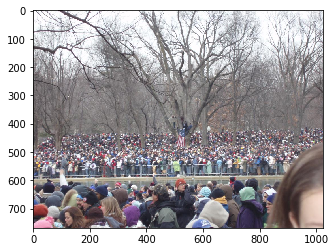

In [26]:
#now see a sample from ShanghaiA
plt.imshow(Image.open(img_paths[0]))

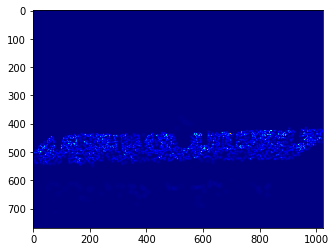

In [27]:
gt_file = h5py.File(img_paths[0].replace('.jpg','.h5').replace('images','ground_truth'),'r')
groundtruth = np.asarray(gt_file['density'])
plt.imshow(groundtruth,cmap=CM.jet)

In [28]:
np.sum(groundtruth)# don't mind this slight variation

1543.841

In [29]:
#now generate the ShanghaiB's ground truth
path_sets = [part_B_train,part_B_test]

In [30]:
img_paths = []
for path in path_sets:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths.append(img_path)

In [32]:
for img_path in img_paths:
    print(img_path)
    mat = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground_truth').replace('IMG_','GT_IMG_'))
    img= plt.imread(img_path)
    k = np.zeros((img.shape[0],img.shape[1]))
    gt = mat["image_info"][0,0][0,0][0]
    for i in range(0,len(gt)):
        if int(gt[i][1])<img.shape[0] and int(gt[i][0])<img.shape[1]:
            k[int(gt[i][1]),int(gt[i][0])]=1
    k = gaussian_filter(k,15)
    with h5py.File(img_path.replace('.jpg','.h5').replace('images','ground_truth'), 'w') as hf:
            hf['density'] = k

D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_final/train_data\images\IMG_1.jpg
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_final/train_data\images\IMG_10.jpg
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_final/train_data\images\IMG_100.jpg
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_final/train_data\images\IMG_101.jpg
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_final/train_data\images\IMG_102.jpg
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_final/train_data\images\IMG_103.jpg
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_final/train_data\images\IMG_104.jpg
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_final/train_data\images\IMG_105.jpg
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_final/train_data\images\IMG_106.jpg
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_final/train_data\images\IMG_107.jpg
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_final/train_data\images\IMG_108.jpg
D:\data\ShanghaiTech_Crowd_Counting_Dataset\pa

D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_final/train_data\images\IMG_184.jpg
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_final/train_data\images\IMG_185.jpg
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_final/train_data\images\IMG_186.jpg
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_final/train_data\images\IMG_187.jpg
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_final/train_data\images\IMG_188.jpg
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_final/train_data\images\IMG_189.jpg
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_final/train_data\images\IMG_19.jpg
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_final/train_data\images\IMG_190.jpg
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_final/train_data\images\IMG_191.jpg
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_final/train_data\images\IMG_192.jpg
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_final/train_data\images\IMG_193.jpg
D:\data\ShanghaiTech_Crowd_Counting_Dataset\

D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_final/train_data\images\IMG_269.jpg
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_final/train_data\images\IMG_27.jpg
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_final/train_data\images\IMG_270.jpg
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_final/train_data\images\IMG_271.jpg
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_final/train_data\images\IMG_272.jpg
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_final/train_data\images\IMG_273.jpg
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_final/train_data\images\IMG_274.jpg
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_final/train_data\images\IMG_275.jpg
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_final/train_data\images\IMG_276.jpg
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_final/train_data\images\IMG_277.jpg
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_final/train_data\images\IMG_278.jpg
D:\data\ShanghaiTech_Crowd_Counting_Dataset\

D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_final/train_data\images\IMG_353.jpg
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_final/train_data\images\IMG_354.jpg
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_final/train_data\images\IMG_355.jpg
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_final/train_data\images\IMG_356.jpg
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_final/train_data\images\IMG_357.jpg
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_final/train_data\images\IMG_358.jpg
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_final/train_data\images\IMG_359.jpg
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_final/train_data\images\IMG_36.jpg
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_final/train_data\images\IMG_360.jpg
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_final/train_data\images\IMG_361.jpg
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_final/train_data\images\IMG_362.jpg
D:\data\ShanghaiTech_Crowd_Counting_Dataset\

D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_final/train_data\images\IMG_78.jpg
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_final/train_data\images\IMG_79.jpg
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_final/train_data\images\IMG_8.jpg
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_final/train_data\images\IMG_80.jpg
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_final/train_data\images\IMG_81.jpg
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_final/train_data\images\IMG_82.jpg
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_final/train_data\images\IMG_83.jpg
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_final/train_data\images\IMG_84.jpg
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_final/train_data\images\IMG_85.jpg
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_final/train_data\images\IMG_86.jpg
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_final/train_data\images\IMG_87.jpg
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_fina

D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_final/test_data\images\IMG_163.jpg
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_final/test_data\images\IMG_164.jpg
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_final/test_data\images\IMG_165.jpg
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_final/test_data\images\IMG_166.jpg
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_final/test_data\images\IMG_167.jpg
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_final/test_data\images\IMG_168.jpg
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_final/test_data\images\IMG_169.jpg
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_final/test_data\images\IMG_17.jpg
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_final/test_data\images\IMG_170.jpg
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_final/test_data\images\IMG_171.jpg
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_final/test_data\images\IMG_172.jpg
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_fina

D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_final/test_data\images\IMG_249.jpg
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_final/test_data\images\IMG_25.jpg
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_final/test_data\images\IMG_250.jpg
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_final/test_data\images\IMG_251.jpg
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_final/test_data\images\IMG_252.jpg
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_final/test_data\images\IMG_253.jpg
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_final/test_data\images\IMG_254.jpg
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_final/test_data\images\IMG_255.jpg
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_final/test_data\images\IMG_256.jpg
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_final/test_data\images\IMG_257.jpg
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_final/test_data\images\IMG_258.jpg
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_fina

D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_final/test_data\images\IMG_5.jpg
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_final/test_data\images\IMG_50.jpg
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_final/test_data\images\IMG_51.jpg
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_final/test_data\images\IMG_52.jpg
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_final/test_data\images\IMG_53.jpg
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_final/test_data\images\IMG_54.jpg
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_final/test_data\images\IMG_55.jpg
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_final/test_data\images\IMG_56.jpg
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_final/test_data\images\IMG_57.jpg
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_final/test_data\images\IMG_58.jpg
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_final/test_data\images\IMG_59.jpg
D:\data\ShanghaiTech_Crowd_Counting_Dataset\part_B_final/test_data